# Using the expression of genes on the X-chromosome to predict young or aged cells (1/5 -- EDA)

## Outline

The **Xgene** workflow consists of three sections:

I. Exploratory data analysis (EDA) (1/5, this notebook):

1. [Loading single cell data and select X genes](#1.-Loading-single-cell-data)
2. [Exploratory data analysis (EDA)](#2.-EDA)
    - [Plots of features of interest](#3.-poa)
    - [Scatter matrix](#4.-scattermatrix)


II. preprocessing and model tunning (2/5)

III. Model comparison (3/5)

IV. Final model over 50 random states (4/5)

V. Results and intepretations (5/5)

In [1]:
import sys
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import os

data_type = 'float32'

In [2]:
import matplotlib as mpl
from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sns

# silence scanpy that prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')

## 1. Loading single cell dataset and select X-chromosome genes <a name="1.-Loading-single-cell-data"></a>
### You can run from step 2 using the 'snhypo_neuron_x.csv'
The snRNAseq of the aging mouse hypothalamus has around 20k neuronal nuclei. We have eight female mice with four 3m old young mice and four 24m old aged mice. 

In [3]:
# load snRNA data
adata_snrna_raw = anndata.read_h5ad("./hypo_neuron_RNA.h5ad")

# cell type annotations
labels = pd.read_csv('neuron_meta.csv', index_col=0)

In [4]:
# remove cells and genes with 0 counts everywhere
sc.pp.filter_cells(adata_snrna_raw, min_genes=1)
sc.pp.filter_genes(adata_snrna_raw, min_cells=1)

# load gene_feature table (e.g. which gene belongs to which chromosome)
chromosome = pd.read_csv('Gene_Features.txt', sep = '\t')
chromosome = chromosome.rename(columns={'Symbol':'features'})
chromosome = chromosome.set_index('features')
chromosome = chromosome.drop(columns='Ensembl')
chromosome.head()

Chromosome  Strand
features                        
0610005C13Rik          7    -1.0
0610006L08Rik          7    -1.0
0610009B22Rik         11    -1.0
0610009E02Rik          2     1.0
0610009L18Rik         11     1.0

In [5]:
adata_snrna_raw.obs = labels
adata_snrna_raw.obs.head()

orig.ident  nCount_RNA  nFeature_RNA  stim  percent.mt  \
AAACCTGAGACTAGAT-1_1     Aged_1        5452          2747  Aged    0.752018   
AAACCTGAGGCCCGTT-1_1     Aged_1        2100          1163  Aged    0.666667   
AAACCTGCAGCATGAG-1_1     Aged_1        3982          2070  Aged    6.604721   
AAACCTGGTCCGTGAC-1_1     Aged_1        3554          2070  Aged    0.619021   
AAACCTGTCGATGAGG-1_1     Aged_1        5196          2756  Aged    0.923788   

                      integrated_snn_res.1.5  seurat_clusters   group  \
AAACCTGAGACTAGAT-1_1                      46               26  Neuron   
AAACCTGAGGCCCGTT-1_1                      32               21  Neuron   
AAACCTGCAGCATGAG-1_1                      14                7  Neuron   
AAACCTGGTCCGTGAC-1_1                       1                2  Neuron   
AAACCTGTCGATGAGG-1_1                       9                6  Neuron   

                      integrated_snn_res.1  integrated_snn_res.0.5  \
AAACCTGAGACTAGAT-1_1                    37                      26   
AAACCTGAGGCCCGTT-1_1                    28                      21   
AAACCTGCAGCATGAG-1_1                     4                       7   
AAACCTGGTCCGTGAC-1_1                     5                       2   
AAACCTGTCGATGAGG-1_1                     3                       6   

                         tree.ident  
AAACCTGAGACTAGAT-1_1        Avp/Oxt  
AAACCTGAGGCCCGTT-1_1      Nrg1/Nnat  
AAACCTGCAGCATGAG-1_1   Meis2/Pou6f2  
AAACCTGGTCCGTGAC-1_1  Npas3/Gm32647  
AAACCTGTCGATGAGG-1_1   Chrm3/Schip1

In [6]:
genes = adata_snrna_raw.var.copy()
genes_merged = pd.merge(genes, chromosome, how='left', on=['features'])
genes_merged = genes_merged.set_index('features')
adata_snrna_raw.var = genes_merged
adata_snrna_raw.var.head()

n_cells Chromosome  Strand
features                            
Xkr4        22989          1    -1.0
Gm1992      11033          1     1.0
Gm19938      6923          1    -1.0
Gm37381         8          1    -1.0
Rp1           149          1    -1.0

In [8]:
adata_snrna_raw.raw = adata_snrna_raw
# convert the adata object into a dataframe which has rownames as cell ID, 
# colnames as gene names
adata_df = pd.DataFrame(data=adata_snrna_raw.raw.X.toarray(), 
                 index=adata_snrna_raw.raw.obs_names, 
                 columns=adata_snrna_raw.raw.var_names)
# adata_df.to_csv('adata_raw_x.csv')

In [9]:
# genes on the X chromosome
Xgenes = list(adata_snrna_raw.var[adata_snrna_raw.var['Chromosome']=='X'].index)
# subset genes on X chromosome 
adata_X = adata_df[Xgenes]

# add another features -- aggregated all/X gene expression and the proportion of X gene expression
adata_df['sum'] = adata_df.sum(axis=1)
adata_df['x_sum'] = adata_df[Xgenes].sum(axis=1)
adata_df['x_prop'] =  adata_df['x_sum']/(adata_df['sum'])
adata_df.head()

features                  Xkr4    Gm1992   Gm19938  Gm37381  Rp1  Sox17  \
AAACCTGAGACTAGAT-1_1  1.540812  0.000000  0.000000      0.0  0.0    0.0   
AAACCTGAGGCCCGTT-1_1  0.000000  0.000000  0.000000      0.0  0.0    0.0   
AAACCTGCAGCATGAG-1_1  0.000000  0.000000  0.000000      0.0  0.0    0.0   
AAACCTGGTCCGTGAC-1_1  1.891222  1.338608  1.338608      0.0  0.0    0.0   
AAACCTGTCGATGAGG-1_1  1.913043  0.000000  0.000000      0.0  0.0    0.0   

features              Mrpl15    Lypla1     Tcea1     Rgs20  ...  Prr32  \
AAACCTGAGACTAGAT-1_1     0.0  0.000000  1.041756  0.000000  ...    0.0   
AAACCTGAGGCCCGTT-1_1     0.0  0.000000  0.000000  0.000000  ...    0.0   
AAACCTGCAGCATGAG-1_1     0.0  0.000000  0.000000  0.000000  ...    0.0   
AAACCTGGTCCGTGAC-1_1     0.0  1.891222  0.000000  0.000000  ...    0.0   
AAACCTGTCGATGAGG-1_1     0.0  0.000000  1.073143  1.073143  ...    0.0   

features              Olfr1322  Gm6760  Gm14685  Gm5640  Gm14715  Gm21693  \
AAACCTGAGACTAGAT-1_1       0.0     0.0      0.0     0.0      0.0      0.0   
AAACCTGAGGCCCGTT-1_1       0.0     0.0      0.0     0.0      0.0      0.0   
AAACCTGCAGCATGAG-1_1       0.0     0.0      0.0     0.0      0.0      0.0   
AAACCTGGTCCGTGAC-1_1       0.0     0.0      0.0     0.0      0.0      0.0   
AAACCTGTCGATGAGG-1_1       0.0     0.0      0.0     0.0      0.0      0.0   

features                      sum       x_sum    x_prop  
AAACCTGAGACTAGAT-1_1  3477.047641  128.435941  0.036938  
AAACCTGAGGCCCGTT-1_1  2213.750159   74.358735  0.033589  
AAACCTGCAGCATGAG-1_1  3115.133693  136.693263  0.043880  
AAACCTGGTCCGTGAC-1_1  3213.846256  112.650185  0.035052  
AAACCTGTCGATGAGG-1_1  3602.011572  130.895194  0.036339  

[5 rows x 25059 columns]

In [10]:
adata_sum = adata_df[['sum', 'x_sum', 'x_prop']]

# filtered out genes that have super low expression (less than 0.1 reads) 
adata_X.loc['mean'] = adata_X.mean()
Xgenes_filtered = list(adata_X.loc['mean'][adata_X.loc['mean']>0.1].index)

# filtered out genes that are detected in less than 1k cells
gene_df = adata_snrna_raw.var
X_genes_df = gene_df.loc[gene_df.index.isin(Xgenes_filtered)]
Xgenes_filtered = list(X_genes_df[X_genes_df['n_cells']>3000].index)
adata_X_filtered = adata_X[Xgenes_filtered]

# calculate the mean of each gene across non-zero cells
adata_snrna_raw.var['n_cells'] = (adata_snrna_raw.X.toarray() > 0).sum(0)
adata_snrna_raw.var['nonz_mean'] = adata_snrna_raw.X.toarray().sum(0) / adata_snrna_raw.var['n_cells']
adata_snrna_raw.var.head()

n_cells Chromosome  Strand  nonz_mean
features                                       
Xkr4        22989          1    -1.0   2.236003
Gm1992      11033          1     1.0   1.177094
Gm19938      6923          1    -1.0   0.967215
Gm37381         8          1    -1.0   0.715256
Rp1           149          1    -1.0   0.770605

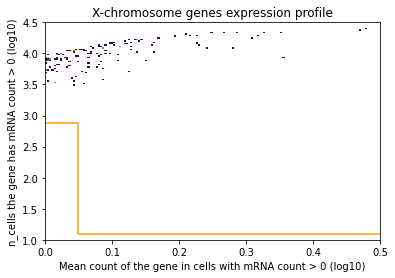

In [20]:
plt.hist2d(np.log10(adata_snrna_raw.var['nonz_mean'][adata_snrna_raw.var.index.isin(Xgenes_filtered)]),
           np.log10(adata_snrna_raw.var['n_cells'][adata_snrna_raw.var.index.isin(Xgenes_filtered)]), 
           bins=int(np.sqrt(adata_snrna_raw.shape[0])),
           norm=mpl.colors.LogNorm(),
           range=[[0,0.5], [1,4.5]]);

nonz_mean_cutoff = np.log10(1.12) # cut off for expression in non-zero cells 
cell_count_cutoff = np.log10(adata_snrna_raw.shape[0] * 0.0005) # cut off percentage for cells with higher expression
cell_count_cutoff2 = np.log10(adata_snrna_raw.shape[0] * 0.03)# cut off percentage for cells with small expression

plt.vlines(nonz_mean_cutoff, cell_count_cutoff, cell_count_cutoff2, color = 'orange');
plt.hlines(cell_count_cutoff, nonz_mean_cutoff, 1, color = 'orange');
plt.hlines(cell_count_cutoff2, 0, nonz_mean_cutoff, color = 'orange');
plt.title('X-chromosome genes expression profile');
plt.xlabel('Mean count of the gene in cells with mRNA count > 0 (log10)');
plt.ylabel('n_cells the gene has mRNA count > 0 (log10)');

In [11]:
adata_X_filtered = adata_X_filtered[0:-1]
adata_X_filtered['group'] = adata_X_filtered.index.str[-1].astype('int32')
adata_X_filtered['target'] = 0
adata_X_filtered['target'][adata_X_filtered['group'] < 5]=1

merged_features = pd.merge(pd.DataFrame(adata_snrna_raw.obs['tree.ident']), adata_X_filtered,
                           left_index=True, right_index=True)
merged_features = pd.merge(merged_features,adata_sum, 
                           left_index=True, right_index=True)
merged_features.head()

tree.ident  Gm26618     Clcn5       Syp  Gm14703  \
AAACCTGAGACTAGAT-1_1        Avp/Oxt      0.0  1.041756  1.872197      0.0   
AAACCTGAGGCCCGTT-1_1      Nrg1/Nnat      0.0  0.000000  1.751268      0.0   
AAACCTGCAGCATGAG-1_1   Meis2/Pou6f2      0.0  0.000000  1.795519      0.0   
AAACCTGGTCCGTGAC-1_1  Npas3/Gm32647      0.0  0.000000  0.000000      0.0   
AAACCTGTCGATGAGG-1_1   Chrm3/Schip1      0.0  0.000000  1.073143      0.0   

                         Gpkow  Praf2   Gripap1  Otud5      Pim2  ...  \
AAACCTGAGACTAGAT-1_1  0.000000    0.0  0.000000    0.0  0.000000  ...   
AAACCTGAGGCCCGTT-1_1  0.000000    0.0  0.000000    0.0  1.751268  ...   
AAACCTGCAGCATGAG-1_1  0.000000    0.0  0.000000    0.0  0.000000  ...   
AAACCTGGTCCGTGAC-1_1  1.338608    0.0  0.000000    0.0  0.000000  ...   
AAACCTGTCGATGAGG-1_1  0.000000    0.0  1.073143    0.0  1.073143  ...   

                        Frmpd4   Arhgap6  Gm15261  Gm15246      Mid1  group  \
AAACCTGAGACTAGAT-1_1  2.319535  0.000000      0.0      0.0  0.000000      1   
AAACCTGAGGCCCGTT-1_1  0.000000  0.000000      0.0      0.0  0.000000      1   
AAACCTGCAGCATGAG-1_1  2.144047  0.000000      0.0      0.0  0.000000      1   
AAACCTGGTCCGTGAC-1_1  0.000000  0.000000      0.0      0.0  0.000000      1   
AAACCTGTCGATGAGG-1_1  1.578796  1.073143      0.0      0.0  1.073143      1   

                      target          sum       x_sum    x_prop  
AAACCTGAGACTAGAT-1_1       1  3477.047641  128.435941  0.036938  
AAACCTGAGGCCCGTT-1_1       1  2213.750159   74.358735  0.033589  
AAACCTGCAGCATGAG-1_1       1  3115.133693  136.693263  0.043880  
AAACCTGGTCCGTGAC-1_1       1  3213.846256  112.650185  0.035052  
AAACCTGTCGATGAGG-1_1       1  3602.011572  130.895194  0.036339  

[5 rows x 284 columns]

In [12]:
# merged_features.to_csv('snhypo_neuron_x_12.csv')

In [15]:
# one subset of X chromosome genes shown correlation with cognition (AD) in a literature
AD_genes = ['Apln','Foxo4','Mid1ip1','Med12','Ppef1','Eif1ax',
     'Gprasp2','Gm45015','Tmem29','Xk','Acsl4','Rlim',
     'Jade3','Irak1','Gripap1','Bex2','Bex1','Il2rg','Gm20489',
     'Nap1l2','Otud5','Rab9','Dynlt3','Pnck','Pola1']
AD = []
for i in range(0,len(AD_genes)):
        if AD_genes[i] in Xgenes_filtered:
            AD.append(AD_genes[i])

X_AD = adata_X_filtered[AD]
X_AD.shape

(25002, 14)

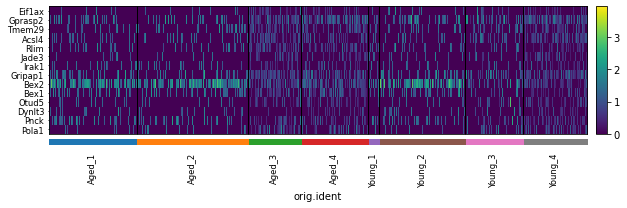

In [17]:
sc.pl.heatmap(adata_snrna_raw, AD, groupby='orig.ident', show_gene_labels=True, swap_axes = True)

## 2. Exploratory Data Analysis (EDA)  <a name="2.-EDA"></a>
### a) use .describe or .value_counts and create histograms or bar plots  

In [18]:
merged_features = pd.read_csv('snhypo_neuron_x_12.csv', index_col=0)

In [20]:
def visualize_groups(classes, groups, name):
    # Visualize dataset groups
    fig, ax = plt.subplots()
    ax.scatter(range(len(groups)),  [.5] * len(groups), c=groups, marker='_',
               lw=50, cmap=cmap_data)
    ax.scatter(range(len(groups)),  [3.5] * len(groups), c=classes, marker='_',
               lw=50, cmap=cmap_data)
    ax.set(ylim=[-1, 5], yticks=[.5, 3.5],
           yticklabels=['Data\ngroup', 'Data\nclass'], xlabel="Sample index")

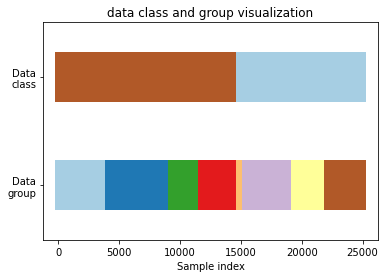

In [22]:
y = merged_features['target']
cmap_data = plt.cm.Paired

group = merged_features['group']
visualize_groups(y, group, 'no groups')
plt.title('data class and group visualization')
plt.savefig('group.png', dpi=300)

In [23]:
# how many rows and columns in the dataframe?
merged_features.shape

(25002, 284)

In [24]:
# what are the datatypes of the columns?
merged_features.dtypes

tree.ident     object
Gm26618       float64
Clcn5         float64
Syp           float64
Gm14703       float64
               ...   
group           int64
target          int64
sum           float64
x_sum         float64
x_prop        float64
Length: 284, dtype: object

- tree.ident (cell type) is categorical datatype
- gene expression (number of sequencing reads) is float 64
- group ID is int 64
- target variable (young: 0, aged: 1) is int 64

         target
young  0.405968
aged   0.594032


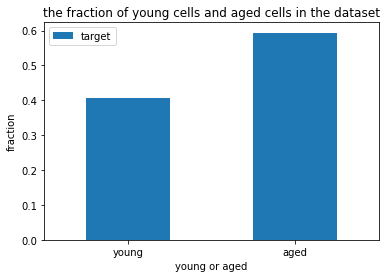

In [25]:
# check and the varget variable:
target_count = pd.value_counts(merged_features['target'],normalize=True).sort_values()
target_count = pd.DataFrame(target_count).rename(index={0:'young',1:'aged'})
print(target_count)
target_count.plot.bar()
plt.title('the fraction of young cells and aged cells in the dataset')
plt.xticks(rotation=0, horizontalalignment="center")
plt.xlabel('young or aged')
plt.ylabel('fraction')
plt.show()

In [26]:
# to visualize every column and its relationship with the target variable:
y = merged_features['target'] # target
X = merged_features.loc[:, merged_features.columns != 'target'] # all other columns are features

Gm26618:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.164964
std          0.385118
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.957416
Name: Gm26618, dtype: float64


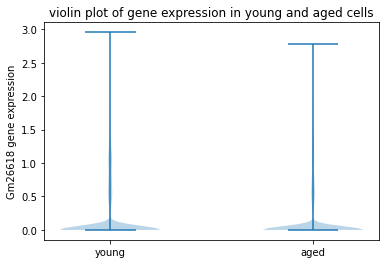

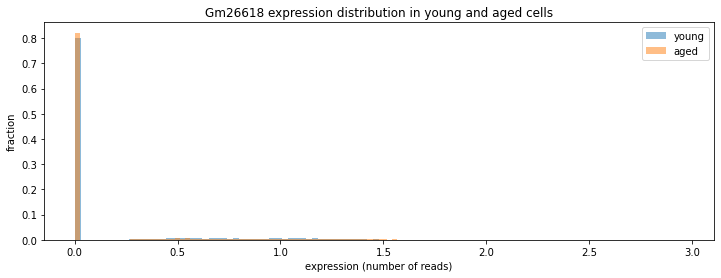

Clcn5:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.275420
std          0.502503
min          0.000000
25%          0.000000
50%          0.000000
75%          0.451689
max          3.294874
Name: Clcn5, dtype: float64


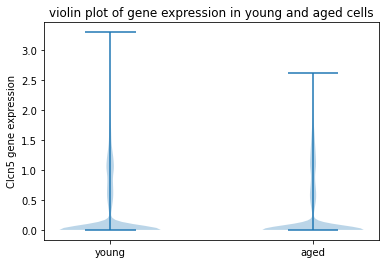

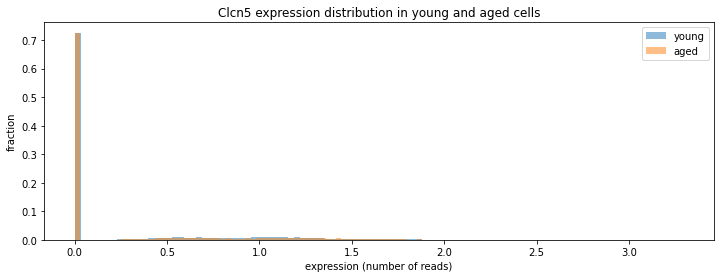

Syp:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.879134
std          0.759186
min          0.000000
25%          0.000000
50%          0.957732
75%          1.464034
max          3.430124
Name: Syp, dtype: float64


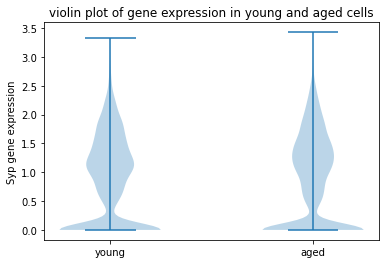

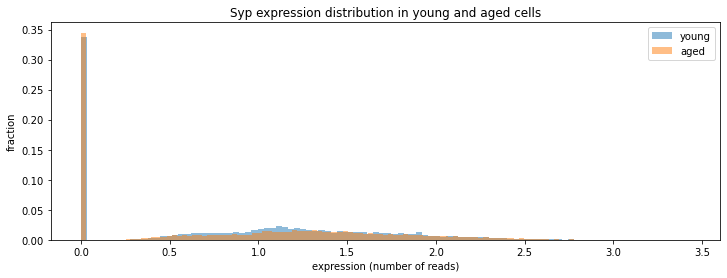

Gm14703:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.159358
std          0.392324
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.666940
Name: Gm14703, dtype: float64


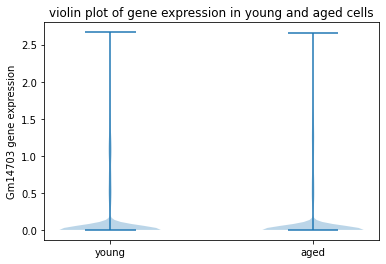

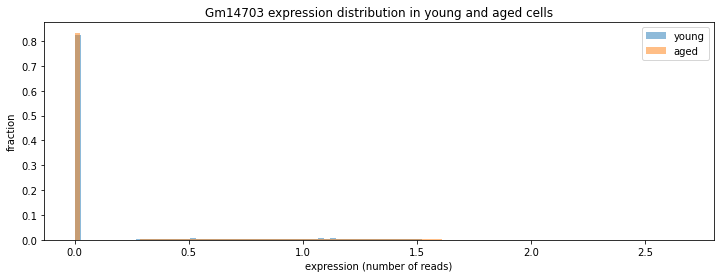

Gpkow:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.132164
std          0.347921
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.387057
Name: Gpkow, dtype: float64


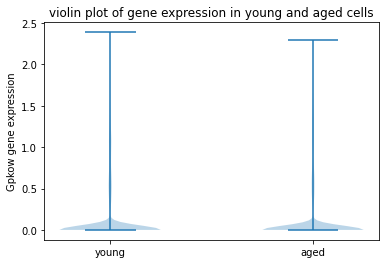

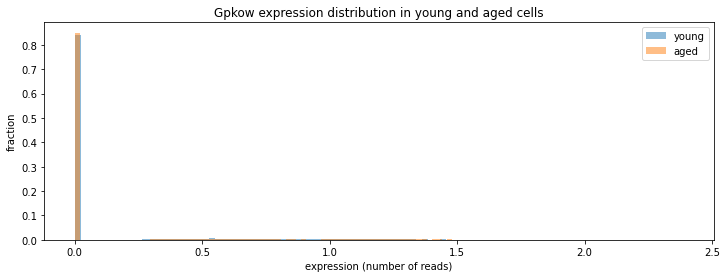

Praf2:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.163750
std          0.425365
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          3.206669
Name: Praf2, dtype: float64


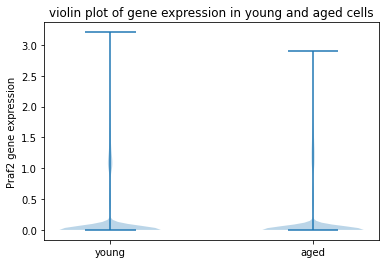

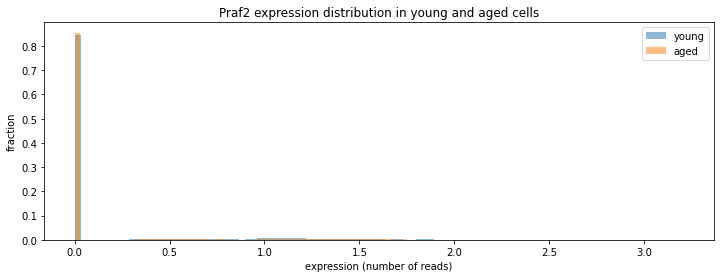

Gripap1:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.384603
std          0.552995
min          0.000000
25%          0.000000
50%          0.000000
75%          0.792841
max          3.260504
Name: Gripap1, dtype: float64


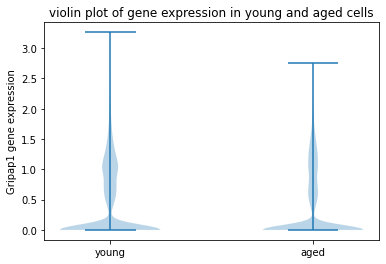

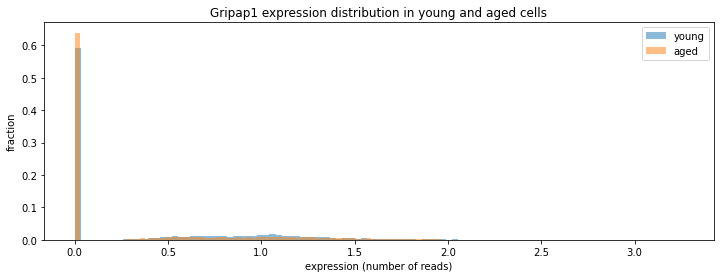

Otud5:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.148772
std          0.364226
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.881959
Name: Otud5, dtype: float64


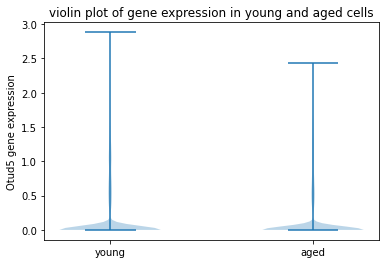

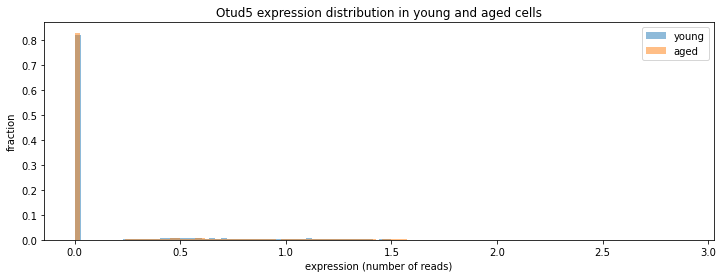

Pim2:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.216570
std          0.451919
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          3.437283
Name: Pim2, dtype: float64


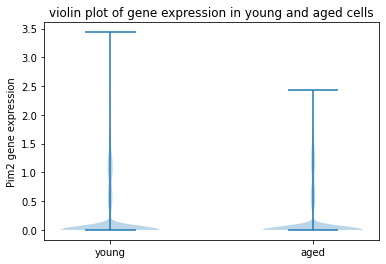

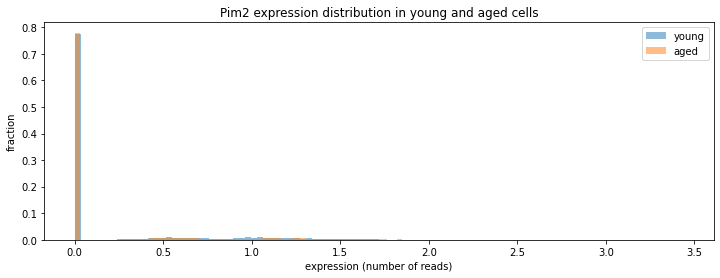

Slc35a2:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.127735
std          0.351446
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.789149
Name: Slc35a2, dtype: float64


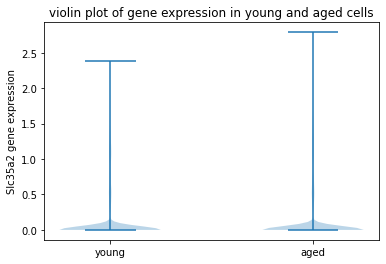

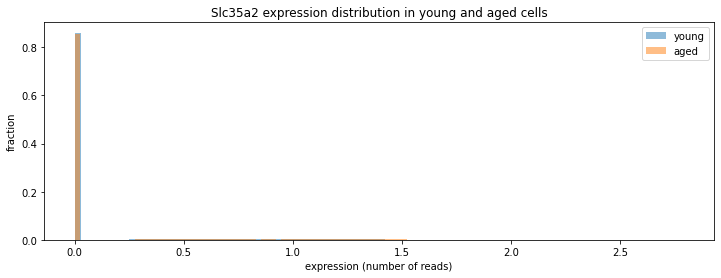

Pcsk1n:
is a continuous feature, and here is the summary
count    25002.000000
mean         1.846988
std          1.188355
min          0.000000
25%          0.860080
50%          1.870337
75%          2.877200
max          4.803090
Name: Pcsk1n, dtype: float64


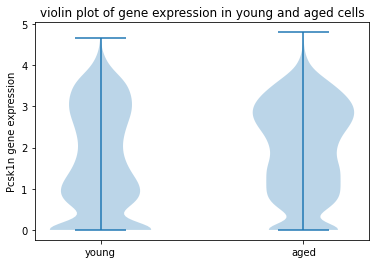

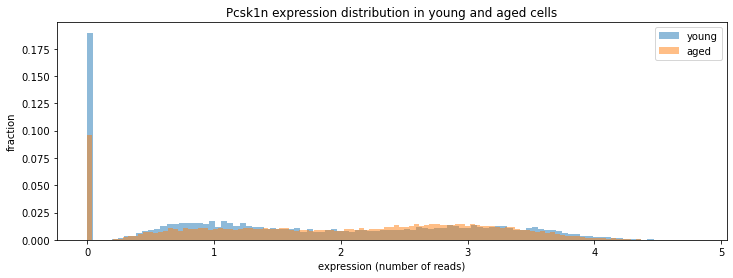

Hdac6:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.158182
std          0.379063
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.522102
Name: Hdac6, dtype: float64


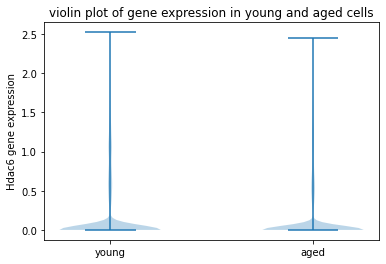

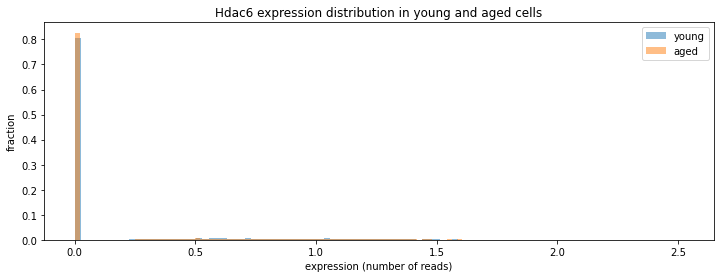

Wdr13:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.139273
std          0.356206
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.680128
Name: Wdr13, dtype: float64


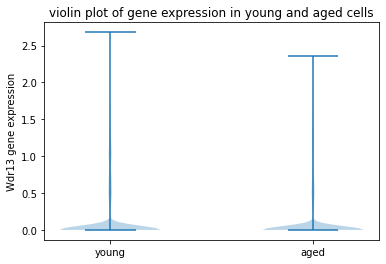

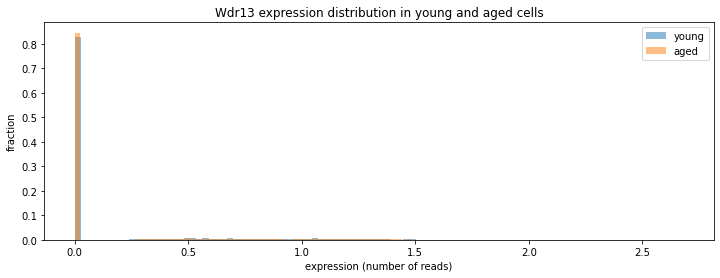

Rbm3:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.286465
std          0.507207
min          0.000000
25%          0.000000
50%          0.000000
75%          0.487130
max          2.962621
Name: Rbm3, dtype: float64


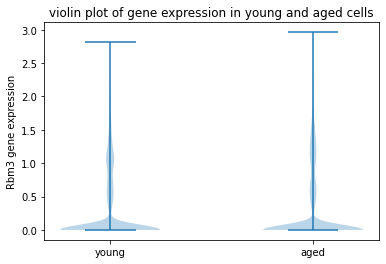

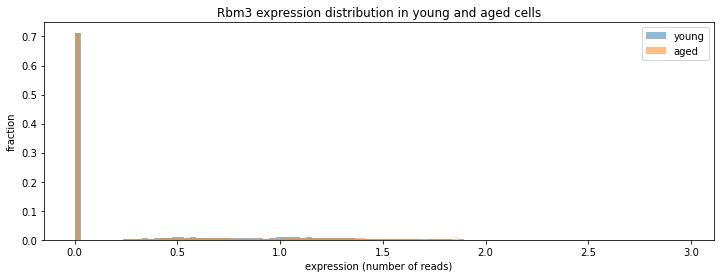

Porcn:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.122618
std          0.340048
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.680128
Name: Porcn, dtype: float64


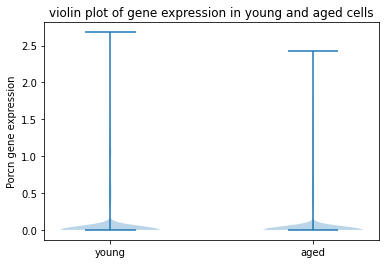

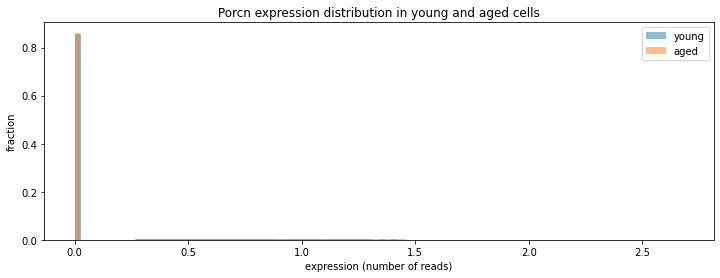

B630019K06Rik:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.136035
std          0.392171
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.741729
Name: B630019K06Rik, dtype: float64


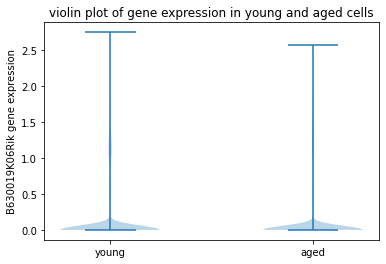

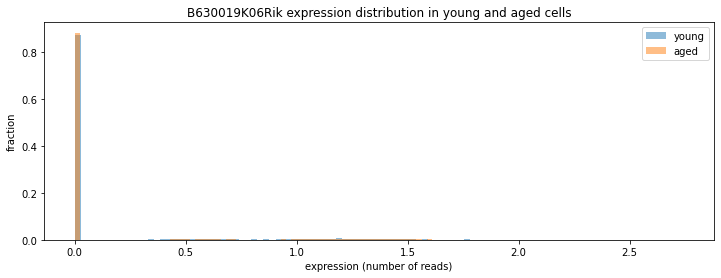

Dynlt3:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.152819
std          0.391642
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.924298
Name: Dynlt3, dtype: float64


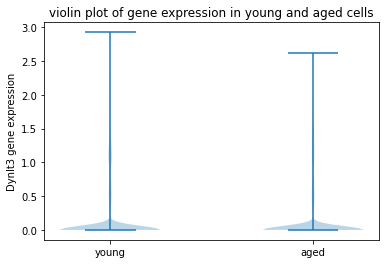

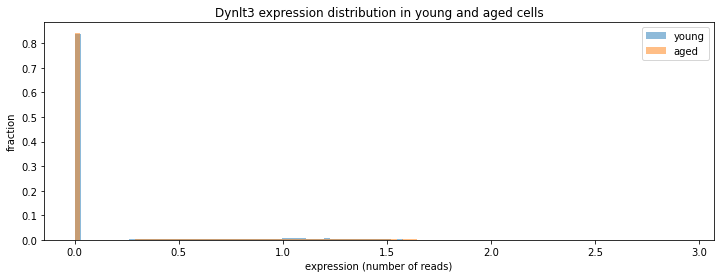

Rpgr:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.321360
std          0.510847
min          0.000000
25%          0.000000
50%          0.000000
75%          0.654252
max          3.052174
Name: Rpgr, dtype: float64


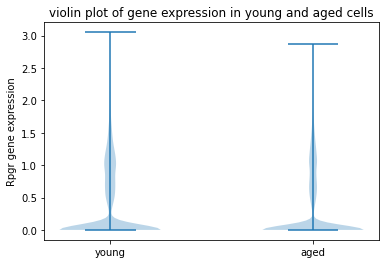

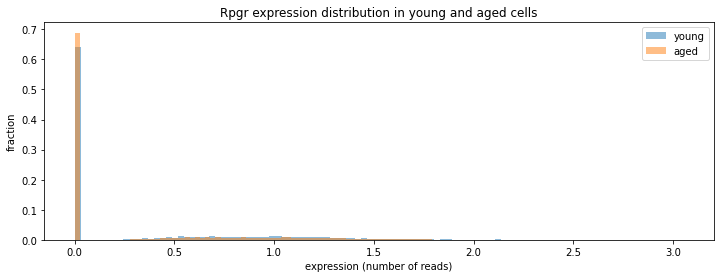

Tspan7:
is a continuous feature, and here is the summary
count    25002.000000
mean         1.207213
std          0.791798
min          0.000000
25%          0.623229
50%          1.342148
75%          1.790719
max          3.676827
Name: Tspan7, dtype: float64


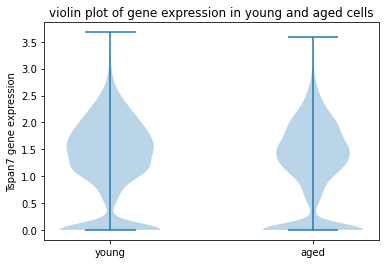

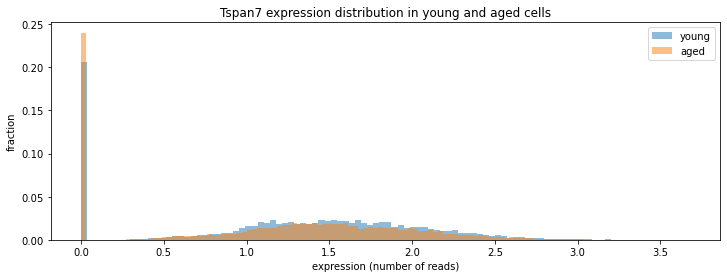

Bcor:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.139251
std          0.366542
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          3.045793
Name: Bcor, dtype: float64


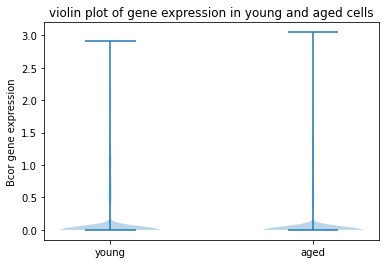

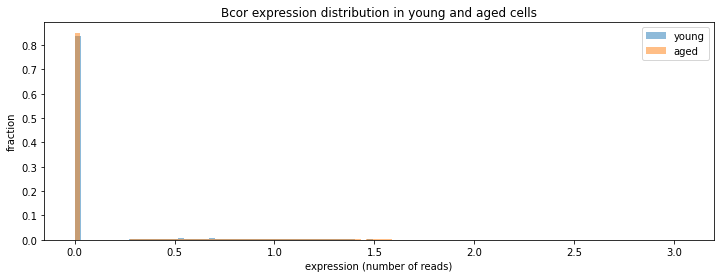

Atp6ap2:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.701696
std          0.729130
min          0.000000
25%          0.000000
50%          0.601532
75%          1.279650
max          3.240634
Name: Atp6ap2, dtype: float64


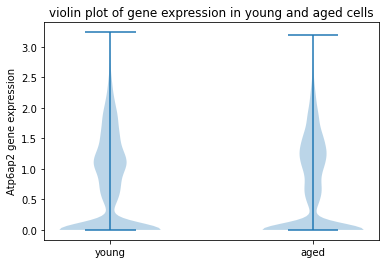

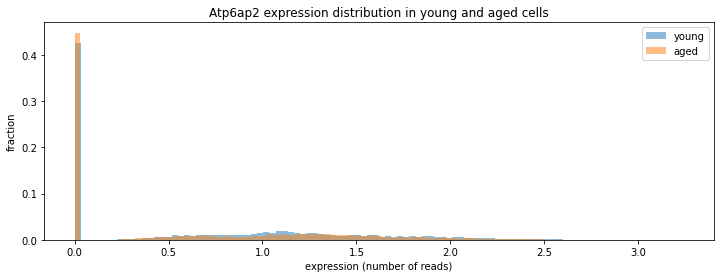

Med14:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.335992
std          0.532466
min          0.000000
25%          0.000000
50%          0.000000
75%          0.660263
max          3.163637
Name: Med14, dtype: float64


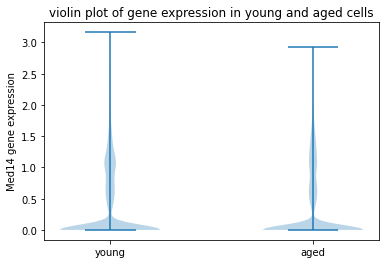

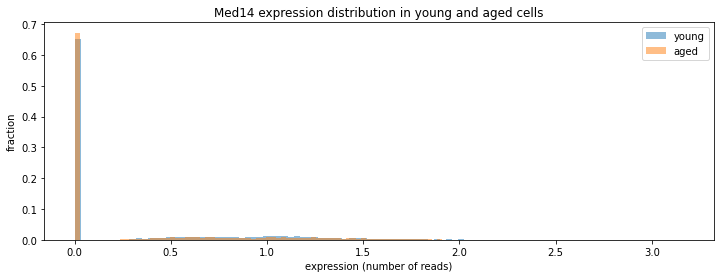

Gm14634:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.172685
std          0.419438
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.683933
Name: Gm14634, dtype: float64


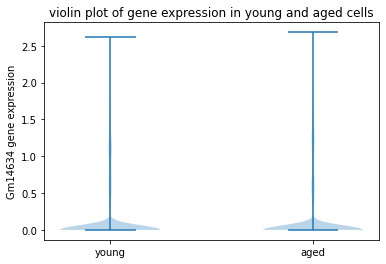

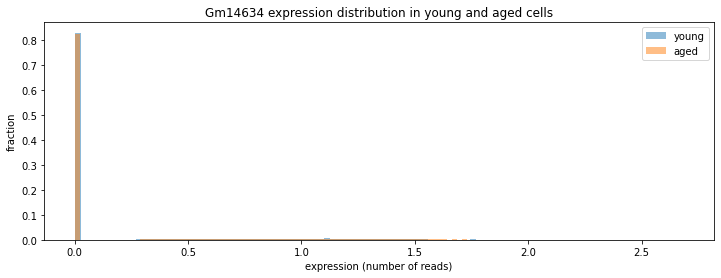

Usp9x:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.898799
std          0.736656
min          0.000000
25%          0.000000
50%          1.069610
75%          1.473817
max          3.416728
Name: Usp9x, dtype: float64


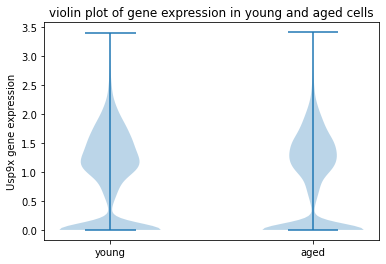

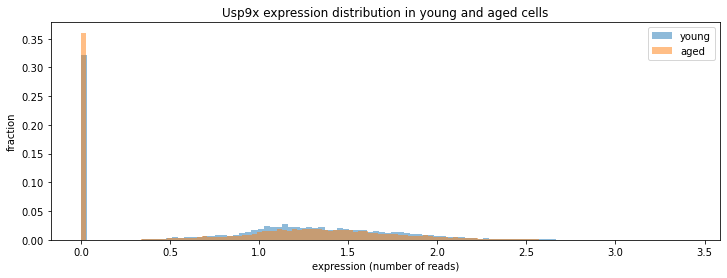

Ddx3x:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.287167
std          0.496849
min          0.000000
25%          0.000000
50%          0.000000
75%          0.519735
max          3.129646
Name: Ddx3x, dtype: float64


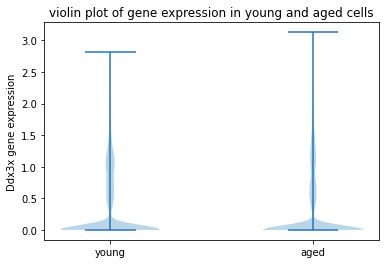

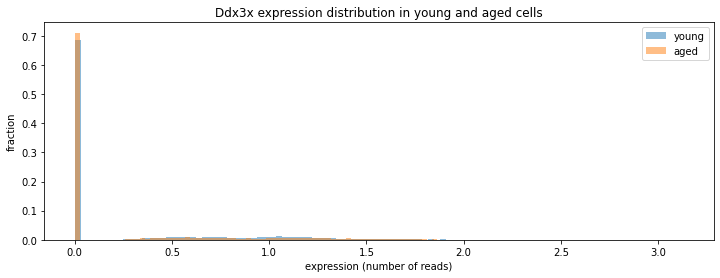

Cask:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.807205
std          0.737640
min          0.000000
25%          0.000000
50%          0.941603
75%          1.409537
max          3.459989
Name: Cask, dtype: float64


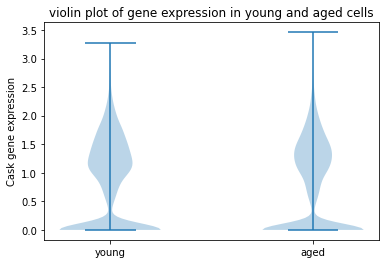

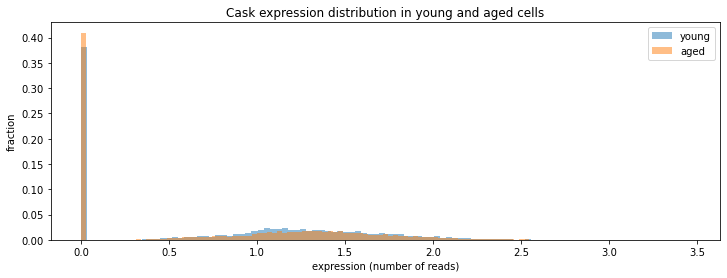

Maoa:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.143849
std          0.379123
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.680761
Name: Maoa, dtype: float64


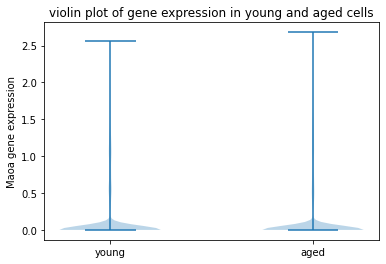

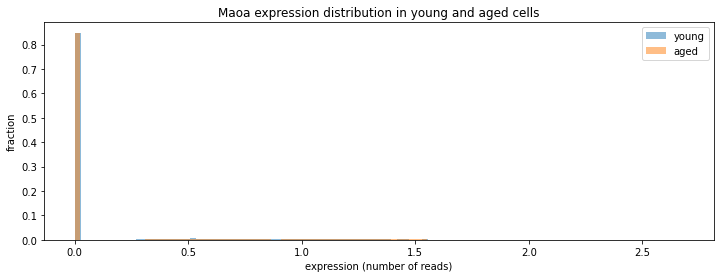

Kdm6a:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.521151
std          0.633499
min          0.000000
25%          0.000000
50%          0.000000
75%          1.070113
max          3.201002
Name: Kdm6a, dtype: float64


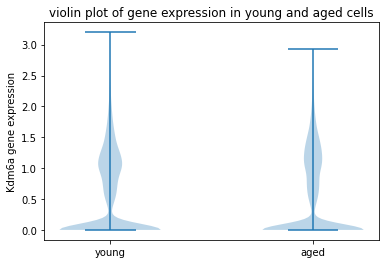

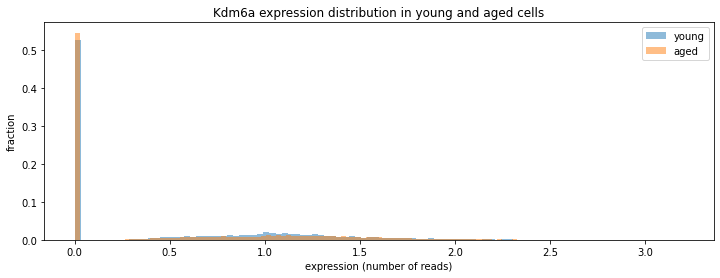

Slc9a7:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.516789
std          0.622665
min          0.000000
25%          0.000000
50%          0.000000
75%          1.062960
max          3.218108
Name: Slc9a7, dtype: float64


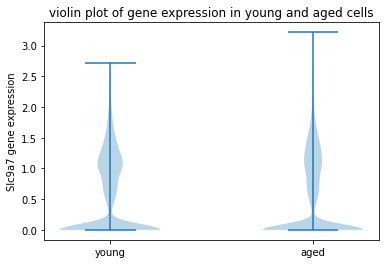

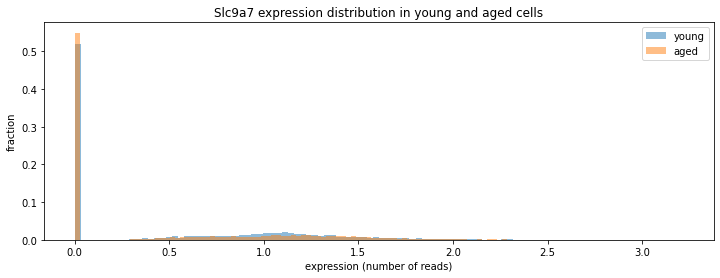

Jade3:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.174602
std          0.399681
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.697382
Name: Jade3, dtype: float64


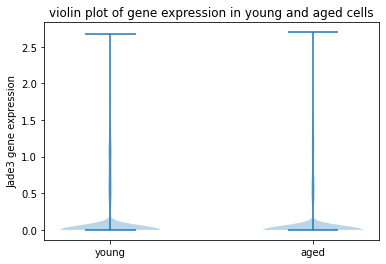

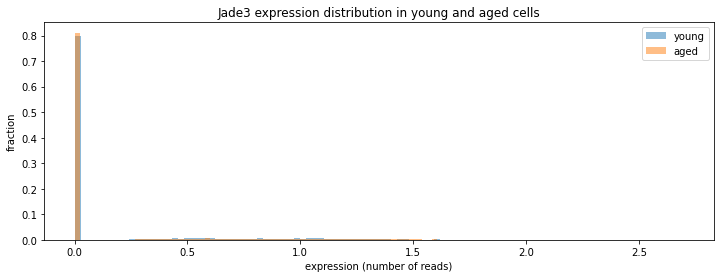

Ndufb11:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.292592
std          0.561987
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          3.131390
Name: Ndufb11, dtype: float64


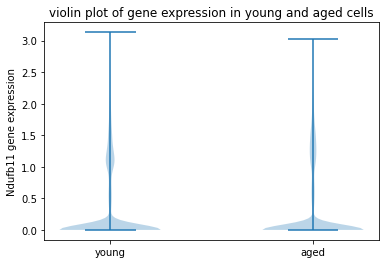

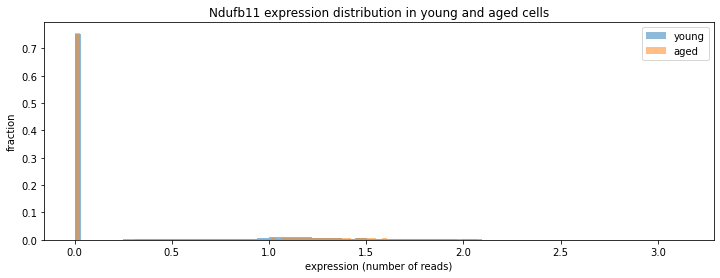

Rbm10:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.297918
std          0.505016
min          0.000000
25%          0.000000
50%          0.000000
75%          0.553909
max          3.156881
Name: Rbm10, dtype: float64


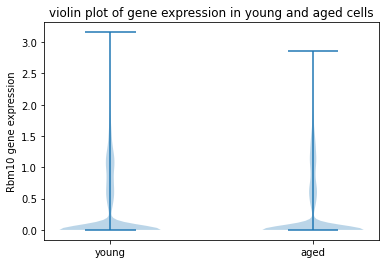

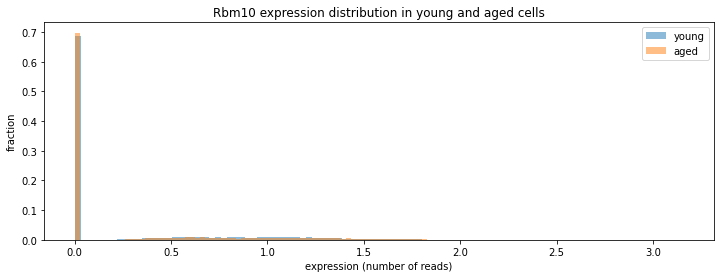

Uba1:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.171747
std          0.397226
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.630924
Name: Uba1, dtype: float64


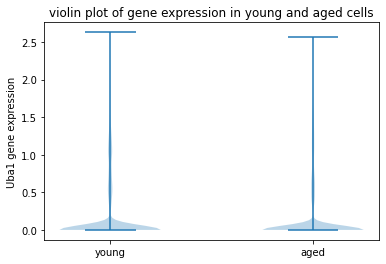

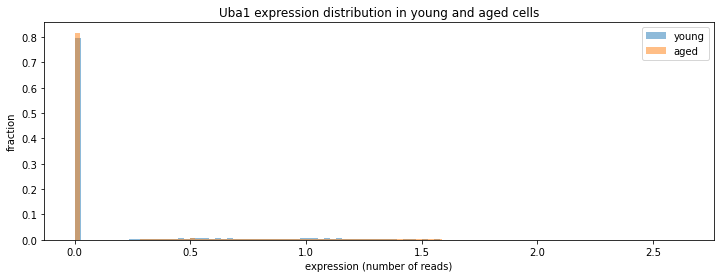

Cdk16:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.186036
std          0.405091
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.558695
Name: Cdk16, dtype: float64


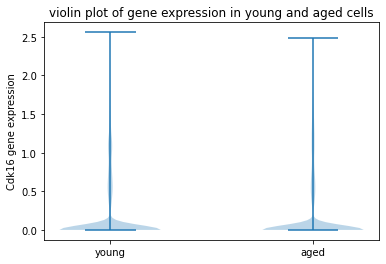

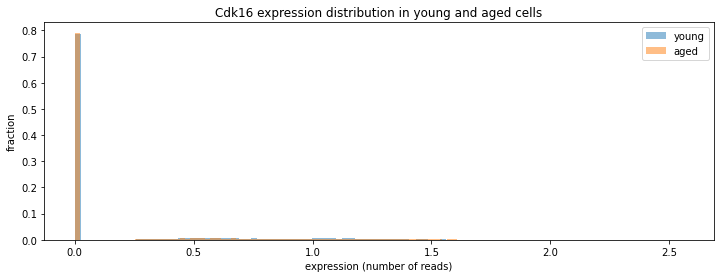

Usp11:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.344823
std          0.537982
min          0.000000
25%          0.000000
50%          0.000000
75%          0.688320
max          3.444449
Name: Usp11, dtype: float64


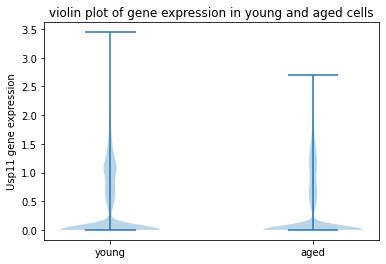

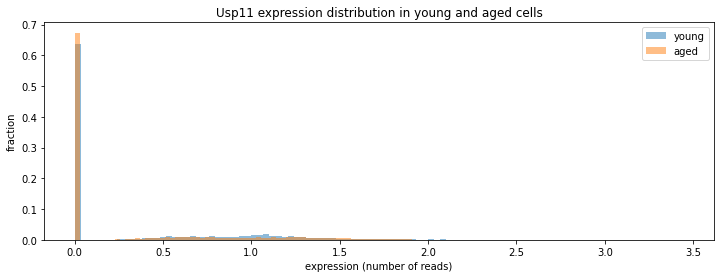

Araf:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.841901
std          0.746484
min          0.000000
25%          0.000000
50%          0.929187
75%          1.424450
max          3.404926
Name: Araf, dtype: float64


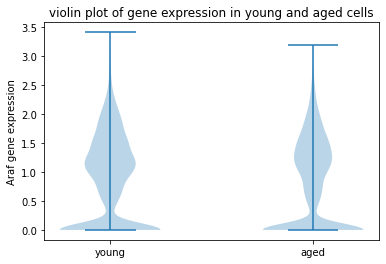

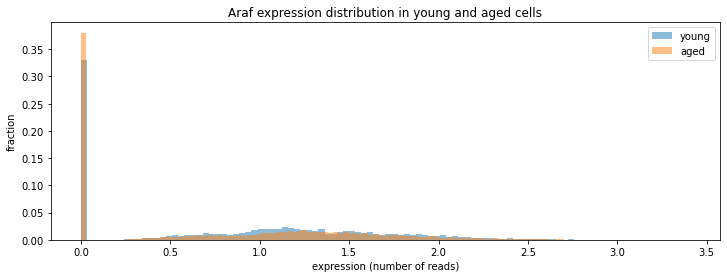

Syn1:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.734841
std          0.713935
min          0.000000
25%          0.000000
50%          0.743260
75%          1.298653
max          3.275078
Name: Syn1, dtype: float64


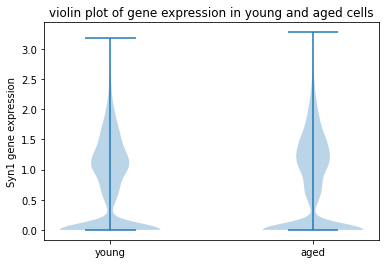

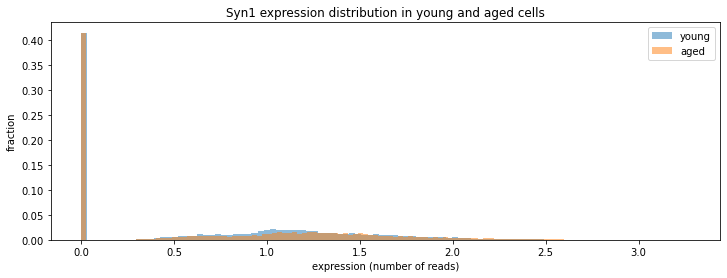

Zfp182:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.324926
std          0.533486
min          0.000000
25%          0.000000
50%          0.000000
75%          0.617664
max          3.467180
Name: Zfp182, dtype: float64


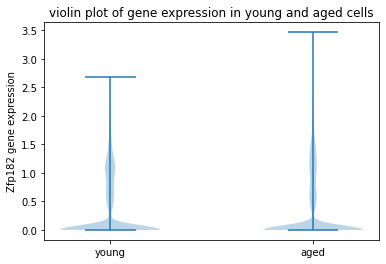

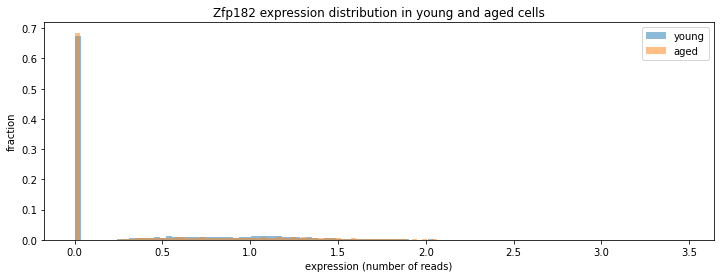

Klhl13:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.217926
std          0.461160
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.983747
Name: Klhl13, dtype: float64


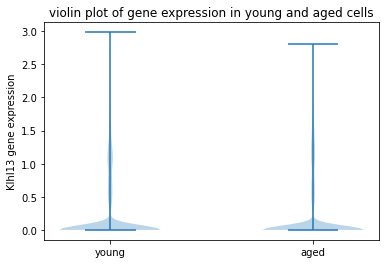

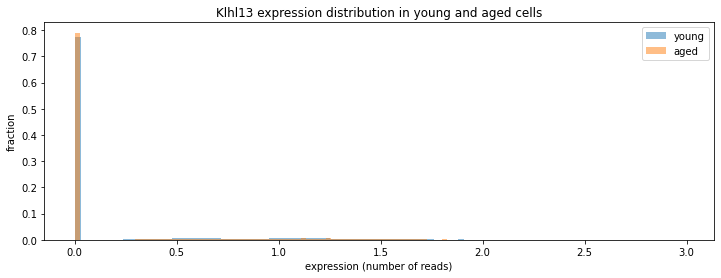

Wdr44:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.170445
std          0.389528
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.900439
Name: Wdr44, dtype: float64


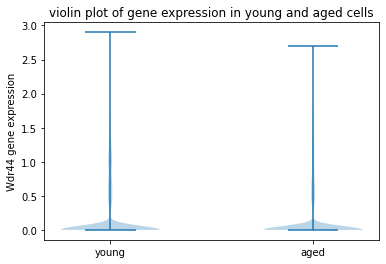

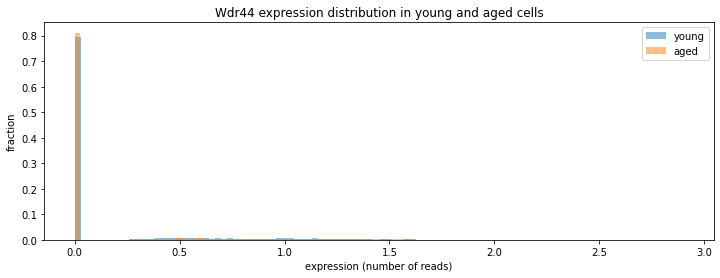

Dock11:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.328329
std          0.557330
min          0.000000
25%          0.000000
50%          0.000000
75%          0.608976
max          3.072569
Name: Dock11, dtype: float64


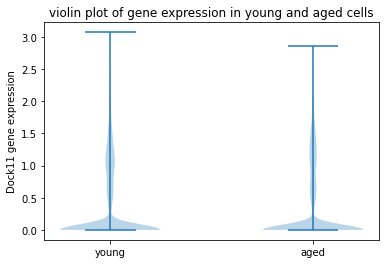

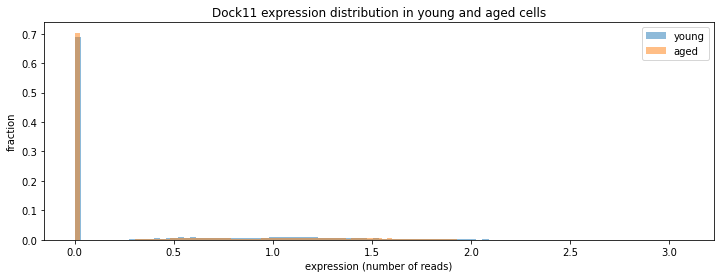

Zcchc12:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.317012
std          0.525330
min          0.000000
25%          0.000000
50%          0.000000
75%          0.599989
max          2.763031
Name: Zcchc12, dtype: float64


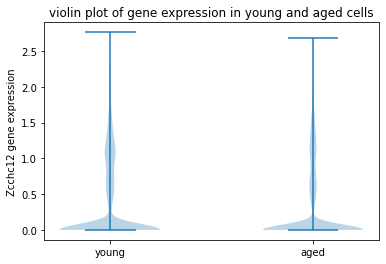

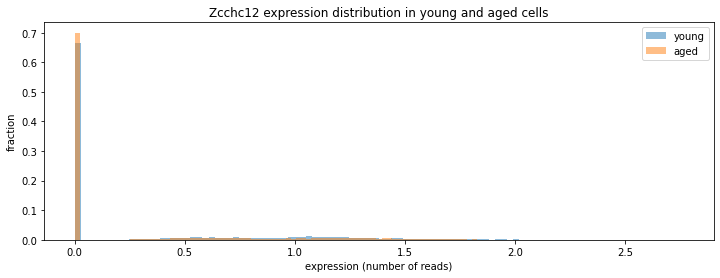

Pgrmc1:
is a continuous feature, and here is the summary
count    25002.000000
mean         1.145195
std          0.898939
min          0.000000
25%          0.000000
50%          1.172221
75%          1.860171
max          3.982904
Name: Pgrmc1, dtype: float64


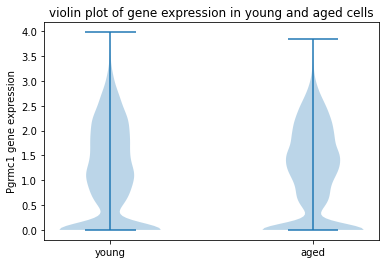

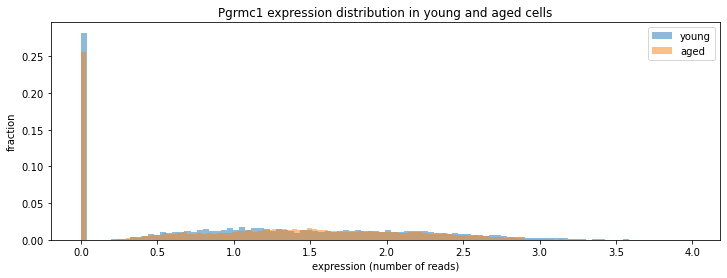

Akap17b:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.252342
std          0.473985
min          0.000000
25%          0.000000
50%          0.000000
75%          0.372793
max          2.916825
Name: Akap17b, dtype: float64


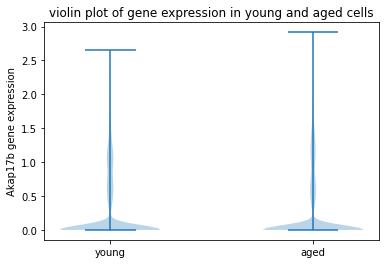

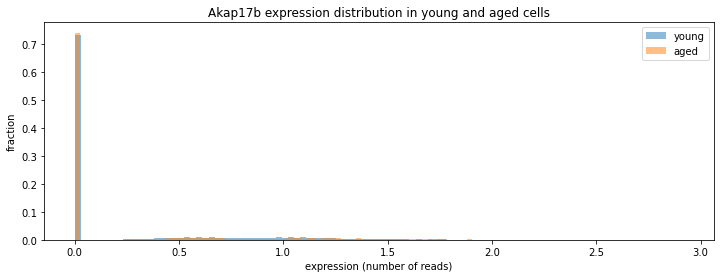

Slc25a5:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.146508
std          0.393994
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.770716
Name: Slc25a5, dtype: float64


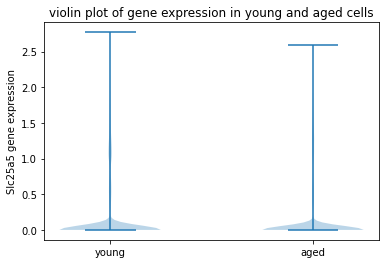

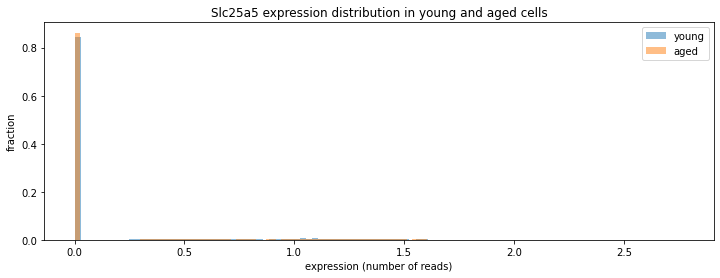

C330007P06Rik:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.151193
std          0.380223
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.943681
Name: C330007P06Rik, dtype: float64


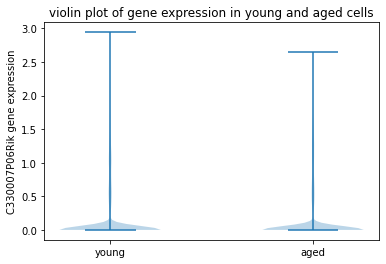

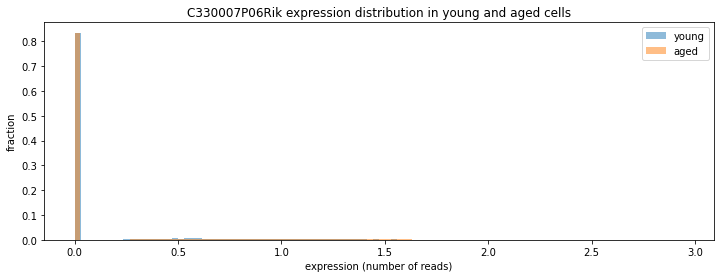

Sept6:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.221034
std          0.446730
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.930153
Name: Sept6, dtype: float64


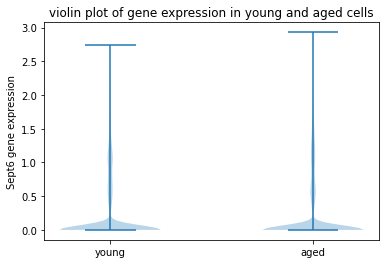

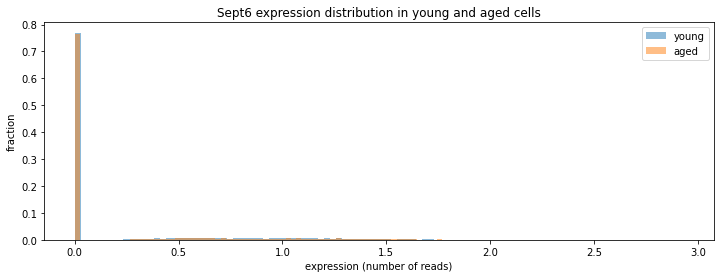

Rpl39:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.490581
std          0.701441
min          0.000000
25%          0.000000
50%          0.000000
75%          1.091973
max          3.312549
Name: Rpl39, dtype: float64


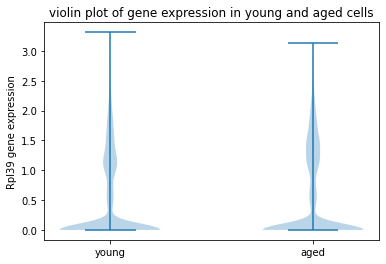

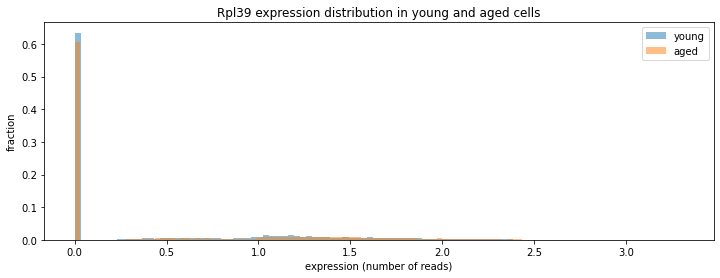

Upf3b:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.307326
std          0.511090
min          0.000000
25%          0.000000
50%          0.000000
75%          0.589758
max          2.810908
Name: Upf3b, dtype: float64


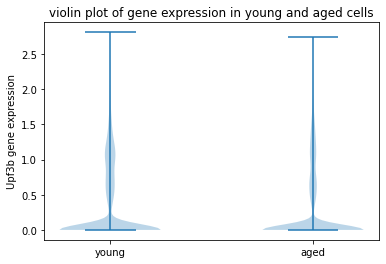

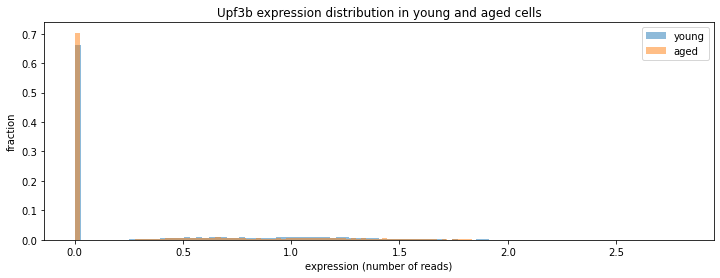

Nkap:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.122359
std          0.338064
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.663829
Name: Nkap, dtype: float64


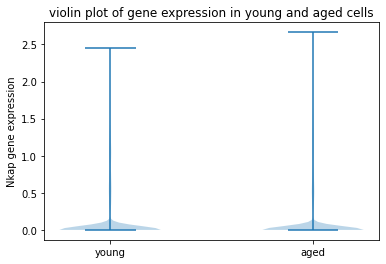

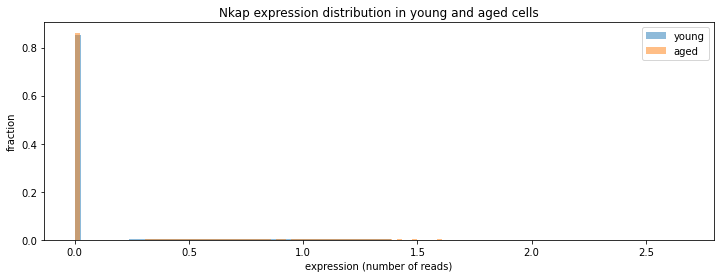

Ndufa1:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.231202
std          0.502186
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          3.124087
Name: Ndufa1, dtype: float64


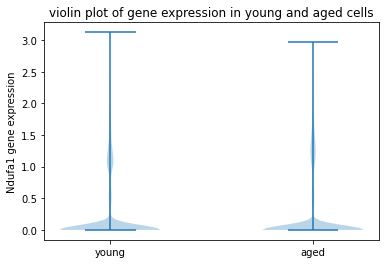

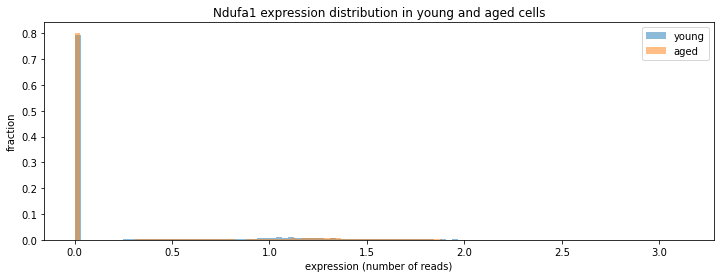

Tmem255a:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.480169
std          0.662142
min          0.000000
25%          0.000000
50%          0.000000
75%          1.044325
max          3.355590
Name: Tmem255a, dtype: float64


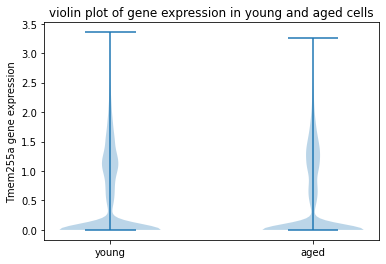

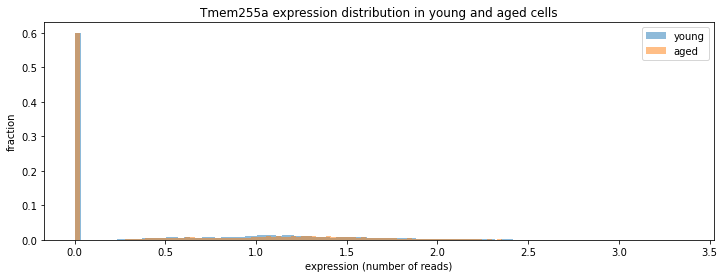

Lamp2:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.292837
std          0.493935
min          0.000000
25%          0.000000
50%          0.000000
75%          0.561805
max          2.903693
Name: Lamp2, dtype: float64


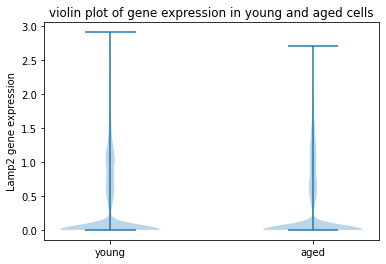

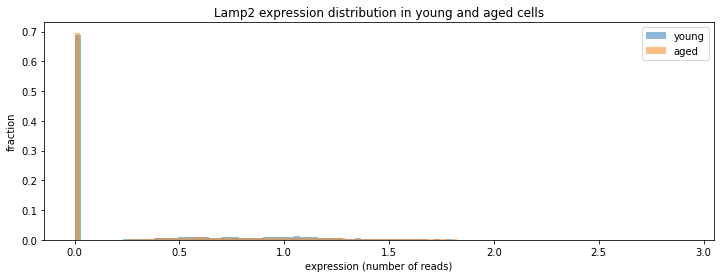

Cul4b:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.106070
std          0.311684
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.676970
Name: Cul4b, dtype: float64


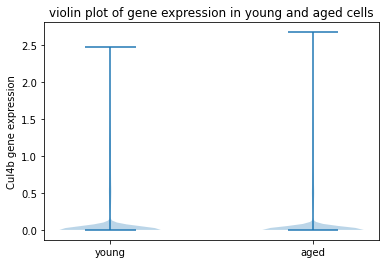

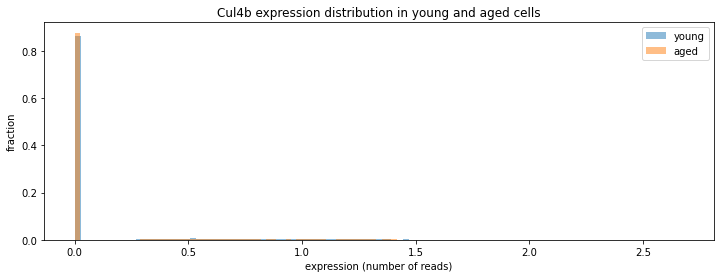

Mcts1:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.321112
std          0.526573
min          0.000000
25%          0.000000
50%          0.000000
75%          0.609144
max          2.862295
Name: Mcts1, dtype: float64


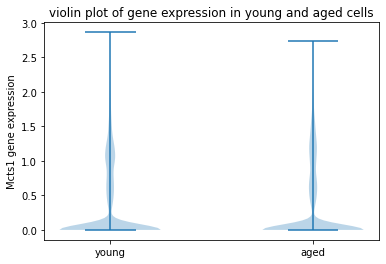

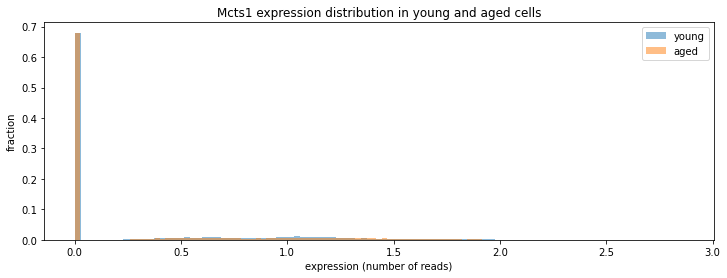

Gria3:
is a continuous feature, and here is the summary
count    25002.000000
mean         1.034705
std          0.934648
min          0.000000
25%          0.000000
50%          1.148173
75%          1.824834
max          3.657637
Name: Gria3, dtype: float64


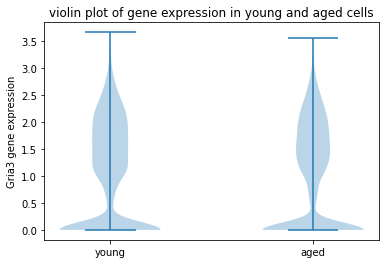

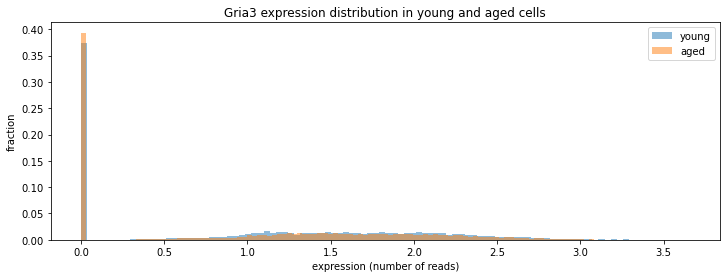

Thoc2:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.747562
std          0.696169
min          0.000000
25%          0.000000
50%          0.824571
75%          1.298731
max          3.096788
Name: Thoc2, dtype: float64


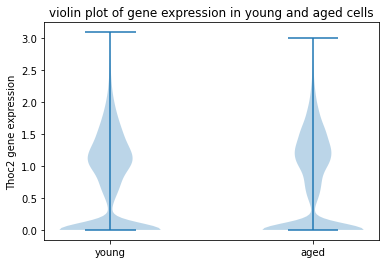

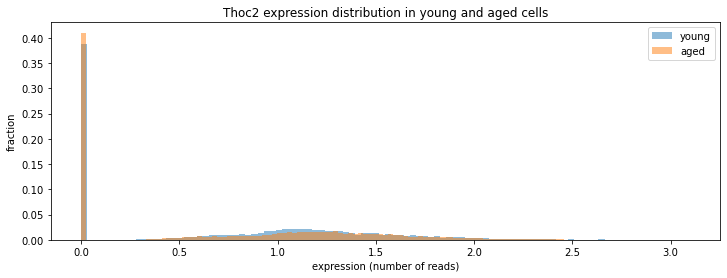

Xiap:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.348667
std          0.541369
min          0.000000
25%          0.000000
50%          0.000000
75%          0.697058
max          3.543046
Name: Xiap, dtype: float64


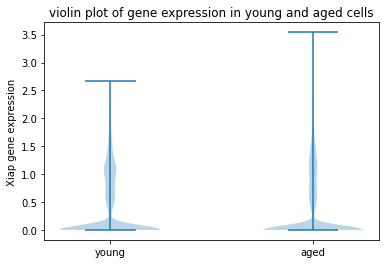

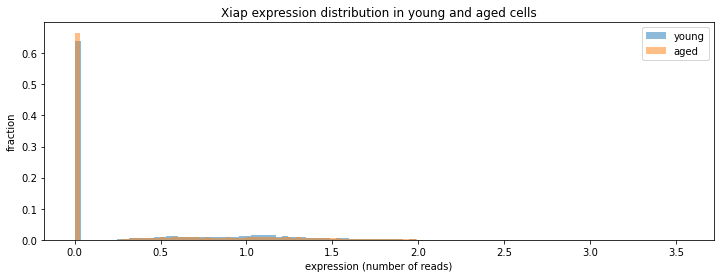

Stag2:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.473454
std          0.609199
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000525
max          2.962621
Name: Stag2, dtype: float64


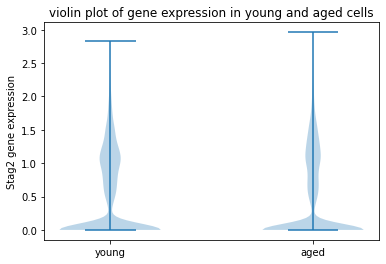

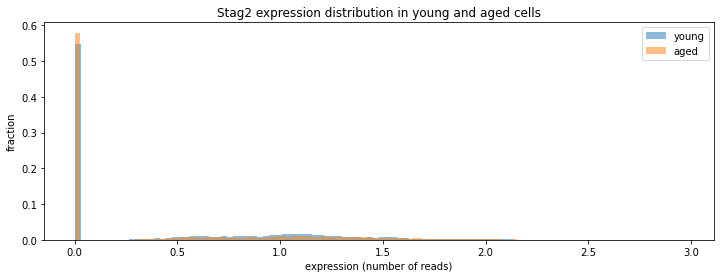

Tenm1:
is a continuous feature, and here is the summary
count    25002.000000
mean         1.635950
std          1.026230
min          0.000000
25%          1.009743
50%          1.855320
75%          2.439287
max          4.205604
Name: Tenm1, dtype: float64


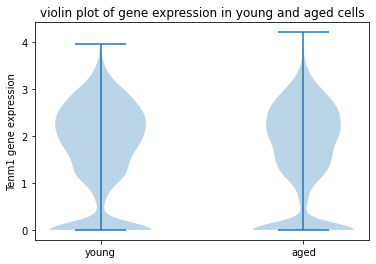

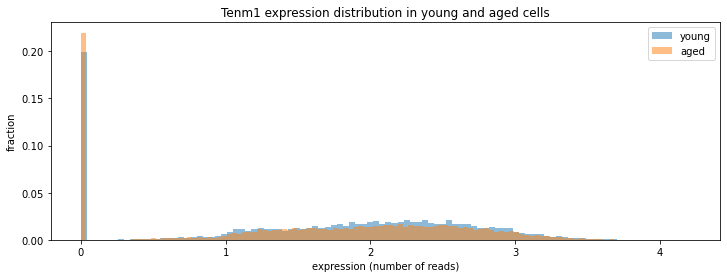

Smarca1:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.333421
std          0.525685
min          0.000000
25%          0.000000
50%          0.000000
75%          0.666989
max          3.132438
Name: Smarca1, dtype: float64


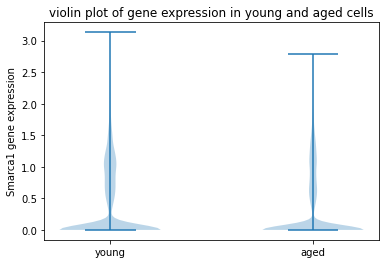

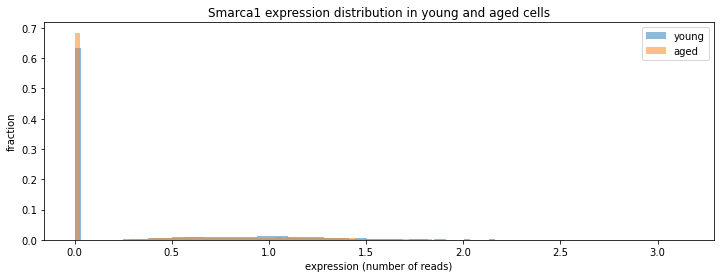

Ocrl:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.601597
std          0.671810
min          0.000000
25%          0.000000
50%          0.419651
75%          1.154900
max          3.432054
Name: Ocrl, dtype: float64


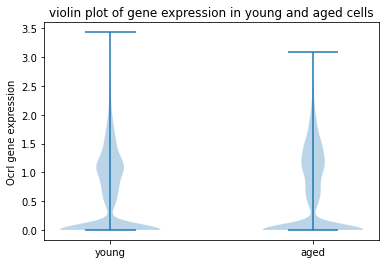

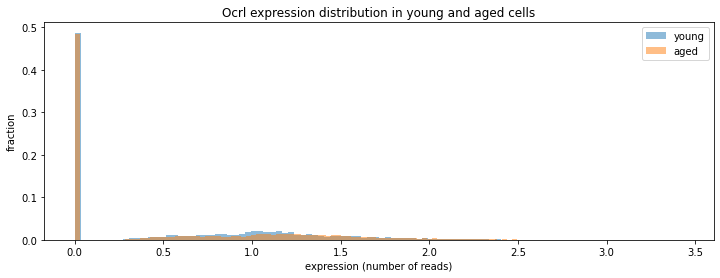

Zdhhc9:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.121582
std          0.343198
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.559245
Name: Zdhhc9, dtype: float64


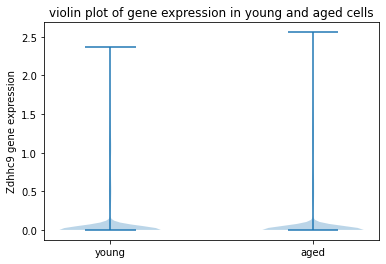

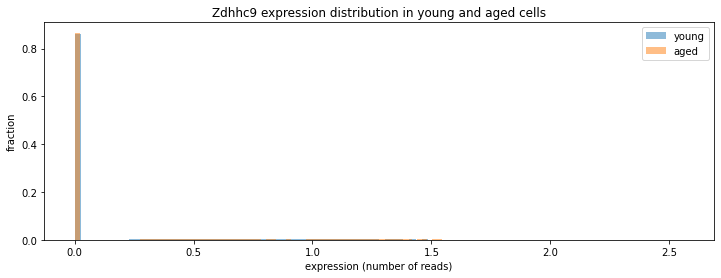

Utp14a:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.216843
std          0.444689
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          3.074208
Name: Utp14a, dtype: float64


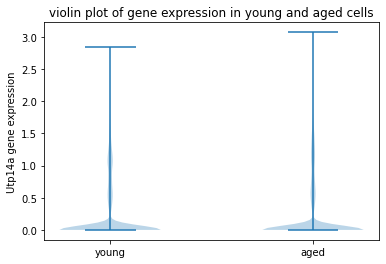

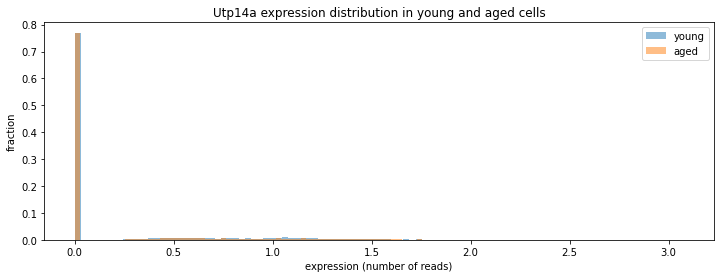

Bcorl1:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.104222
std          0.308719
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.783436
Name: Bcorl1, dtype: float64


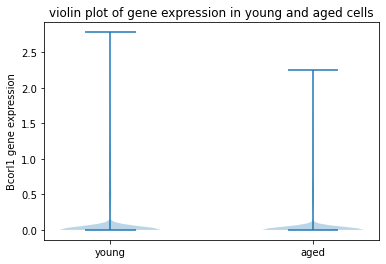

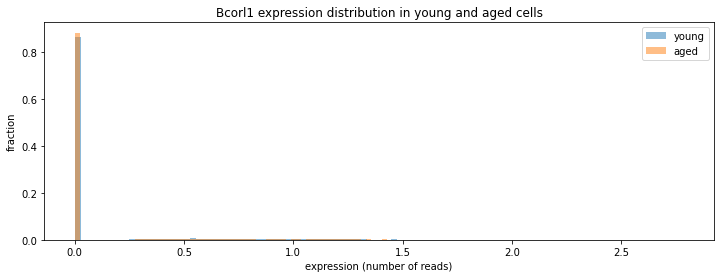

Aifm1:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.216857
std          0.438878
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.930153
Name: Aifm1, dtype: float64


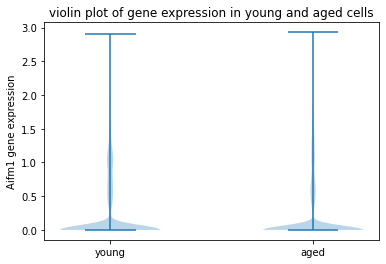

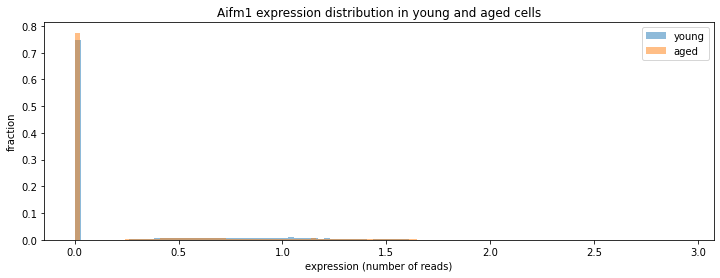

Zfp280c:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.414717
std          0.578037
min          0.000000
25%          0.000000
50%          0.000000
75%          0.860449
max          3.021020
Name: Zfp280c, dtype: float64


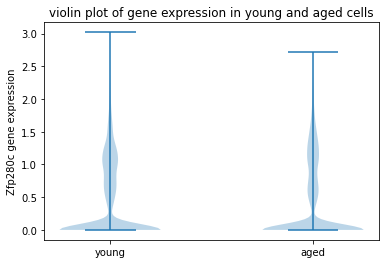

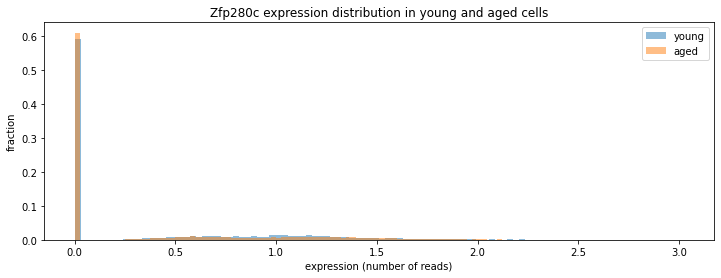

Slc25a14:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.226464
std          0.475792
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.532703
Name: Slc25a14, dtype: float64


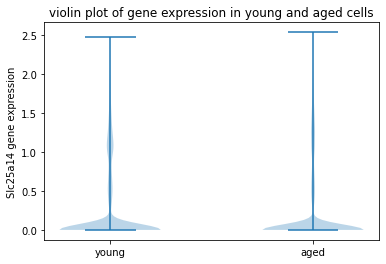

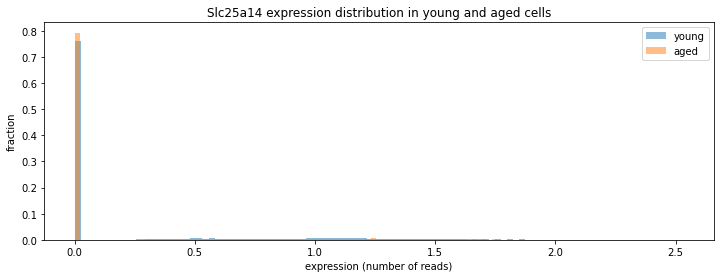

Enox2:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.256311
std          0.519953
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          3.276303
Name: Enox2, dtype: float64


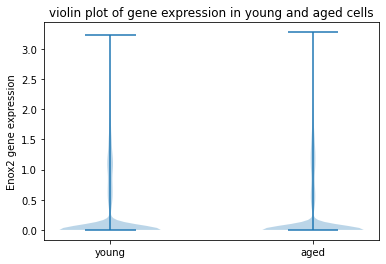

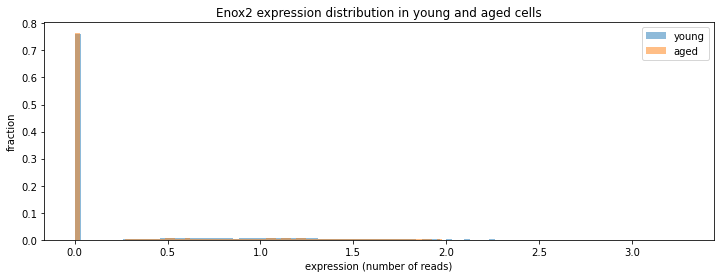

Firre:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.346570
std          0.530915
min          0.000000
25%          0.000000
50%          0.000000
75%          0.695405
max          2.889145
Name: Firre, dtype: float64


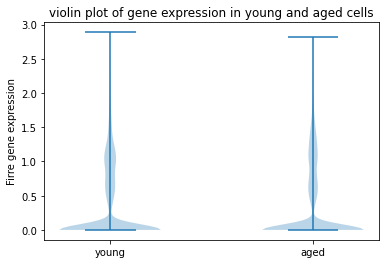

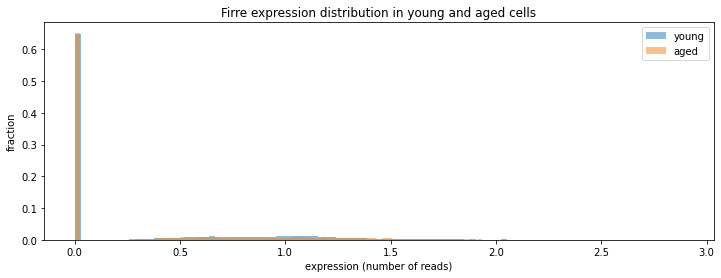

Hs6st2:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.623066
std          0.758485
min          0.000000
25%          0.000000
50%          0.000000
75%          1.254358
max          3.525924
Name: Hs6st2, dtype: float64


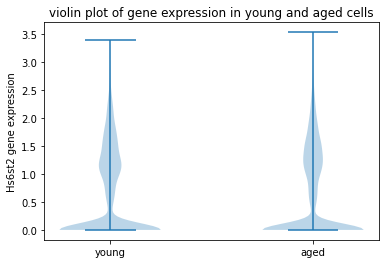

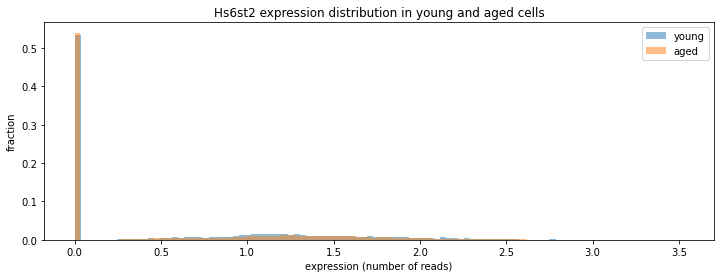

Gpc3:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.190734
std          0.490896
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          3.334212
Name: Gpc3, dtype: float64


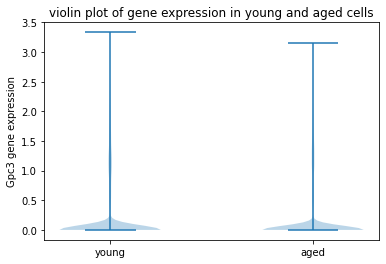

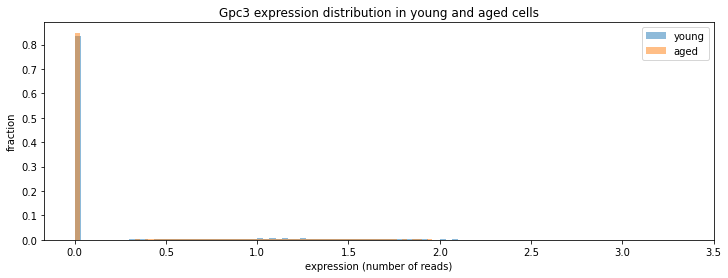

Phf6:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.395603
std          0.570245
min          0.000000
25%          0.000000
50%          0.000000
75%          0.810410
max          3.492652
Name: Phf6, dtype: float64


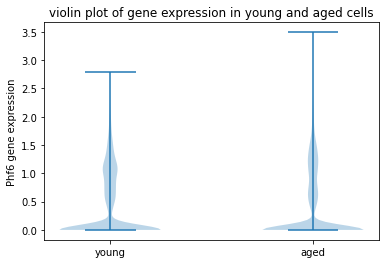

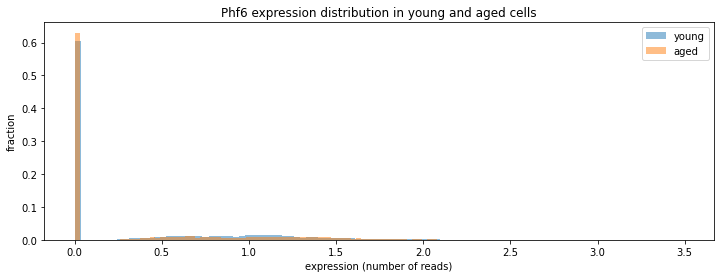

Hprt:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.340075
std          0.539246
min          0.000000
25%          0.000000
50%          0.000000
75%          0.657910
max          2.994498
Name: Hprt, dtype: float64


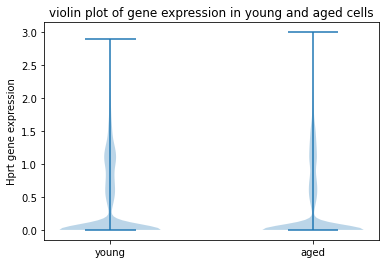

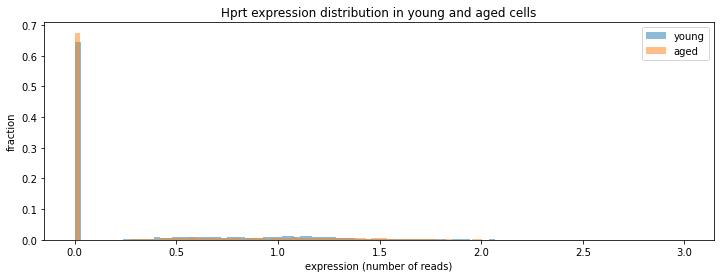

Rtl8a:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.588182
std          0.770896
min          0.000000
25%          0.000000
50%          0.000000
75%          1.255762
max          3.223054
Name: Rtl8a, dtype: float64


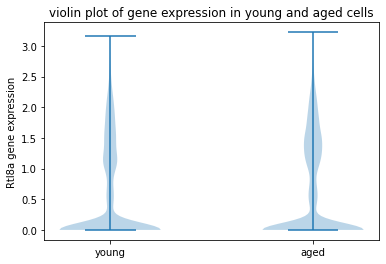

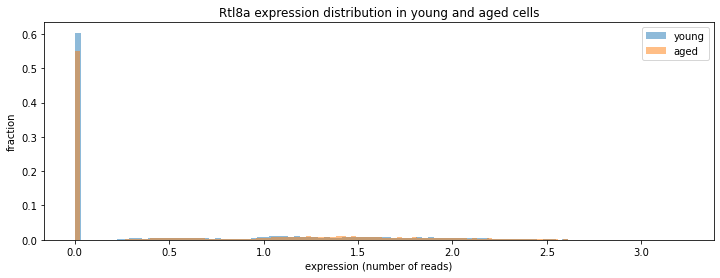

Rtl8b:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.147929
std          0.413956
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          3.319372
Name: Rtl8b, dtype: float64


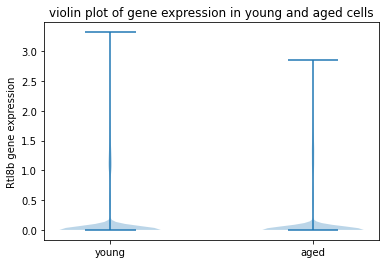

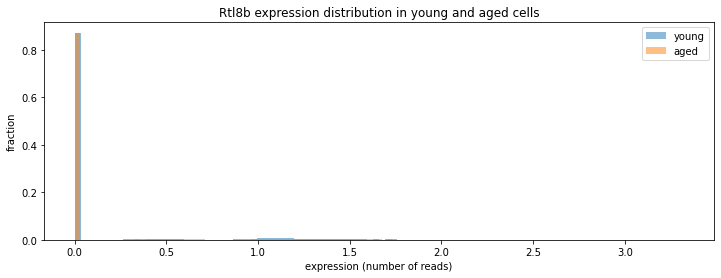

Ints6l:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.335145
std          0.539047
min          0.000000
25%          0.000000
50%          0.000000
75%          0.647755
max          3.218108
Name: Ints6l, dtype: float64


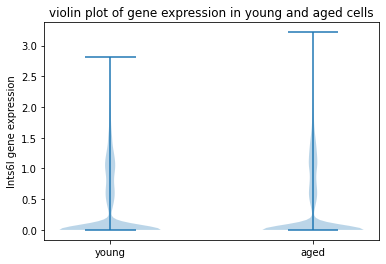

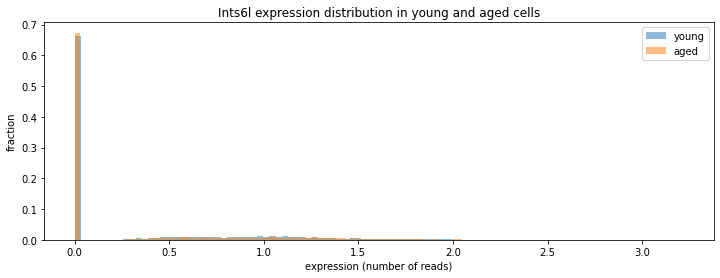

Slc9a6:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.272335
std          0.492850
min          0.000000
25%          0.000000
50%          0.000000
75%          0.454877
max          3.458995
Name: Slc9a6, dtype: float64


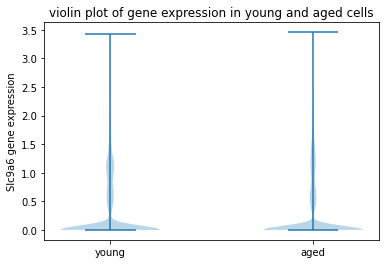

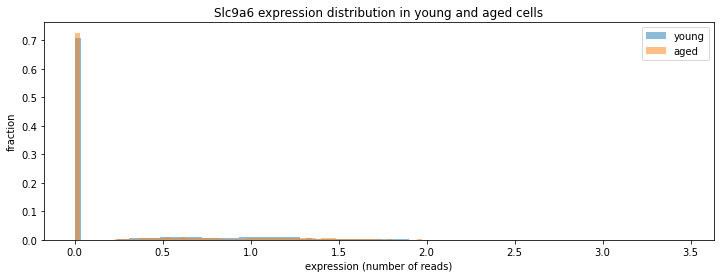

Fhl1:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.257861
std          0.469819
min          0.000000
25%          0.000000
50%          0.000000
75%          0.438168
max          2.847636
Name: Fhl1, dtype: float64


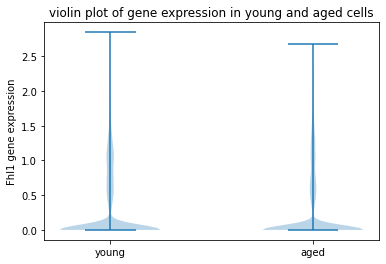

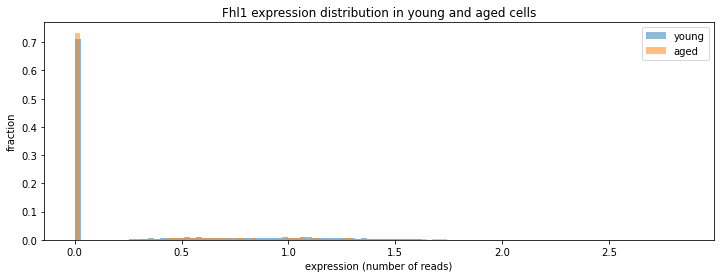

Rbmx:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.170163
std          0.387607
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.755413
Name: Rbmx, dtype: float64


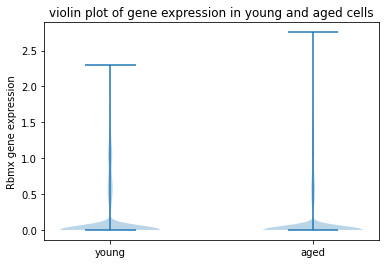

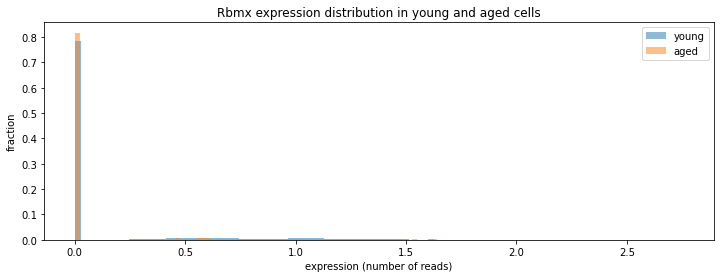

Fgf13:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.940789
std          0.974292
min          0.000000
25%          0.000000
50%          0.876275
75%          1.741643
max          4.113272
Name: Fgf13, dtype: float64


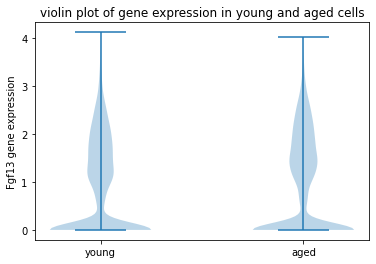

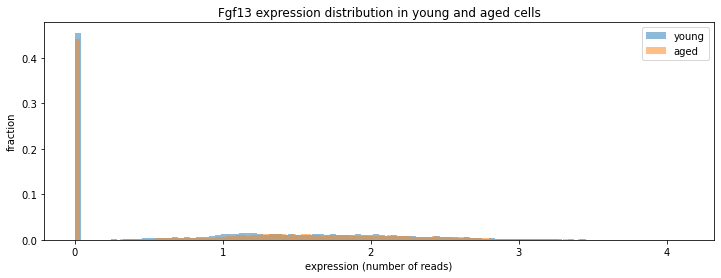

Atp11c:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.362341
std          0.568164
min          0.000000
25%          0.000000
50%          0.000000
75%          0.739907
max          3.084930
Name: Atp11c, dtype: float64


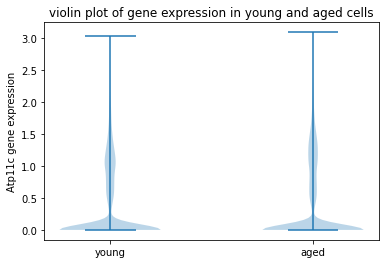

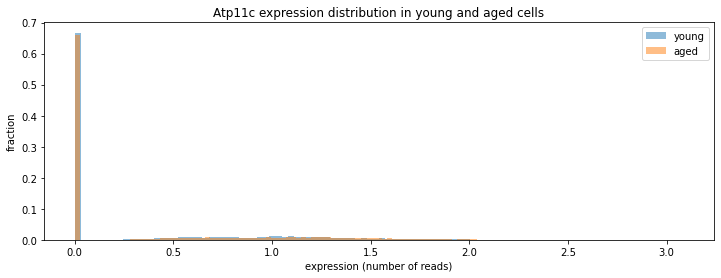

Cdr1os:
is a continuous feature, and here is the summary
count    25002.000000
mean         1.636008
std          0.824640
min          0.000000
25%          1.295080
50%          1.835570
75%          2.221286
max          3.686640
Name: Cdr1os, dtype: float64


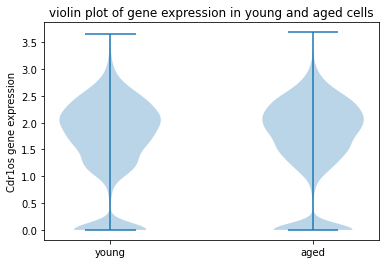

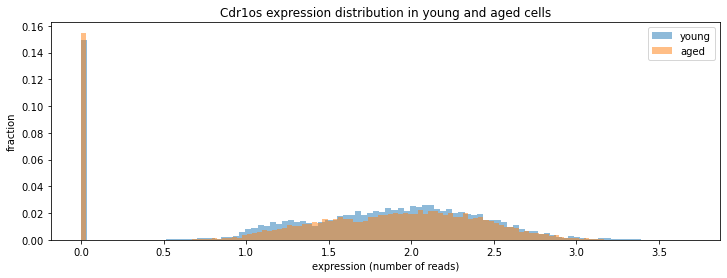

Slitrk4:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.187152
std          0.428170
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          3.348940
Name: Slitrk4, dtype: float64


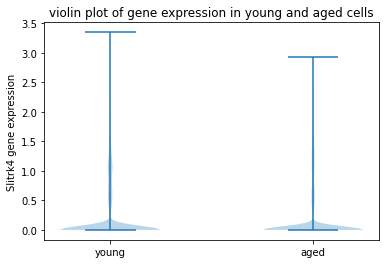

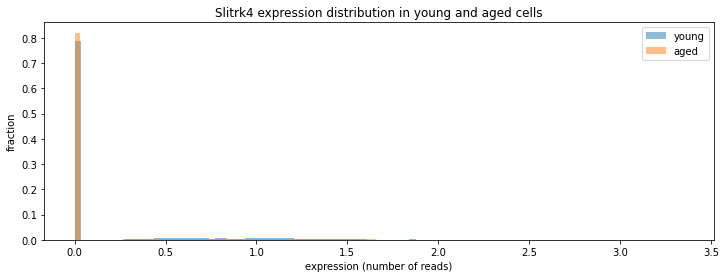

Fmr1:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.189614
std          0.402858
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.799237
Name: Fmr1, dtype: float64


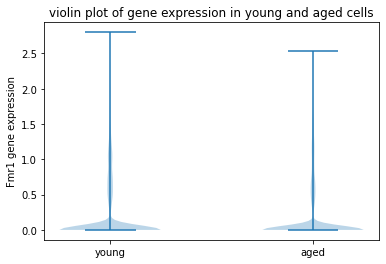

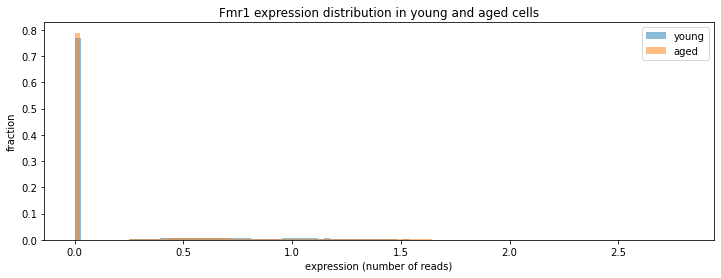

Aff2:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.806162
std          0.817701
min          0.000000
25%          0.000000
50%          0.781915
75%          1.473040
max          4.191284
Name: Aff2, dtype: float64


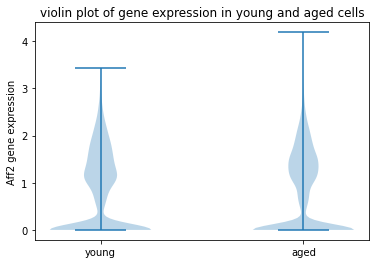

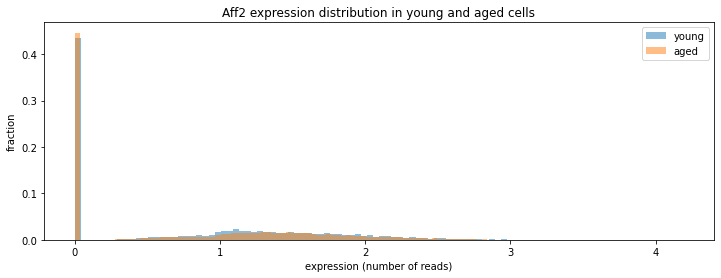

Ids:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.221240
std          0.453741
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.881164
Name: Ids, dtype: float64


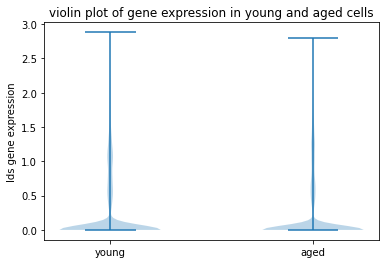

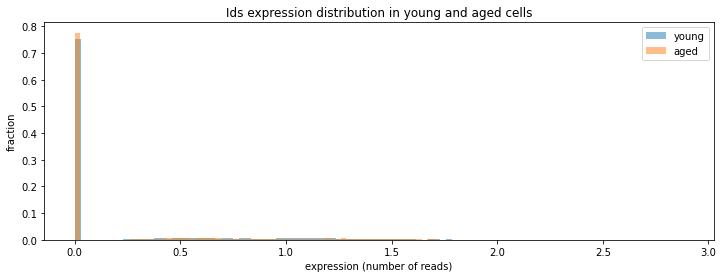

Mamld1:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.259604
std          0.490675
min          0.000000
25%          0.000000
50%          0.000000
75%          0.367346
max          3.639873
Name: Mamld1, dtype: float64


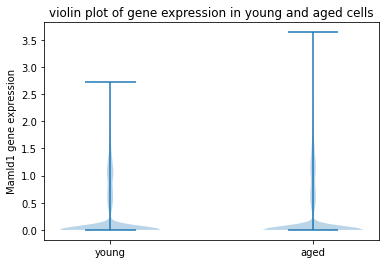

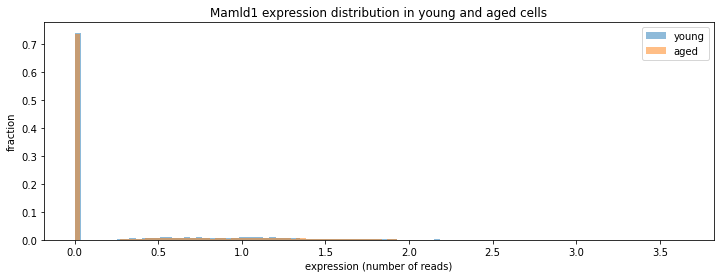

Mtm1:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.219000
std          0.435221
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.680128
Name: Mtm1, dtype: float64


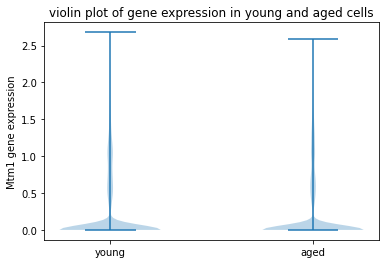

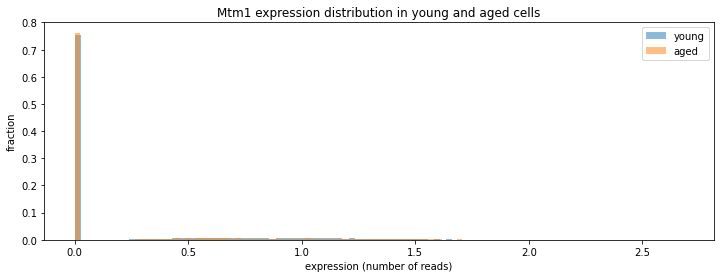

Mtmr1:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.397084
std          0.571454
min          0.000000
25%          0.000000
50%          0.000000
75%          0.813911
max          2.980192
Name: Mtmr1, dtype: float64


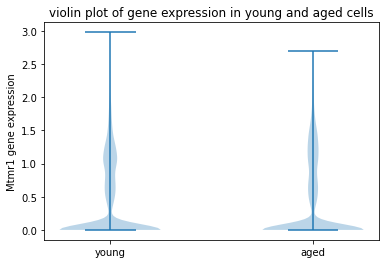

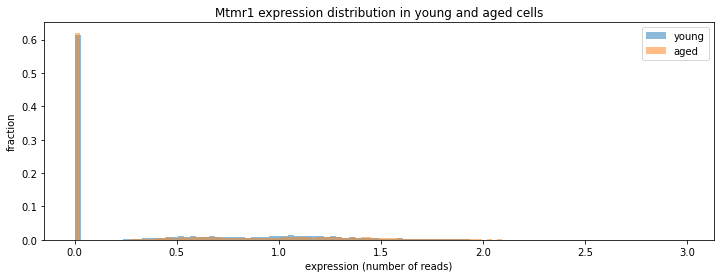

Cd99l2:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.350648
std          0.540401
min          0.000000
25%          0.000000
50%          0.000000
75%          0.695543
max          2.990900
Name: Cd99l2, dtype: float64


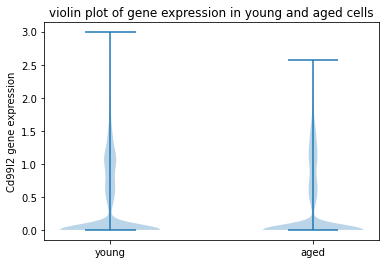

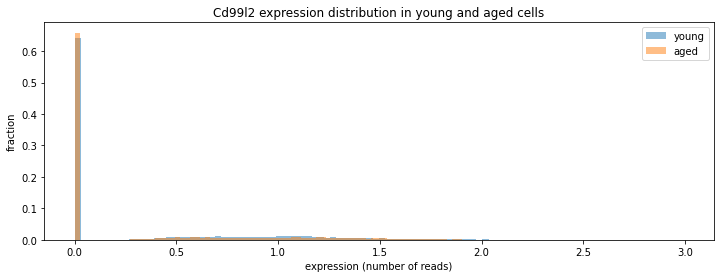

Gm16189:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.239568
std          0.477797
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          4.044578
Name: Gm16189, dtype: float64


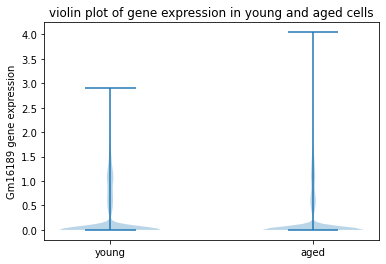

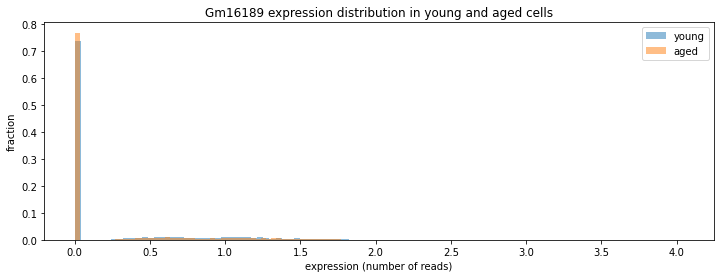

Vma21:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.140809
std          0.388684
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.921800
Name: Vma21, dtype: float64


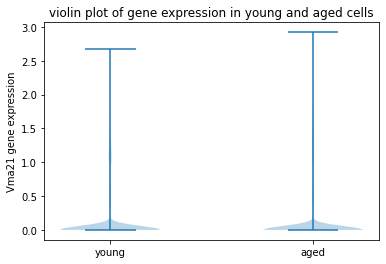

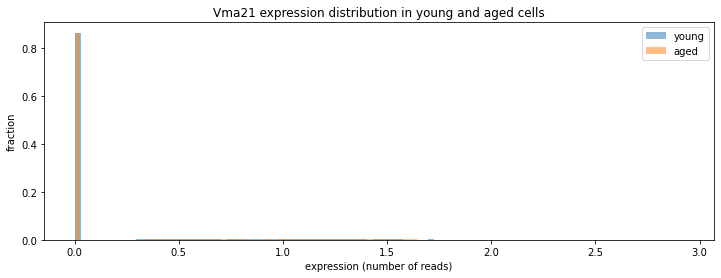

Gabra3:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.602015
std          0.688419
min          0.000000
25%          0.000000
50%          0.000000
75%          1.190526
max          3.206669
Name: Gabra3, dtype: float64


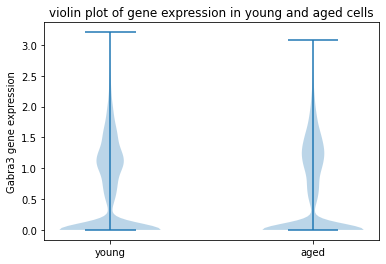

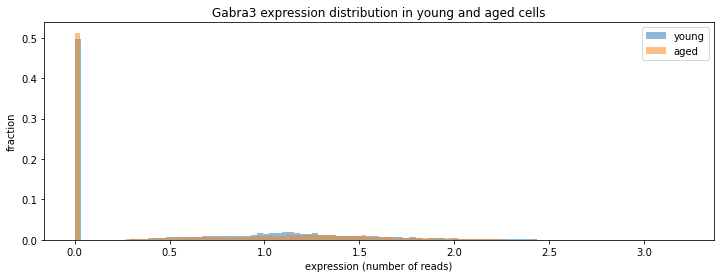

Nsdhl:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.100700
std          0.303817
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.889145
Name: Nsdhl, dtype: float64


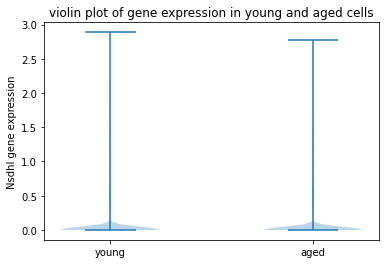

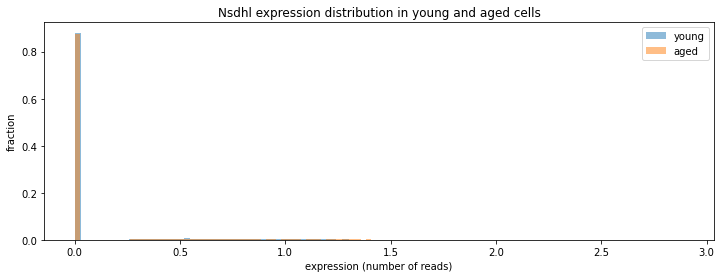

Pnma3:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.195128
std          0.423845
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.781303
Name: Pnma3, dtype: float64


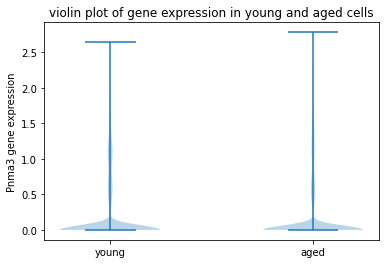

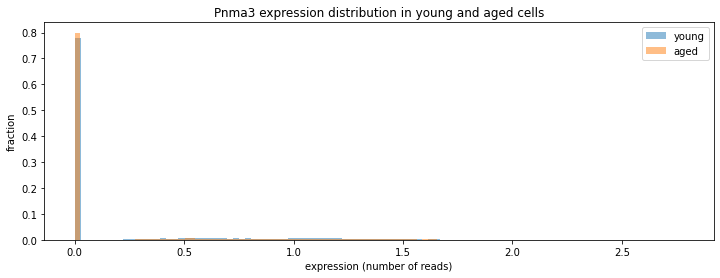

Atp2b3:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.423879
std          0.587360
min          0.000000
25%          0.000000
50%          0.000000
75%          0.897263
max          2.893968
Name: Atp2b3, dtype: float64


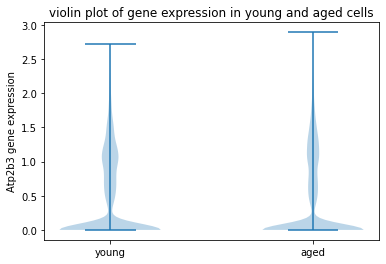

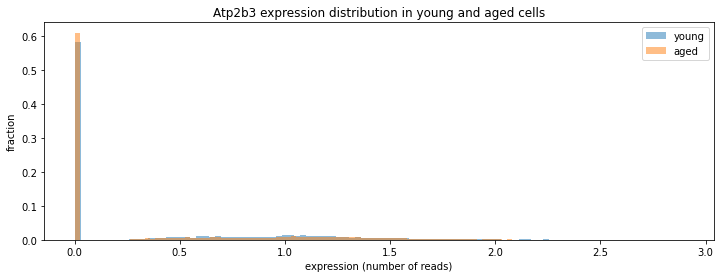

Pnck:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.339207
std          0.556828
min          0.000000
25%          0.000000
50%          0.000000
75%          0.628520
max          3.577462
Name: Pnck, dtype: float64


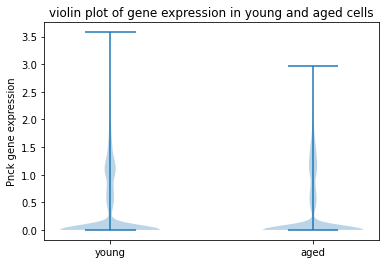

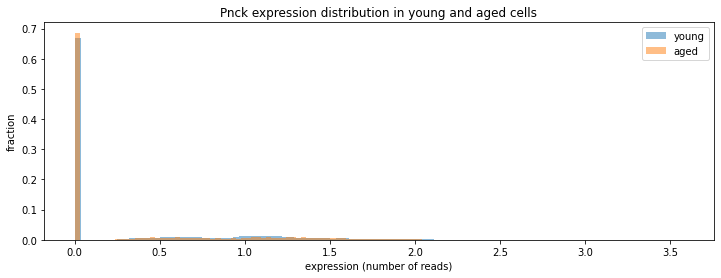

Bcap31:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.323577
std          0.550499
min          0.000000
25%          0.000000
50%          0.000000
75%          0.567320
max          2.881164
Name: Bcap31, dtype: float64


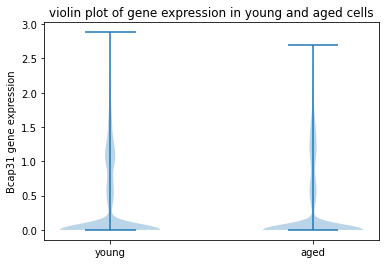

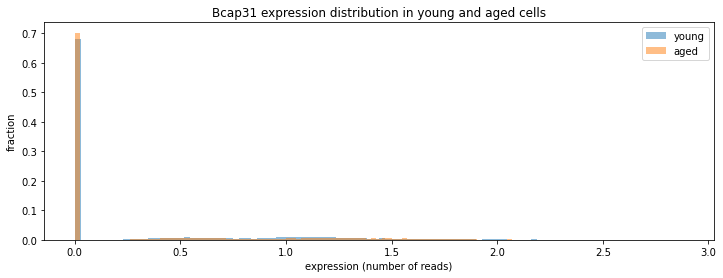

Idh3g:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.264962
std          0.505570
min          0.000000
25%          0.000000
50%          0.000000
75%          0.317043
max          3.049297
Name: Idh3g, dtype: float64


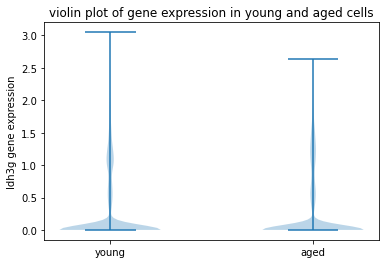

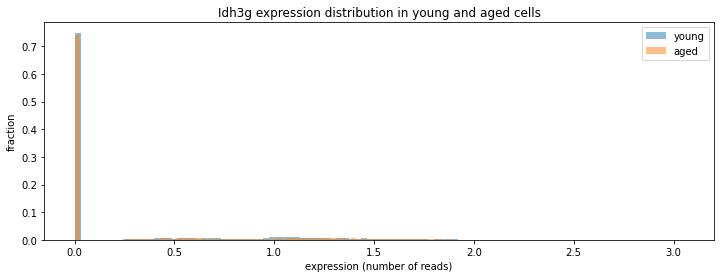

Ssr4:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.489789
std          0.659417
min          0.000000
25%          0.000000
50%          0.000000
75%          1.048540
max          2.908595
Name: Ssr4, dtype: float64


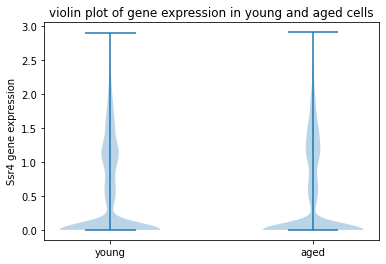

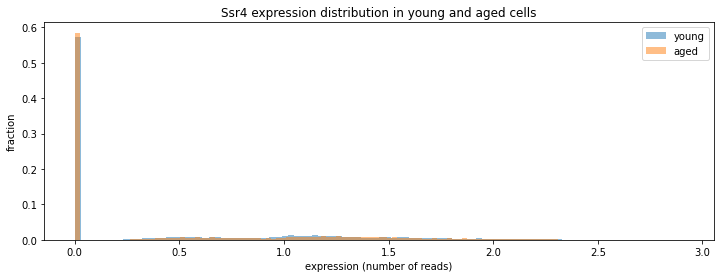

Pdzd4:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.746054
std          0.704057
min          0.000000
25%          0.000000
50%          0.806408
75%          1.312228
max          4.144163
Name: Pdzd4, dtype: float64


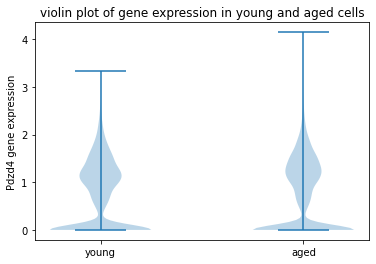

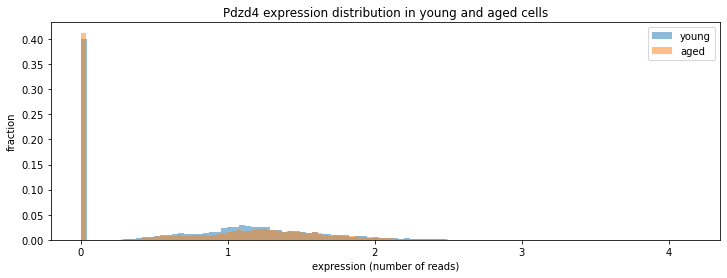

L1cam:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.288454
std          0.491853
min          0.000000
25%          0.000000
50%          0.000000
75%          0.538565
max          3.096788
Name: L1cam, dtype: float64


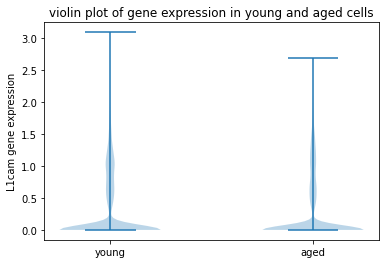

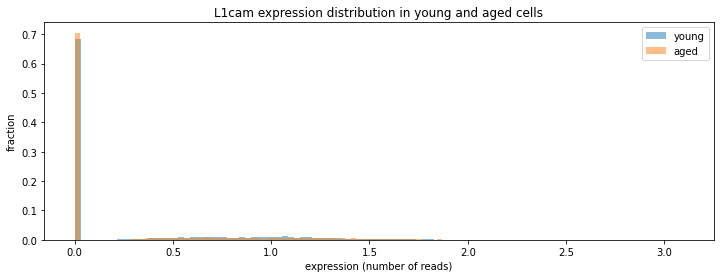

Irak1:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.187012
std          0.418908
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.889145
Name: Irak1, dtype: float64


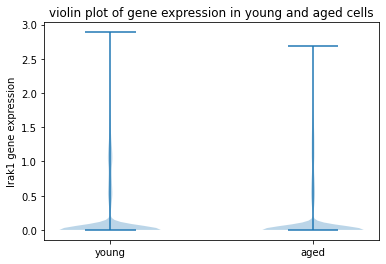

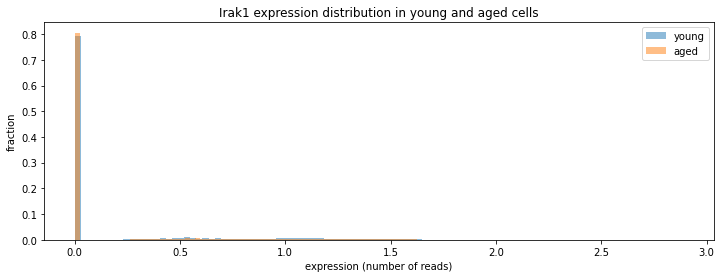

Mecp2:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.499469
std          0.617849
min          0.000000
25%          0.000000
50%          0.000000
75%          1.038326
max          3.421490
Name: Mecp2, dtype: float64


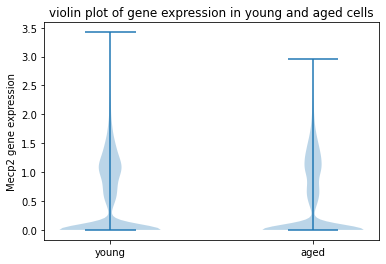

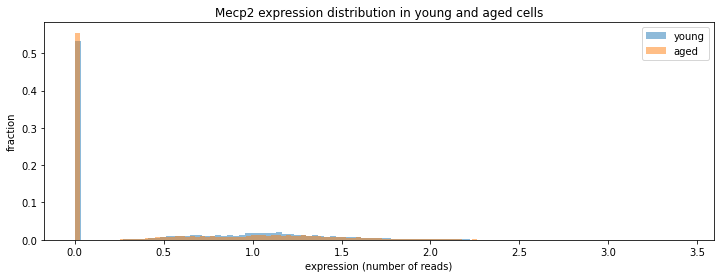

Rpl10:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.505898
std          0.691314
min          0.000000
25%          0.000000
50%          0.000000
75%          1.098679
max          3.255696
Name: Rpl10, dtype: float64


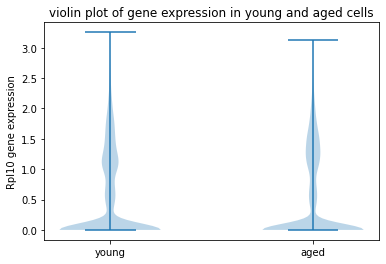

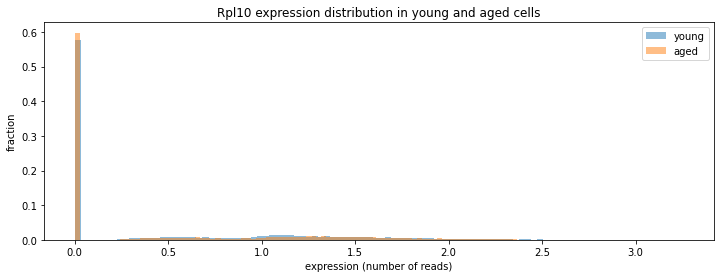

Taz:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.488090
std          0.632300
min          0.000000
25%          0.000000
50%          0.000000
75%          1.027864
max          3.072569
Name: Taz, dtype: float64


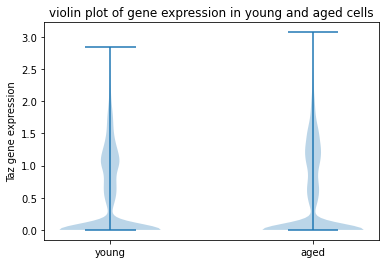

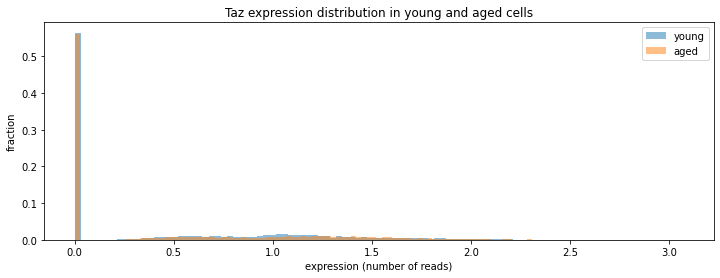

Atp6ap1:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.513483
std          0.655878
min          0.000000
25%          0.000000
50%          0.000000
75%          1.062916
max          2.885944
Name: Atp6ap1, dtype: float64


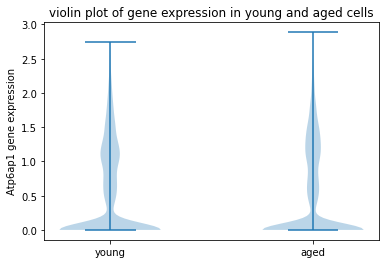

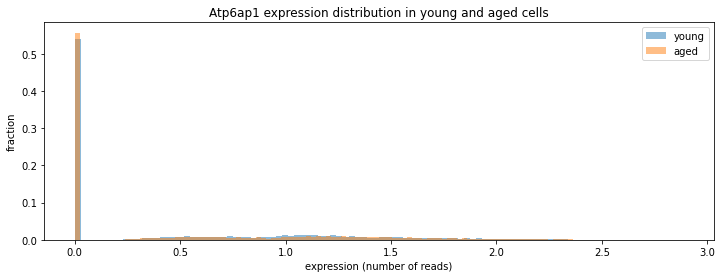

Gdi1:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.335214
std          0.547174
min          0.000000
25%          0.000000
50%          0.000000
75%          0.617664
max          3.079471
Name: Gdi1, dtype: float64


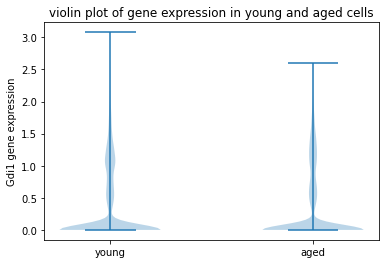

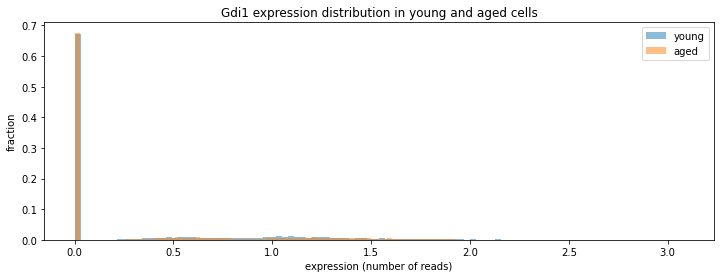

Fam50a:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.128502
std          0.353741
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.870109
Name: Fam50a, dtype: float64


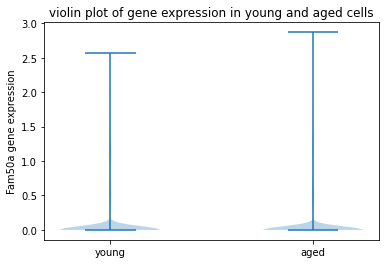

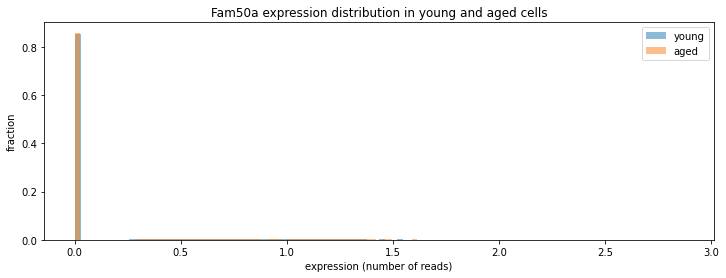

Lage3:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.279421
std          0.517128
min          0.000000
25%          0.000000
50%          0.000000
75%          0.415678
max          2.930153
Name: Lage3, dtype: float64


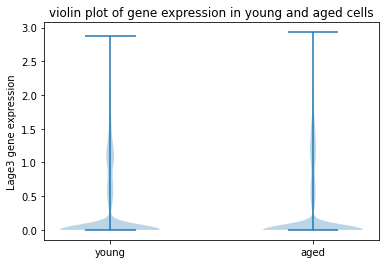

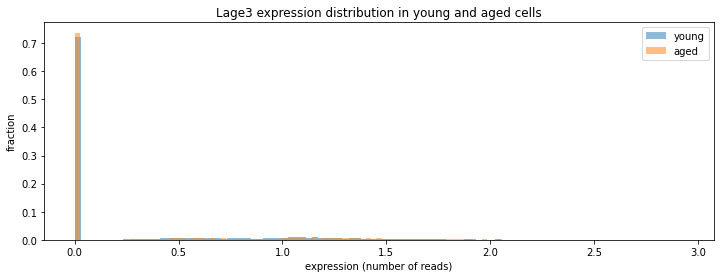

Ikbkg:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.135136
std          0.362591
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.569763
Name: Ikbkg, dtype: float64


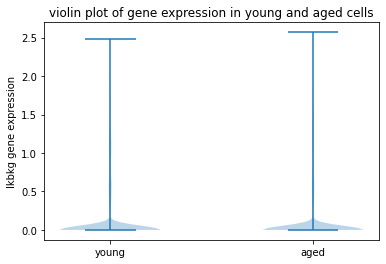

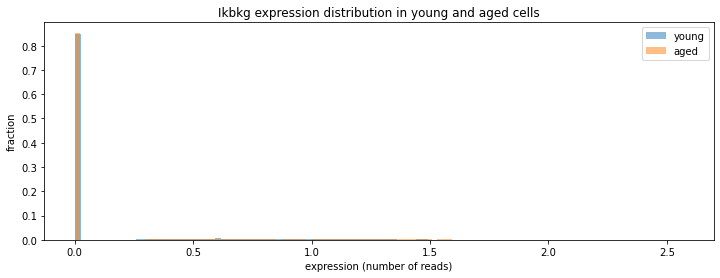

Gab3:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.201070
std          0.445812
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.671940
Name: Gab3, dtype: float64


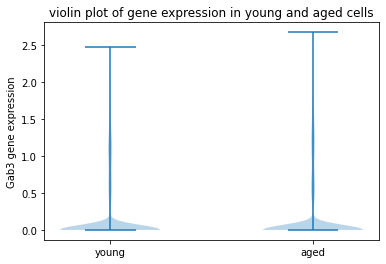

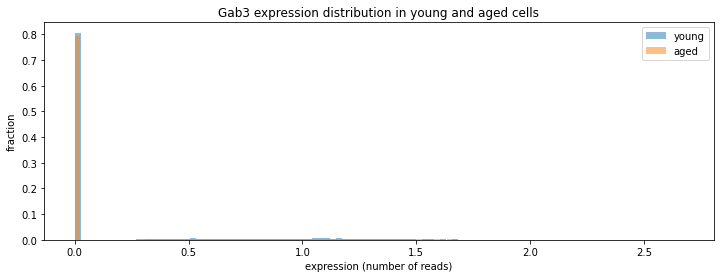

Mpp1:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.108888
std          0.322333
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.564211
Name: Mpp1, dtype: float64


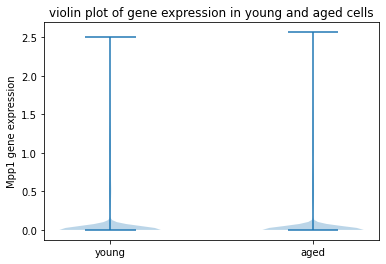

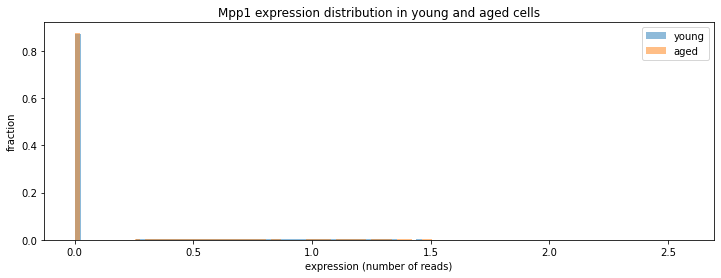

Brcc3:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.155083
std          0.370331
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.532703
Name: Brcc3, dtype: float64


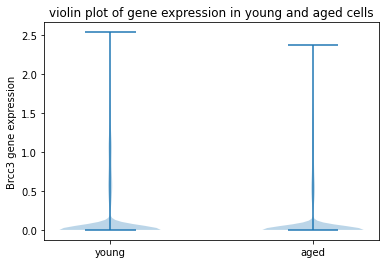

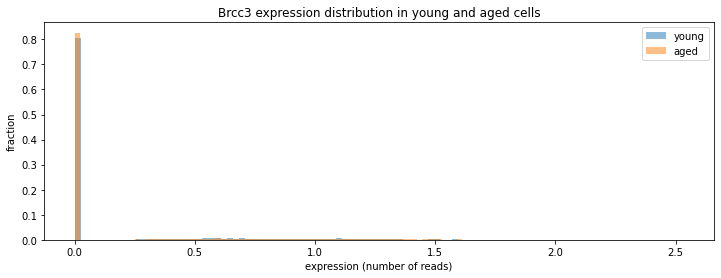

Vbp1:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.245291
std          0.470137
min          0.000000
25%          0.000000
50%          0.000000
75%          0.319927
max          2.847636
Name: Vbp1, dtype: float64


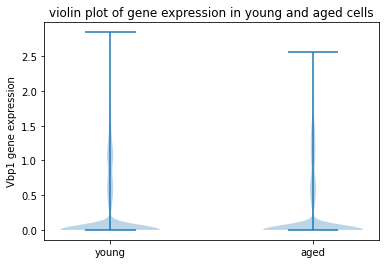

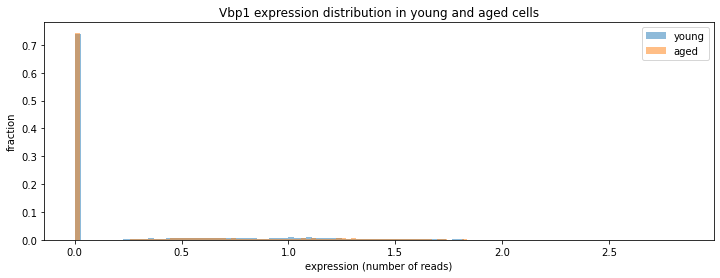

Pls3:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.282174
std          0.521233
min          0.000000
25%          0.000000
50%          0.000000
75%          0.430245
max          3.027539
Name: Pls3, dtype: float64


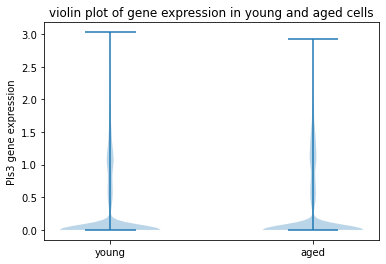

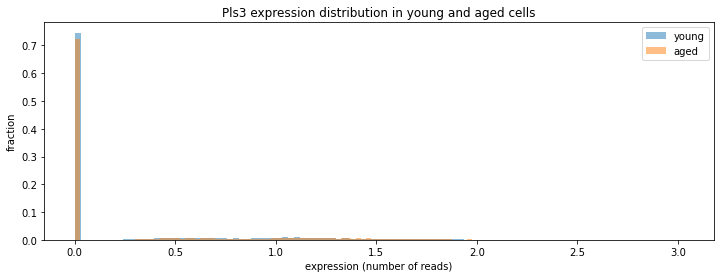

Tbl1x:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.568630
std          0.660820
min          0.000000
25%          0.000000
50%          0.000000
75%          1.135818
max          3.528061
Name: Tbl1x, dtype: float64


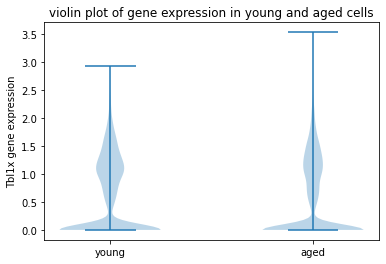

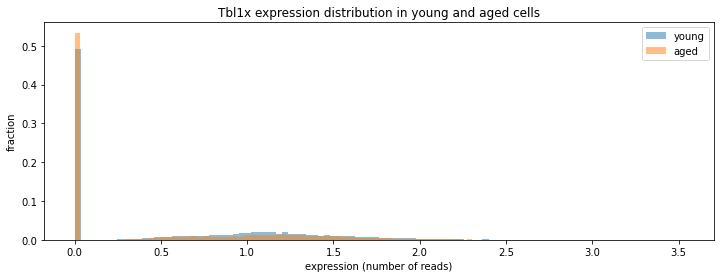

Tmem47:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.244935
std          0.487853
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          3.348498
Name: Tmem47, dtype: float64


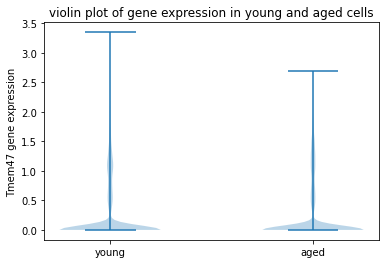

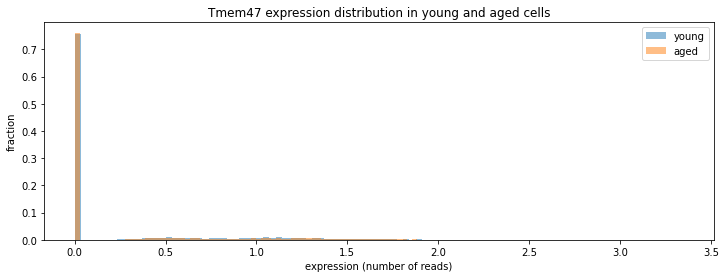

Dmd:
is a continuous feature, and here is the summary
count    25002.000000
mean         1.958302
std          0.962297
min          0.000000
25%          1.499083
50%          2.167594
75%          2.640695
max          4.726120
Name: Dmd, dtype: float64


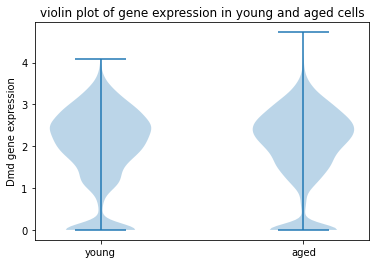

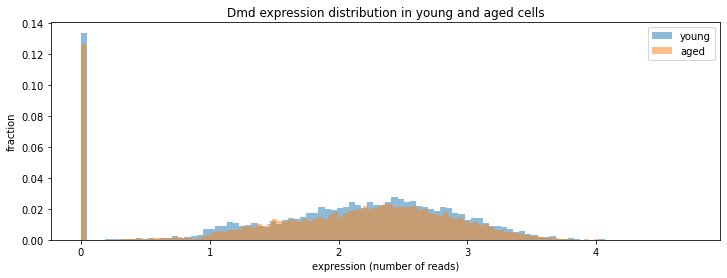

Tab3:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.107392
std          0.302033
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.644180
Name: Tab3, dtype: float64


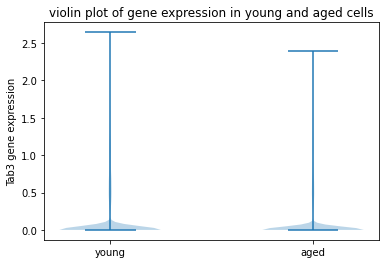

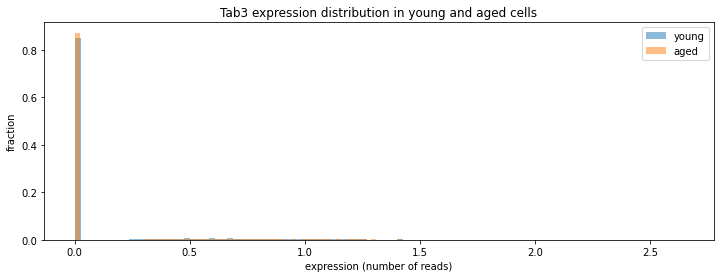

Gk:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.199734
std          0.424005
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.644180
Name: Gk, dtype: float64


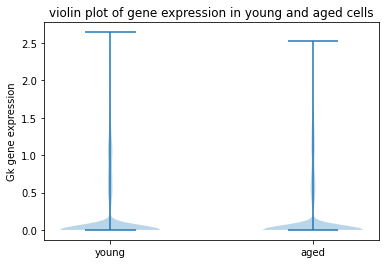

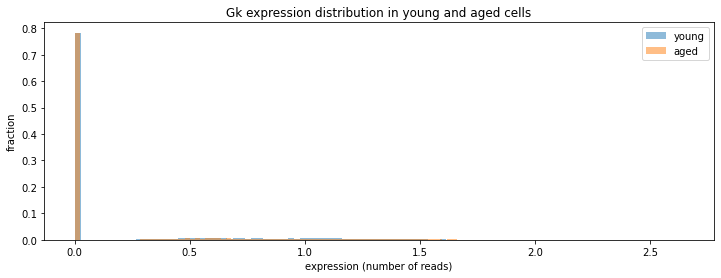

Il1rapl1:
is a continuous feature, and here is the summary
count    25002.000000
mean         2.812001
std          0.953294
min          0.000000
25%          2.425177
50%          3.012336
75%          3.442949
max          5.466440
Name: Il1rapl1, dtype: float64


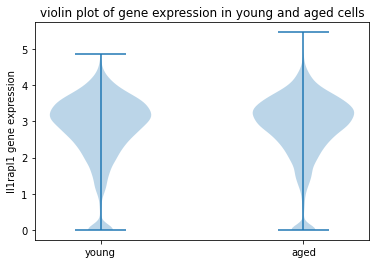

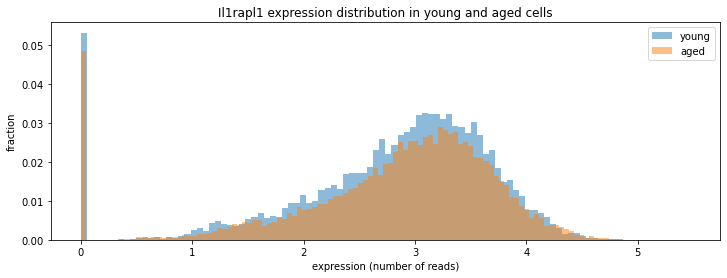

Pola1:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.234732
std          0.458288
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.682663
Name: Pola1, dtype: float64


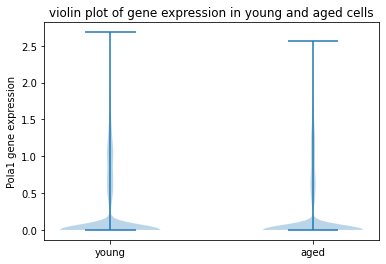

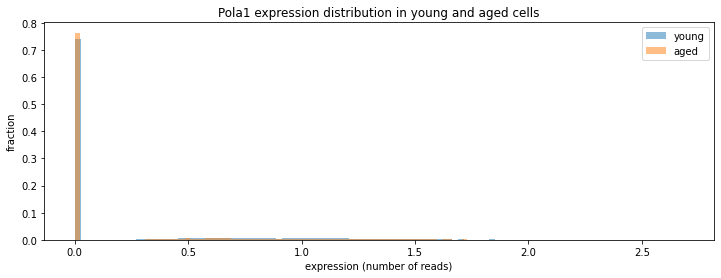

Pcyt1b:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.158581
std          0.384359
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.990900
Name: Pcyt1b, dtype: float64


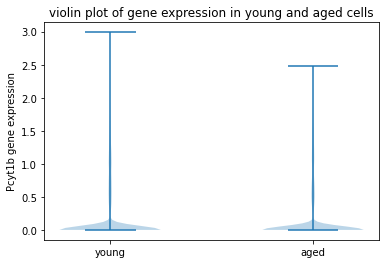

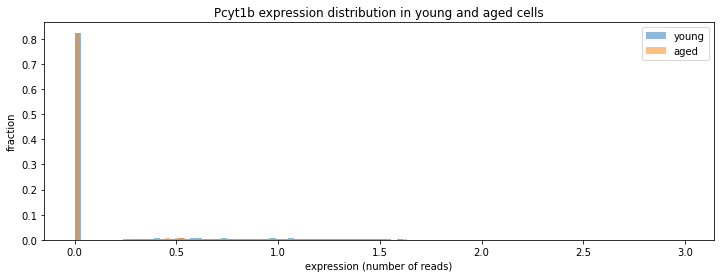

Pdk3:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.118005
std          0.336320
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.821247
Name: Pdk3, dtype: float64


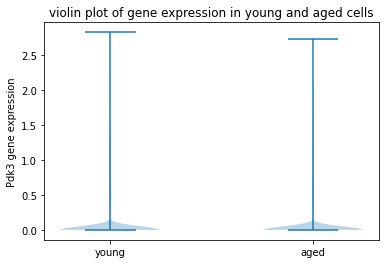

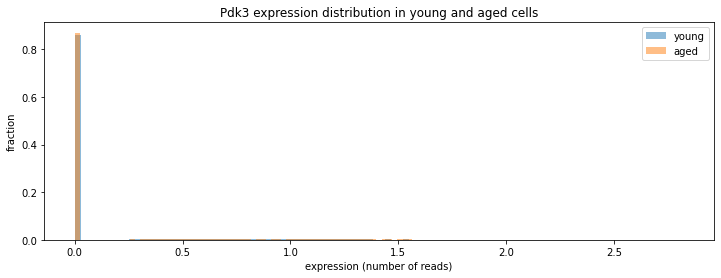

Zfx:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.190752
std          0.414848
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.886477
Name: Zfx, dtype: float64


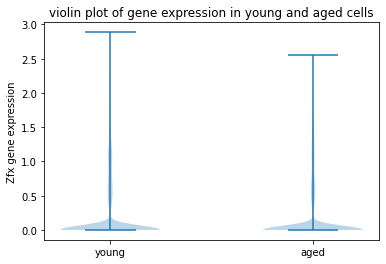

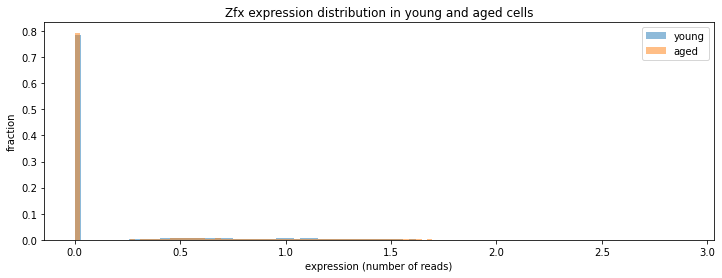

Eif2s3x:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.160695
std          0.392086
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          3.301148
Name: Eif2s3x, dtype: float64


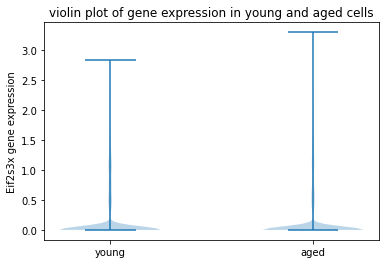

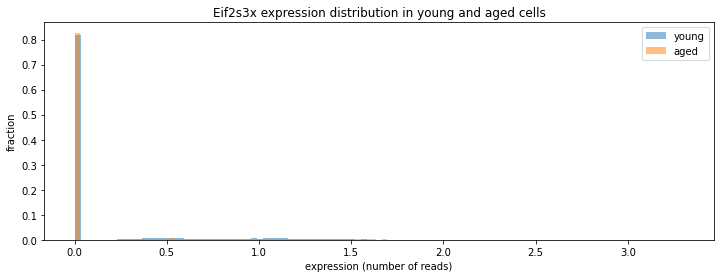

Klhl15:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.232801
std          0.455470
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.921800
Name: Klhl15, dtype: float64


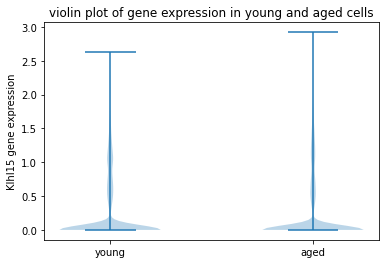

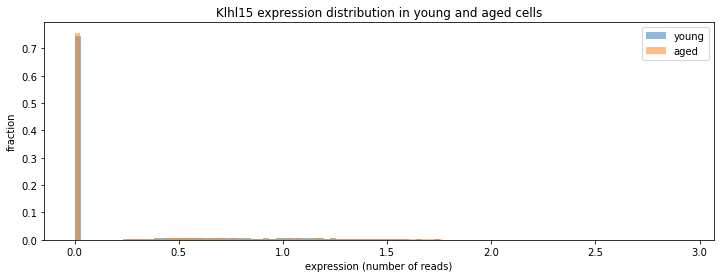

Apoo:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.293702
std          0.499554
min          0.000000
25%          0.000000
50%          0.000000
75%          0.544682
max          2.962621
Name: Apoo, dtype: float64


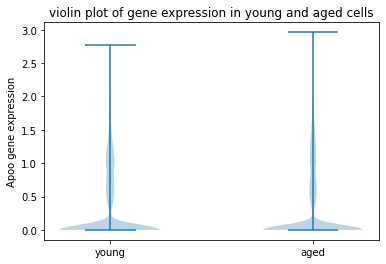

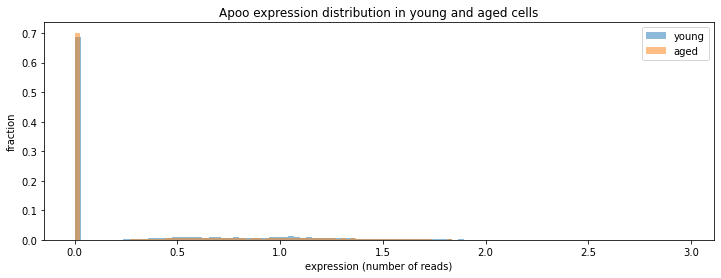

Gm14827:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.153933
std          0.365901
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.481978
Name: Gm14827, dtype: float64


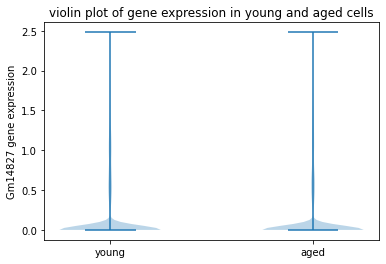

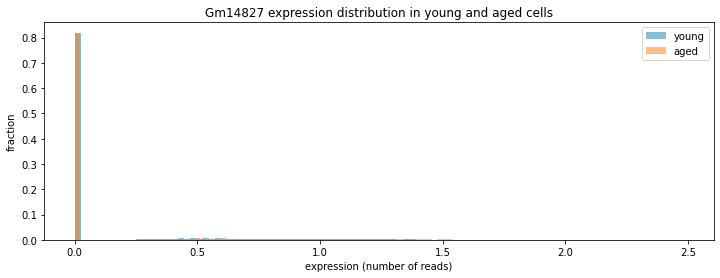

Maged1:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.776564
std          0.733993
min          0.000000
25%          0.000000
50%          0.774696
75%          1.347182
max          3.577462
Name: Maged1, dtype: float64


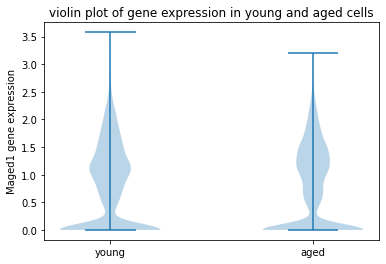

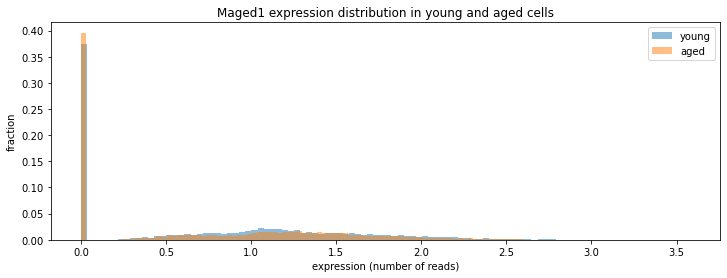

Gspt2:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.108297
std          0.304549
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.544518
Name: Gspt2, dtype: float64


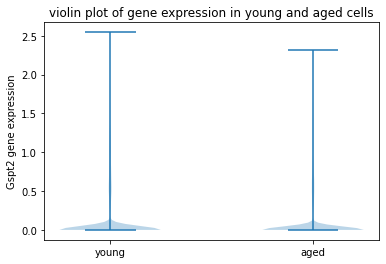

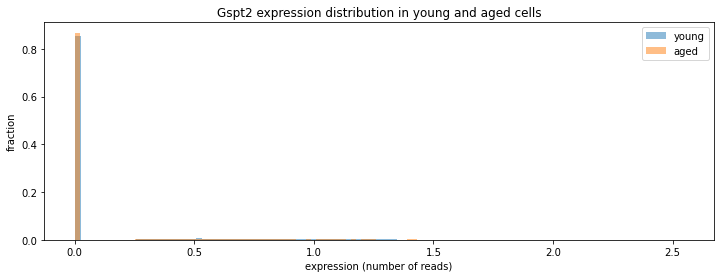

Arhgef9:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.638844
std          0.678824
min          0.000000
25%          0.000000
50%          0.555037
75%          1.209054
max          3.346293
Name: Arhgef9, dtype: float64


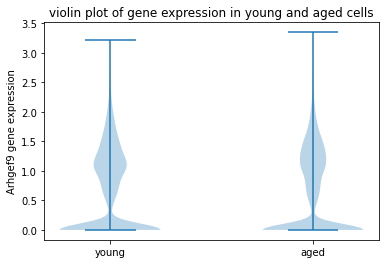

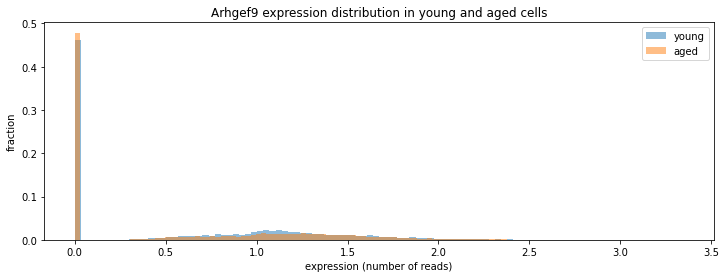

Zc3h12b:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.523745
std          0.641488
min          0.000000
25%          0.000000
50%          0.000000
75%          1.084741
max          3.574087
Name: Zc3h12b, dtype: float64


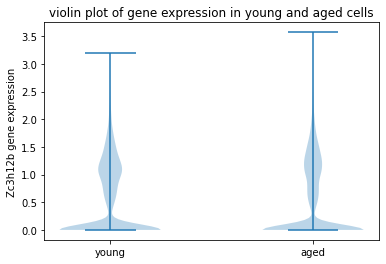

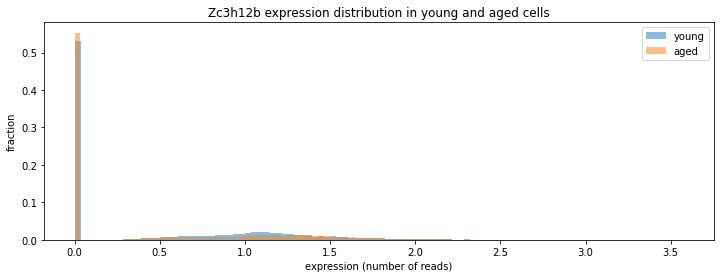

Las1l:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.407523
std          0.577340
min          0.000000
25%          0.000000
50%          0.000000
75%          0.845616
max          3.147239
Name: Las1l, dtype: float64


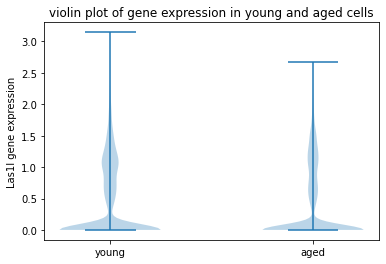

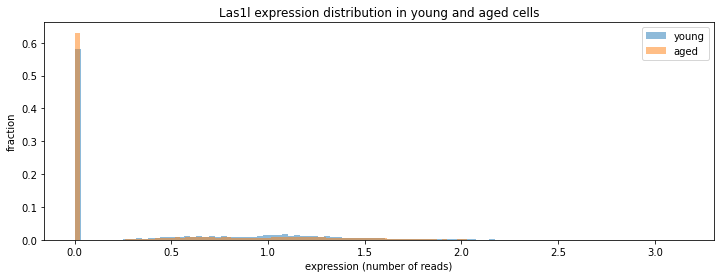

Ar:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.333122
std          0.573985
min          0.000000
25%          0.000000
50%          0.000000
75%          0.599507
max          3.033479
Name: Ar, dtype: float64


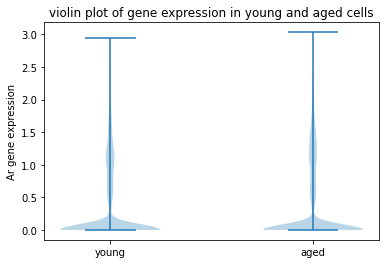

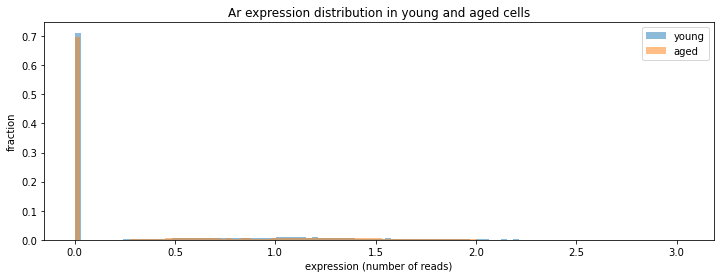

Ophn1:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.473823
std          0.609298
min          0.000000
25%          0.000000
50%          0.000000
75%          1.002671
max          2.966982
Name: Ophn1, dtype: float64


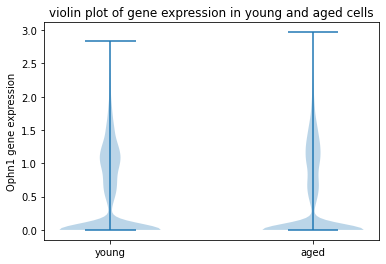

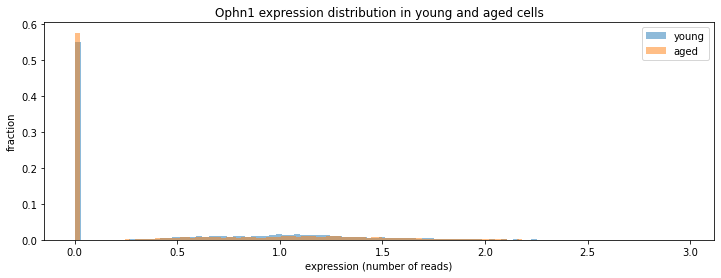

Pja1:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.137668
std          0.366034
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          3.070607
Name: Pja1, dtype: float64


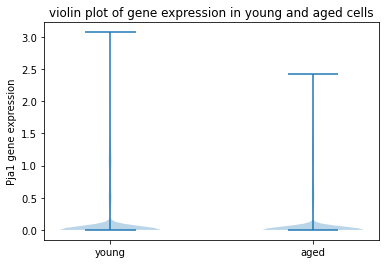

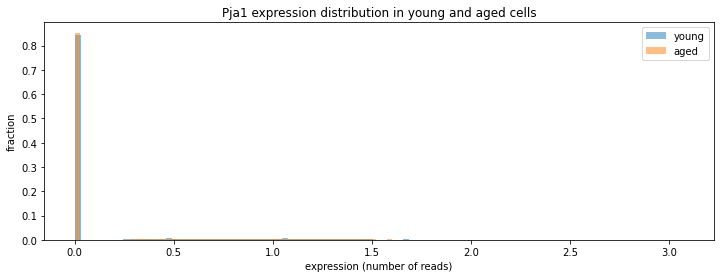

Eda:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.394362
std          0.664748
min          0.000000
25%          0.000000
50%          0.000000
75%          0.764425
max          3.849841
Name: Eda, dtype: float64


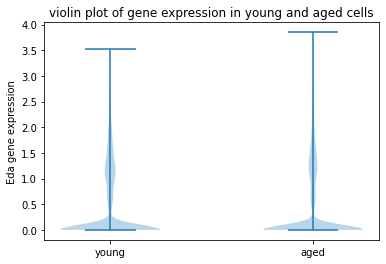

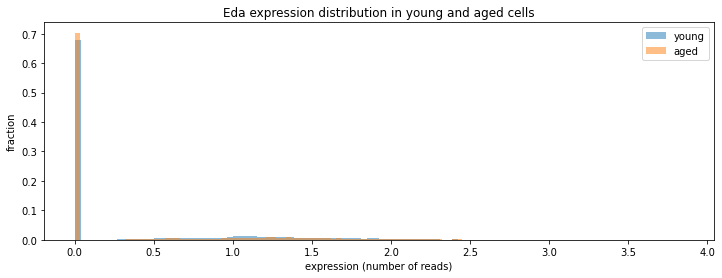

Dlg3:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.133013
std          0.335510
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.973122
Name: Dlg3, dtype: float64


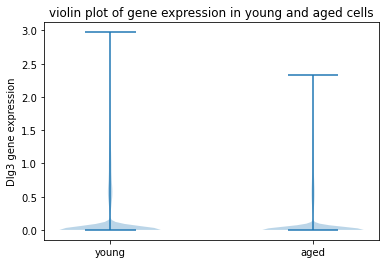

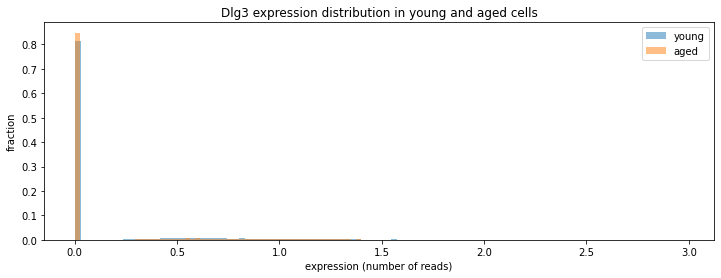

Snx12:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.280739
std          0.501167
min          0.000000
25%          0.000000
50%          0.000000
75%          0.485953
max          3.323662
Name: Snx12, dtype: float64


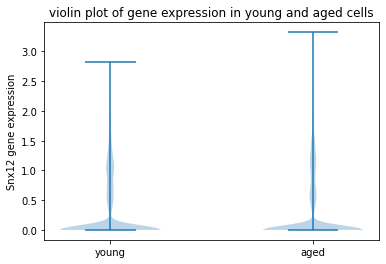

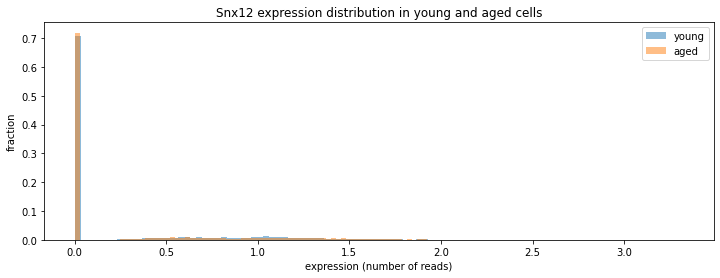

Nlgn3:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.271656
std          0.486991
min          0.000000
25%          0.000000
50%          0.000000
75%          0.466823
max          2.821247
Name: Nlgn3, dtype: float64


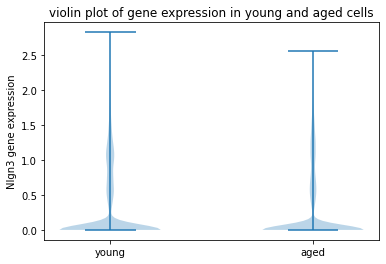

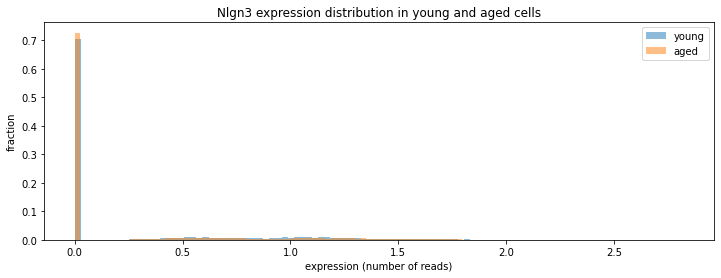

Zmym3:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.206841
std          0.419839
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.907776
Name: Zmym3, dtype: float64


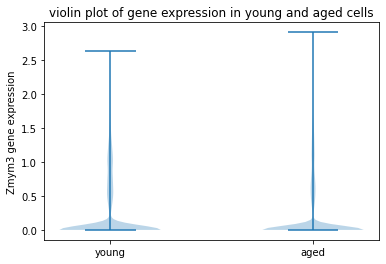

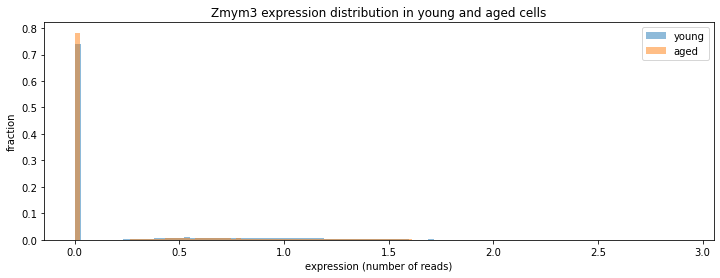

Nono:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.233276
std          0.455457
min          0.000000
25%          0.000000
50%          0.000000
75%          0.243770
max          2.789149
Name: Nono, dtype: float64


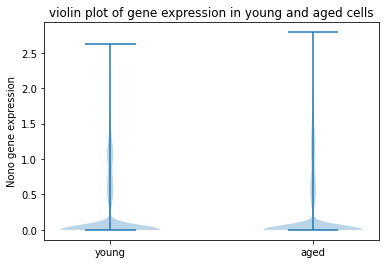

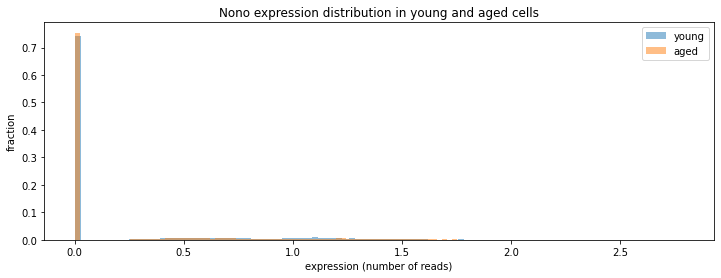

Taf1:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.425067
std          0.581177
min          0.000000
25%          0.000000
50%          0.000000
75%          0.893910
max          2.943681
Name: Taf1, dtype: float64


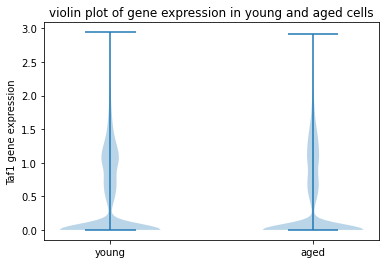

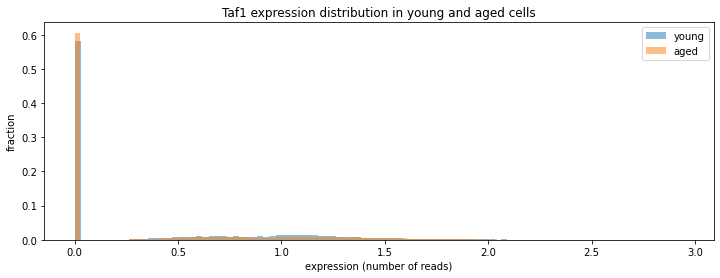

Ogt:
is a continuous feature, and here is the summary
count    25002.000000
mean         1.327545
std          0.775190
min          0.000000
25%          0.955920
50%          1.443739
75%          1.870927
max          4.019884
Name: Ogt, dtype: float64


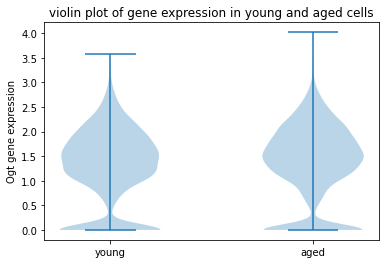

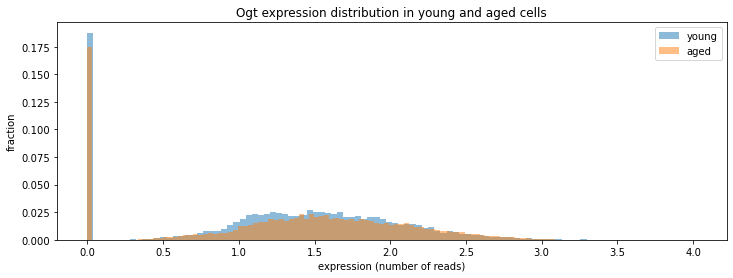

Nhsl2:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.347845
std          0.546762
min          0.000000
25%          0.000000
50%          0.000000
75%          0.702842
max          2.930153
Name: Nhsl2, dtype: float64


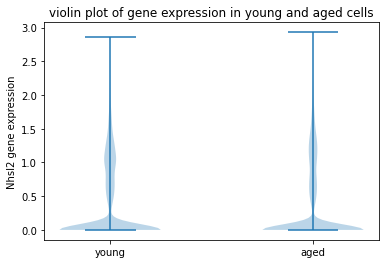

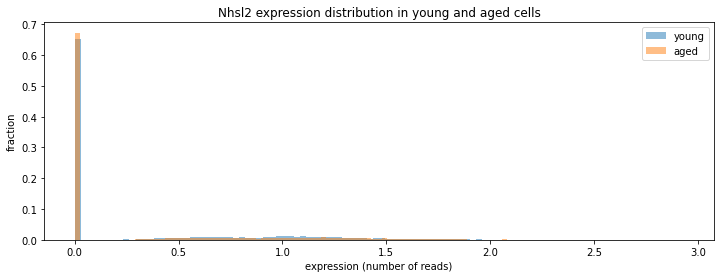

Rtl5:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.134079
std          0.363517
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.787241
Name: Rtl5, dtype: float64


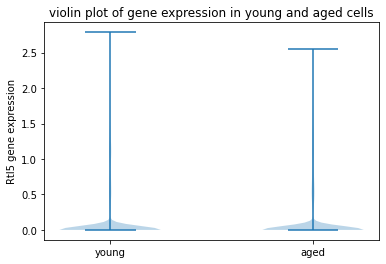

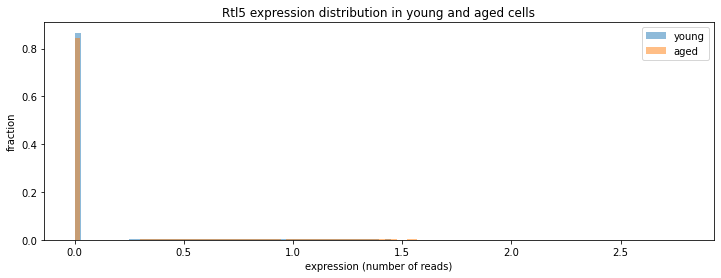

Rps4x:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.364557
std          0.616446
min          0.000000
25%          0.000000
50%          0.000000
75%          0.668435
max          3.395127
Name: Rps4x, dtype: float64


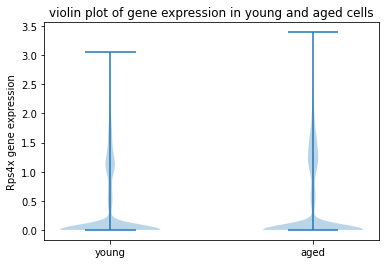

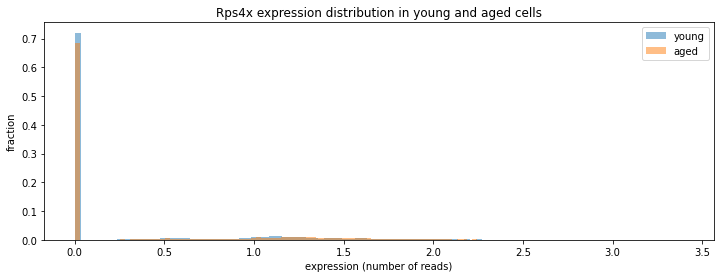

Gm14858:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.178771
std          0.392901
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          3.125127
Name: Gm14858, dtype: float64


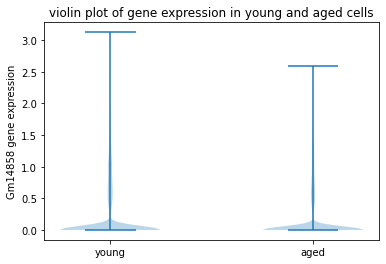

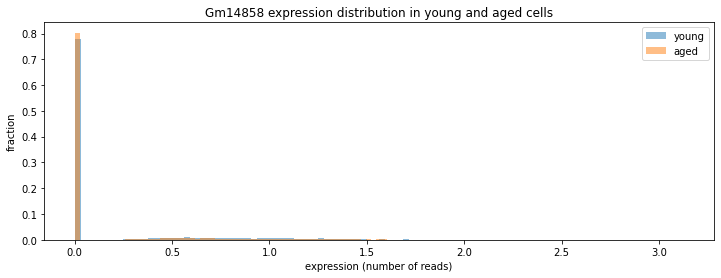

Hdac8:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.772959
std          0.737865
min          0.000000
25%          0.000000
50%          0.842094
75%          1.361468
max          3.754639
Name: Hdac8, dtype: float64


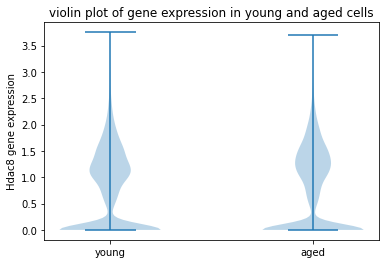

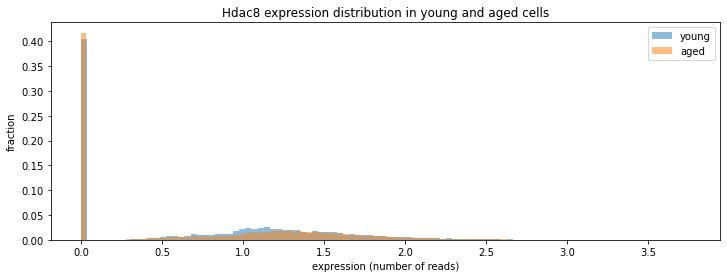

Phka1:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.364483
std          0.559804
min          0.000000
25%          0.000000
50%          0.000000
75%          0.732923
max          3.045475
Name: Phka1, dtype: float64


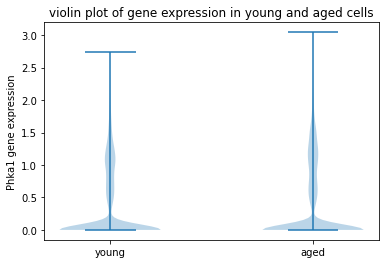

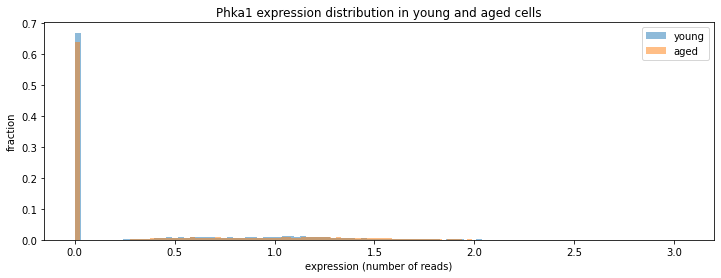

Chic1:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.478723
std          0.618834
min          0.000000
25%          0.000000
50%          0.000000
75%          1.003874
max          3.412935
Name: Chic1, dtype: float64


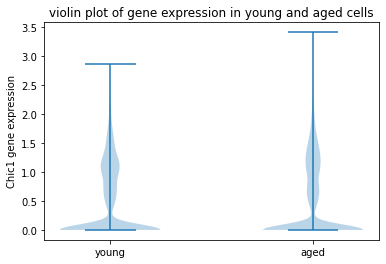

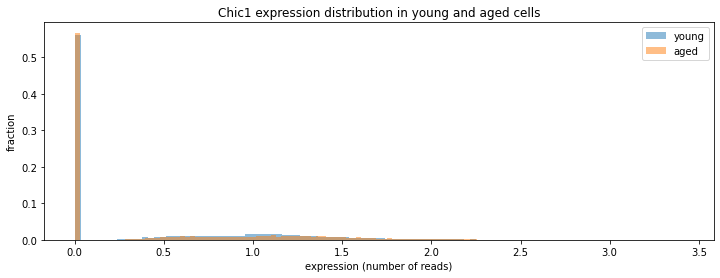

Tsix:
is a continuous feature, and here is the summary
count    25002.000000
mean         1.312789
std          0.850242
min          0.000000
25%          0.727848
50%          1.411645
75%          1.937048
max          4.424247
Name: Tsix, dtype: float64


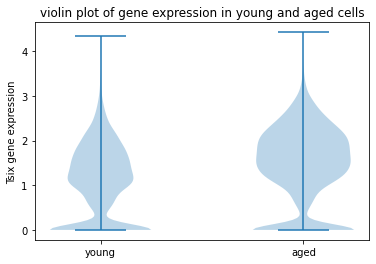

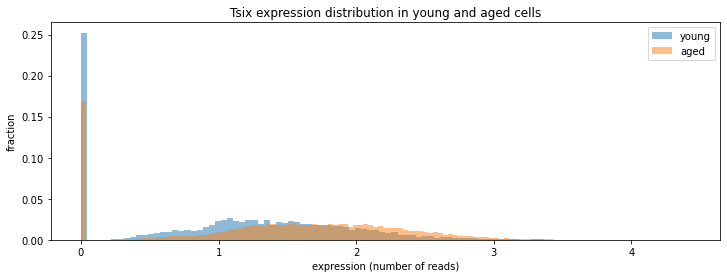

Xist:
is a continuous feature, and here is the summary
count    25002.000000
mean         2.967251
std          0.863626
min          0.000000
25%          2.443525
50%          3.034420
75%          3.596789
max          5.263303
Name: Xist, dtype: float64


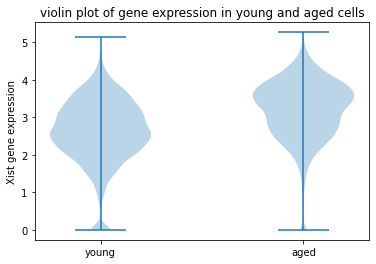

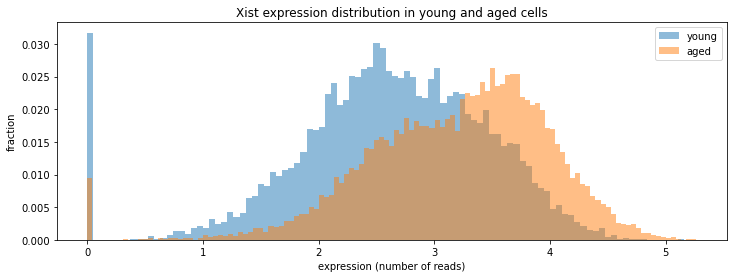

Jpx:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.511453
std          0.656468
min          0.000000
25%          0.000000
50%          0.000000
75%          1.055727
max          3.121320
Name: Jpx, dtype: float64


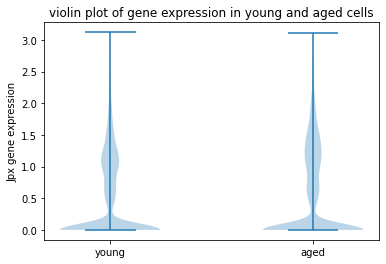

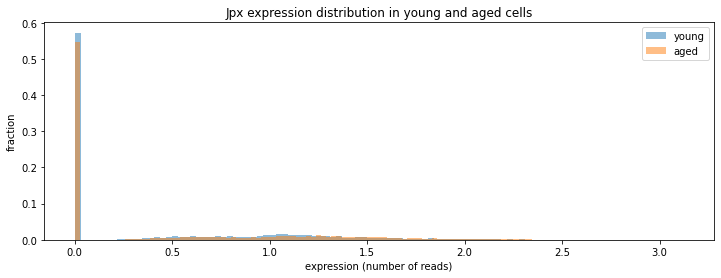

Ftx:
is a continuous feature, and here is the summary
count    25002.000000
mean         1.539548
std          0.777269
min          0.000000
25%          1.183615
50%          1.655895
75%          2.082528
max          4.075622
Name: Ftx, dtype: float64


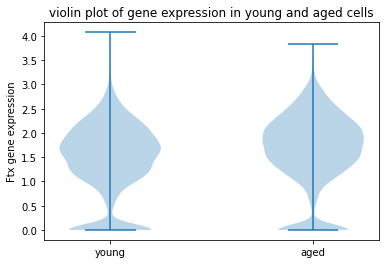

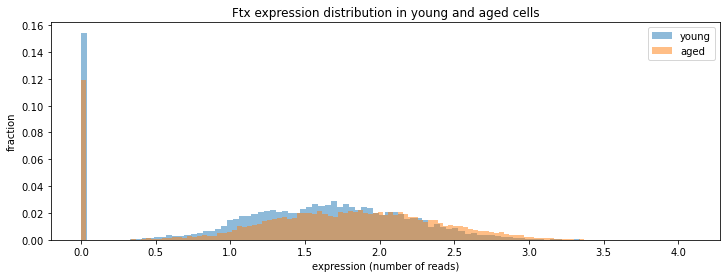

Slc16a2:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.218405
std          0.460999
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.922354
Name: Slc16a2, dtype: float64


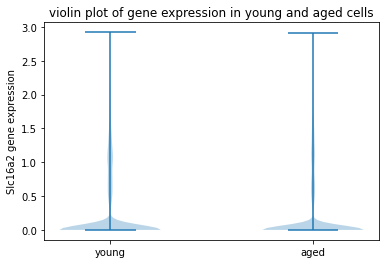

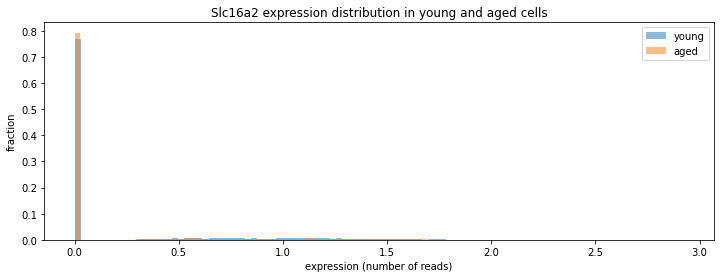

Rlim:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.245392
std          0.468893
min          0.000000
25%          0.000000
50%          0.000000
75%          0.326272
max          2.930993
Name: Rlim, dtype: float64


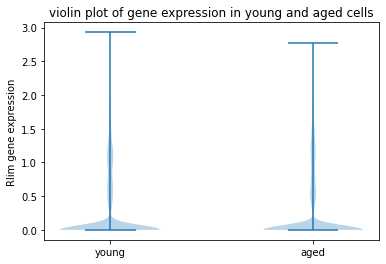

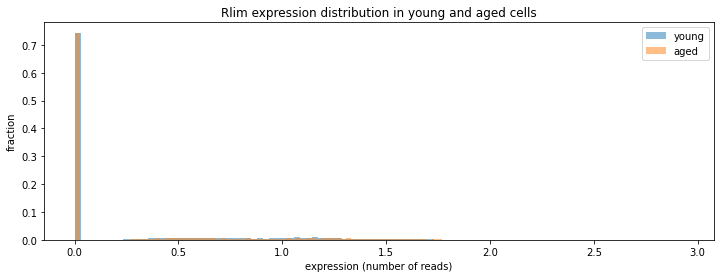

Nexmif:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.665771
std          0.731237
min          0.000000
25%          0.000000
50%          0.477032
75%          1.274614
max          3.610140
Name: Nexmif, dtype: float64


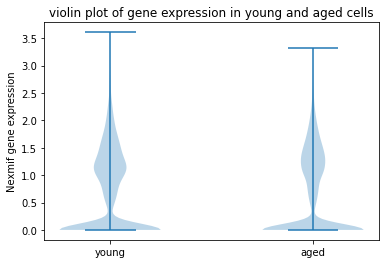

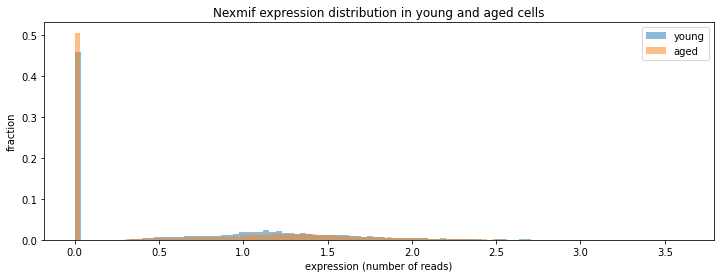

Abcb7:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.271089
std          0.492835
min          0.000000
25%          0.000000
50%          0.000000
75%          0.452594
max          2.773527
Name: Abcb7, dtype: float64


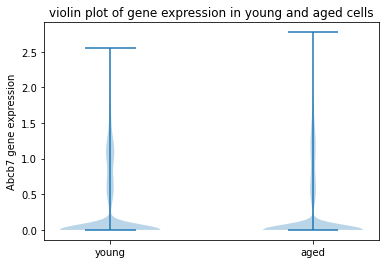

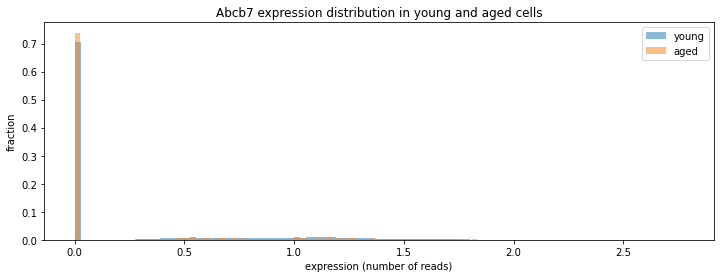

5530601H04Rik:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.317288
std          0.525447
min          0.000000
25%          0.000000
50%          0.000000
75%          0.597928
max          3.084432
Name: 5530601H04Rik, dtype: float64


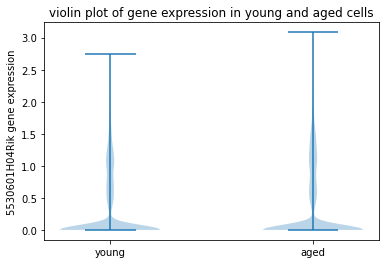

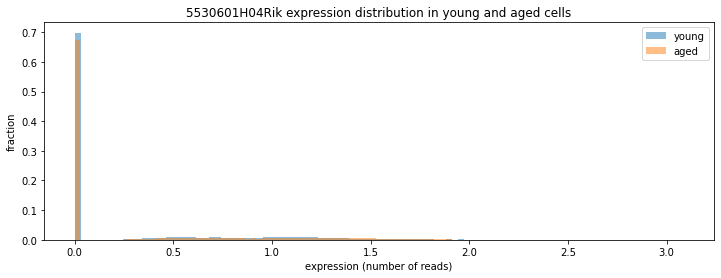

Pbdc1:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.176045
std          0.399571
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.694161
Name: Pbdc1, dtype: float64


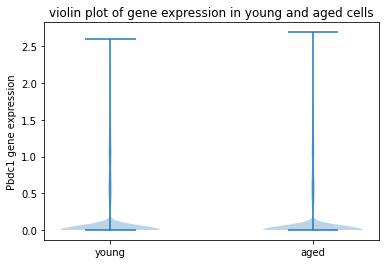

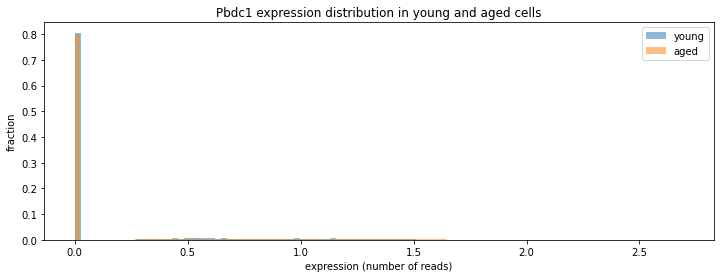

Magee1:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.130846
std          0.360553
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.815324
Name: Magee1, dtype: float64


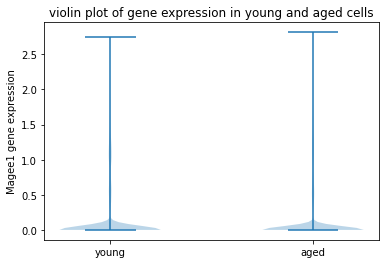

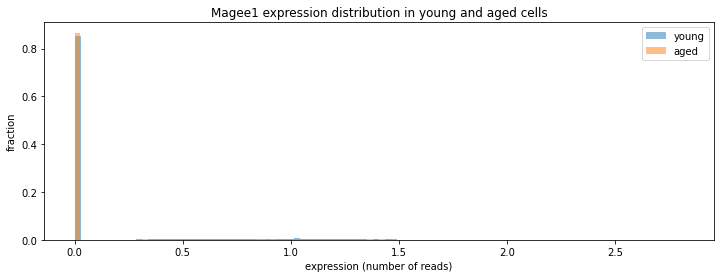

5330434G04Rik:
is a continuous feature, and here is the summary
count    25002.000000
mean         1.629020
std          0.759335
min          0.000000
25%          1.323555
50%          1.781418
75%          2.139405
max          3.577462
Name: 5330434G04Rik, dtype: float64


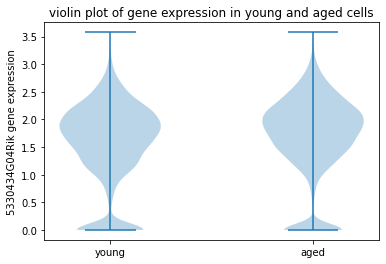

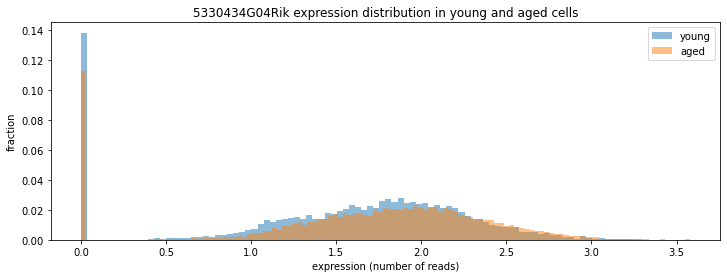

Atrx:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.891966
std          0.730147
min          0.000000
25%          0.000000
50%          1.069358
75%          1.459516
max          3.265336
Name: Atrx, dtype: float64


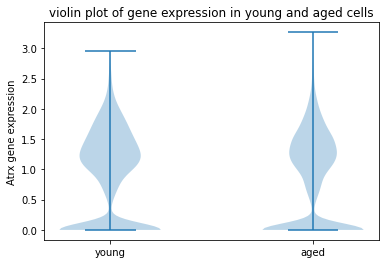

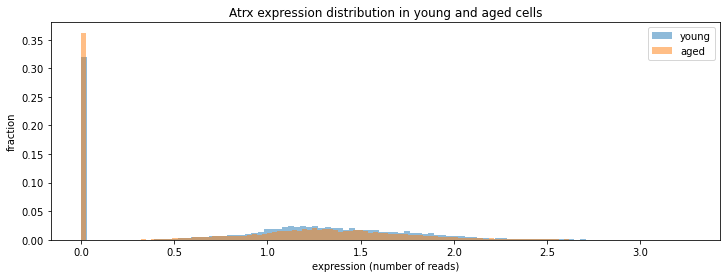

Cox7b:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.612845
std          0.709725
min          0.000000
25%          0.000000
50%          0.290970
75%          1.200305
max          3.069301
Name: Cox7b, dtype: float64


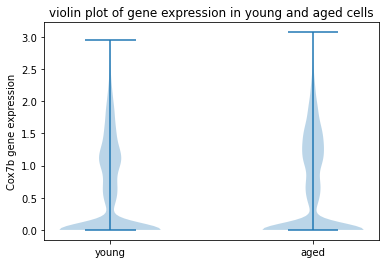

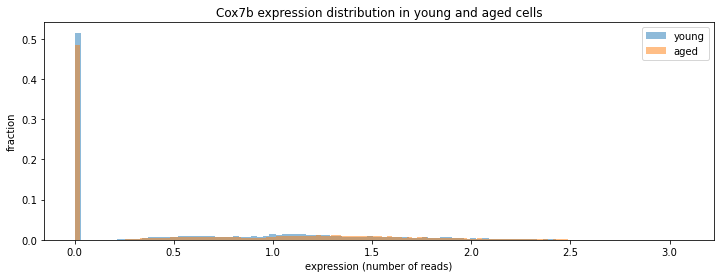

Atp7a:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.132693
std          0.365250
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.968294
Name: Atp7a, dtype: float64


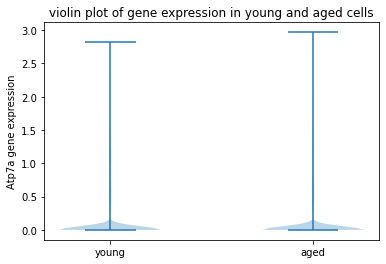

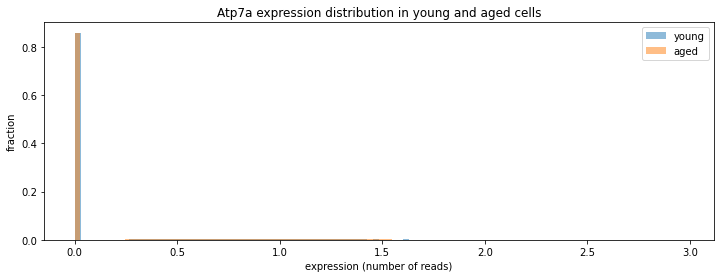

Pgk1:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.195161
std          0.441743
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.911878
Name: Pgk1, dtype: float64


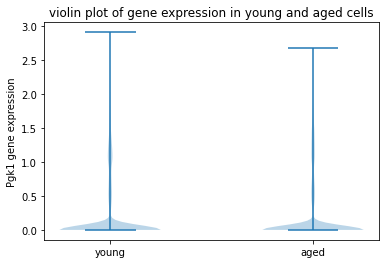

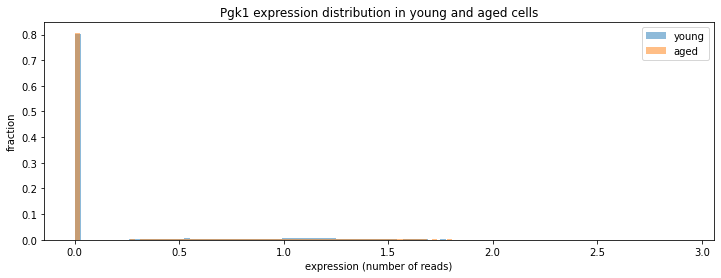

Brwd3:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.230135
std          0.447199
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.562001
Name: Brwd3, dtype: float64


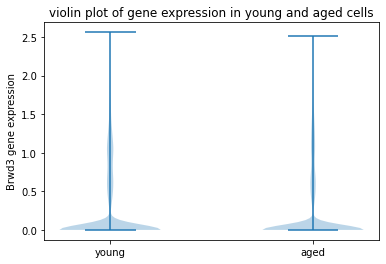

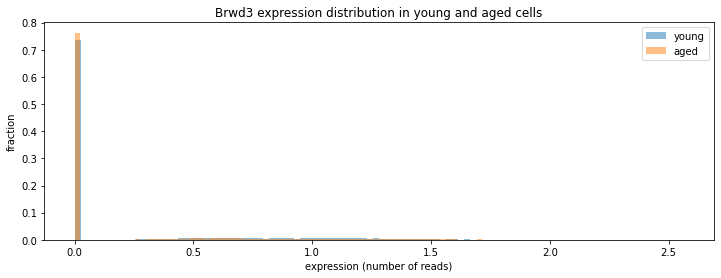

Sh3bgrl:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.122139
std          0.357858
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.760947
Name: Sh3bgrl, dtype: float64


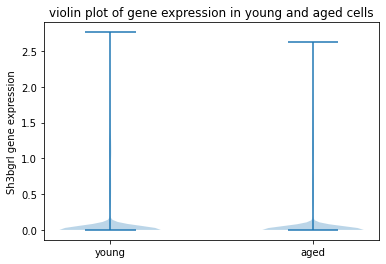

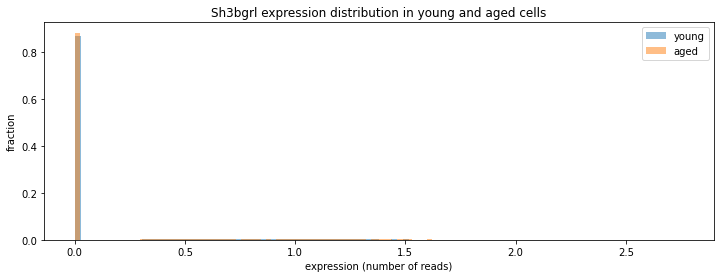

Hdx:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.332790
std          0.533328
min          0.000000
25%          0.000000
50%          0.000000
75%          0.660568
max          3.094102
Name: Hdx, dtype: float64


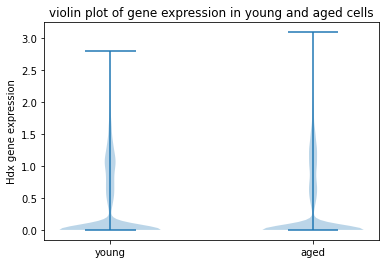

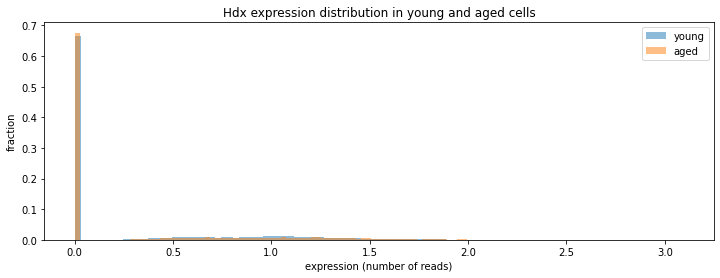

Zfp711:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.109612
std          0.319282
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.658875
Name: Zfp711, dtype: float64


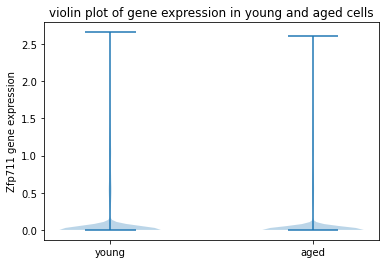

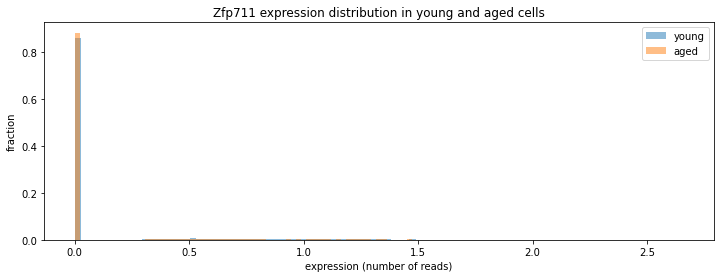

Chm:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.516973
std          0.619855
min          0.000000
25%          0.000000
50%          0.000000
75%          1.062123
max          2.986423
Name: Chm, dtype: float64


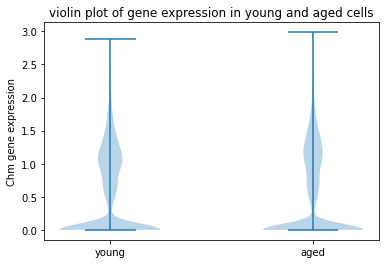

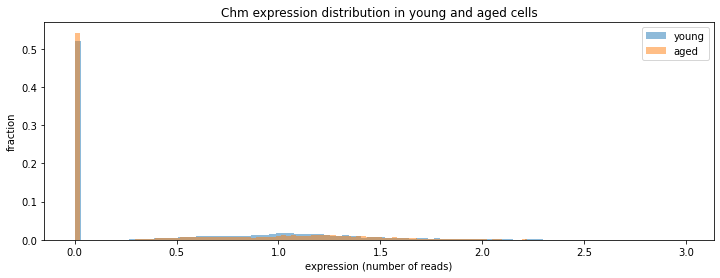

Pcdh11x:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.847779
std          0.998804
min          0.000000
25%          0.000000
50%          0.000000
75%          1.680367
max          4.194684
Name: Pcdh11x, dtype: float64


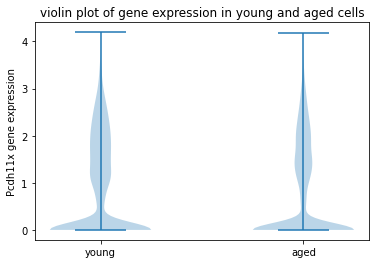

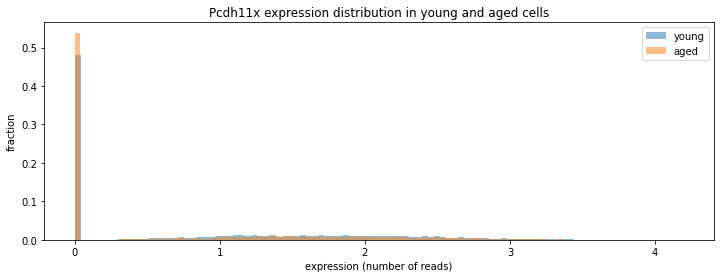

Nap1l3:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.109653
std          0.324459
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          3.301148
Name: Nap1l3, dtype: float64


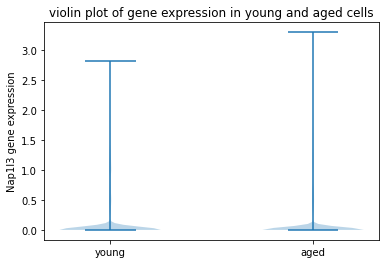

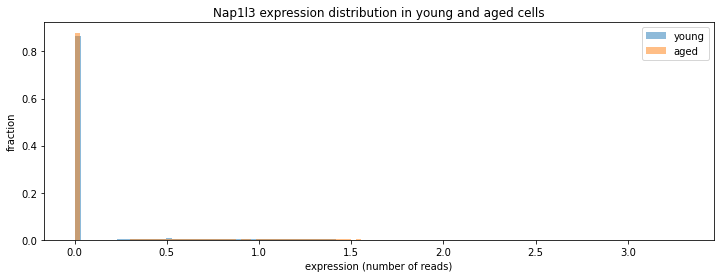

Diaph2:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.699987
std          0.750357
min          0.000000
25%          0.000000
50%          0.569677
75%          1.330209
max          3.561537
Name: Diaph2, dtype: float64


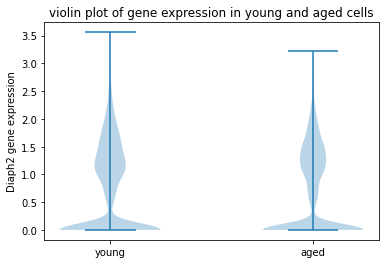

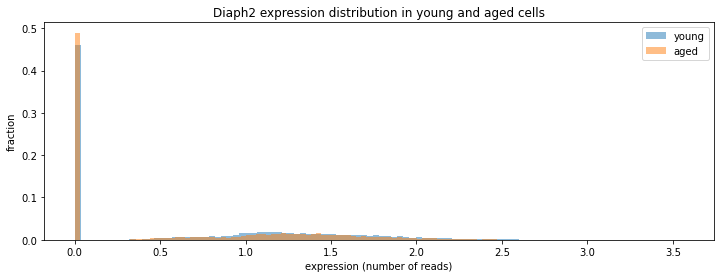

Pcdh19:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.467825
std          0.660798
min          0.000000
25%          0.000000
50%          0.000000
75%          1.032571
max          3.215426
Name: Pcdh19, dtype: float64


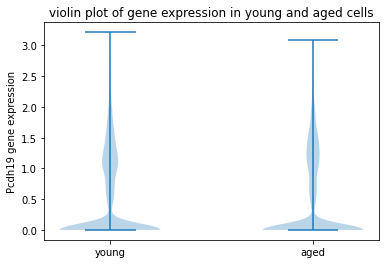

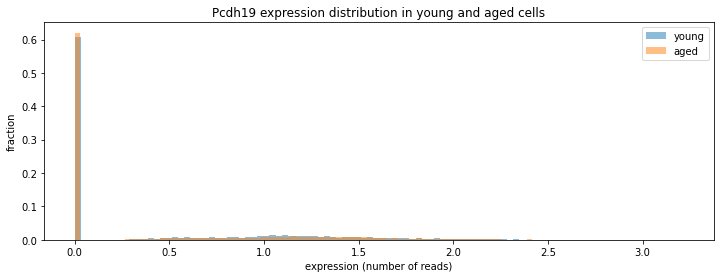

Cstf2:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.344763
std          0.526442
min          0.000000
25%          0.000000
50%          0.000000
75%          0.703815
max          2.990900
Name: Cstf2, dtype: float64


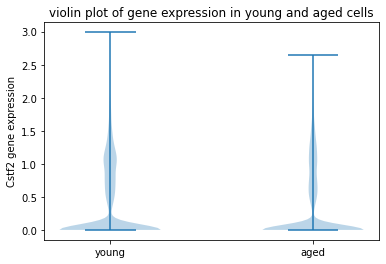

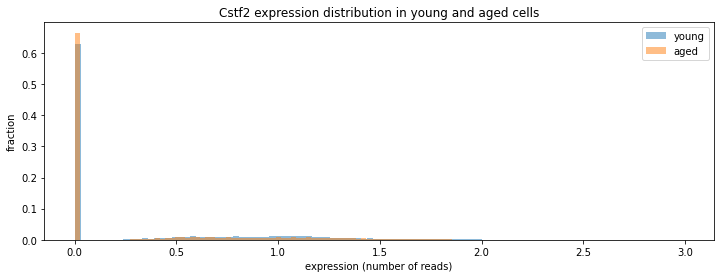

Nox1:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.118100
std          0.318873
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.809440
Name: Nox1, dtype: float64


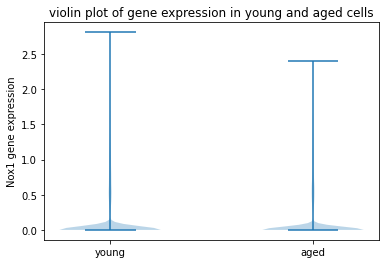

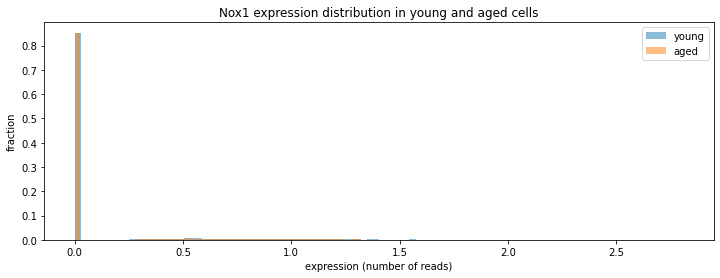

Tmem35a:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.185001
std          0.455022
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          3.167714
Name: Tmem35a, dtype: float64


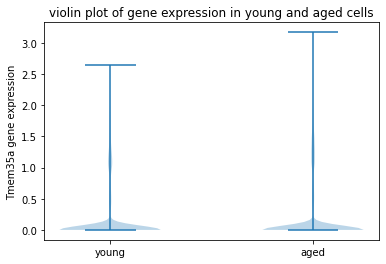

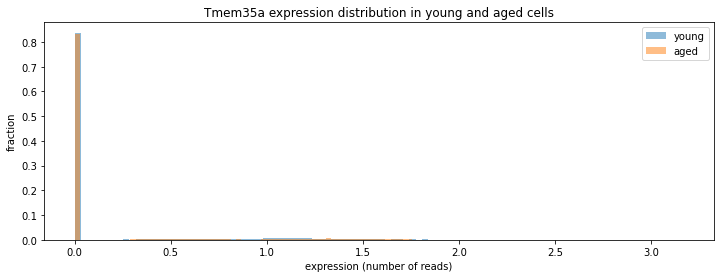

Drp2:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.151860
std          0.370600
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.873253
Name: Drp2, dtype: float64


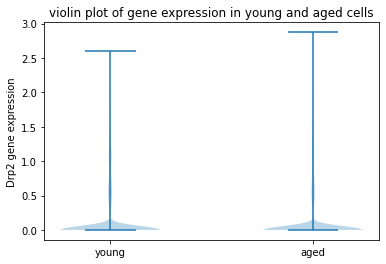

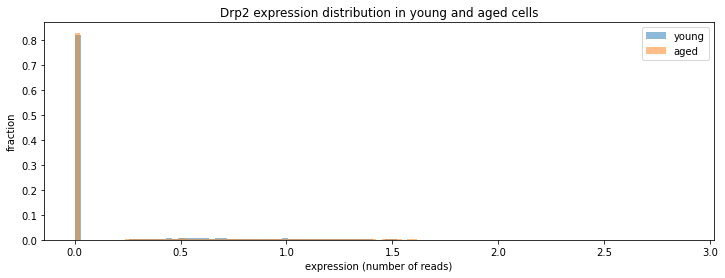

Rpl36a:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.317946
std          0.584634
min          0.000000
25%          0.000000
50%          0.000000
75%          0.420879
max          3.402116
Name: Rpl36a, dtype: float64


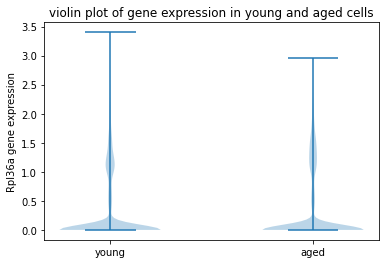

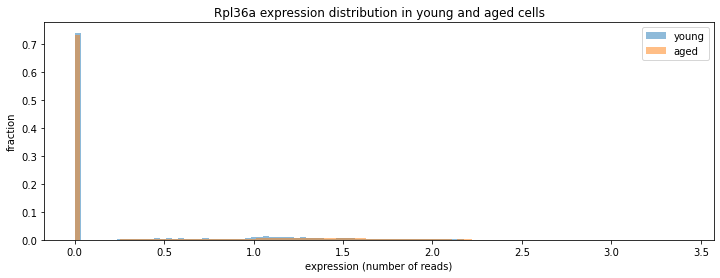

Hnrnph2:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.203257
std          0.443861
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.775876
Name: Hnrnph2, dtype: float64


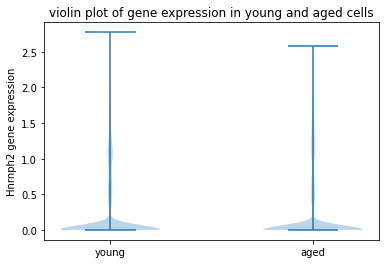

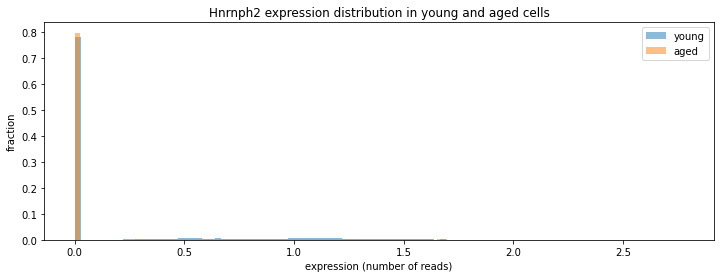

Armcx1:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.226530
std          0.444281
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          3.301148
Name: Armcx1, dtype: float64


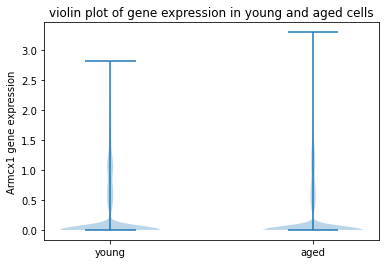

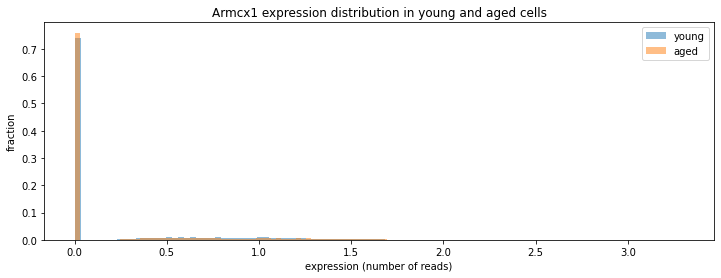

Armcx3:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.156139
std          0.382674
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.648440
Name: Armcx3, dtype: float64


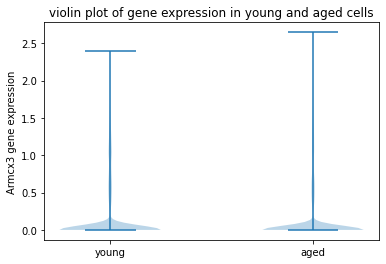

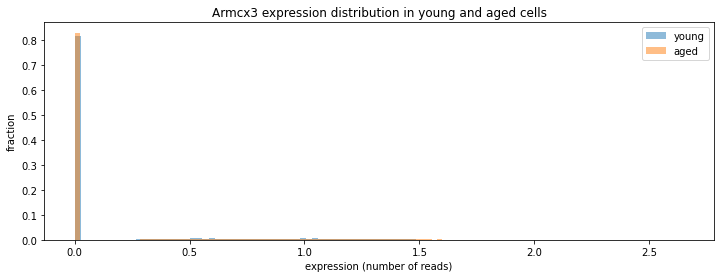

Zmat1:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.322549
std          0.525472
min          0.000000
25%          0.000000
50%          0.000000
75%          0.622367
max          2.821247
Name: Zmat1, dtype: float64


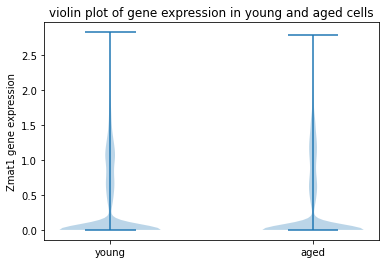

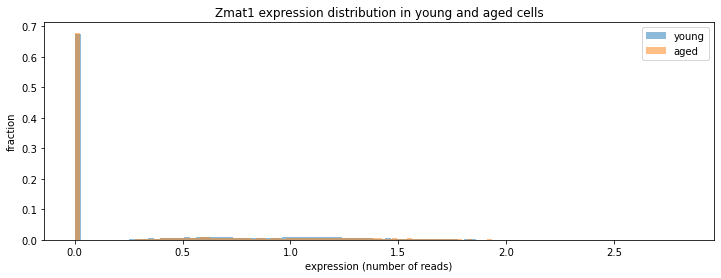

Armcx5:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.100476
std          0.300772
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.542897
Name: Armcx5, dtype: float64


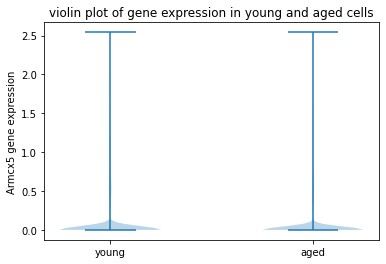

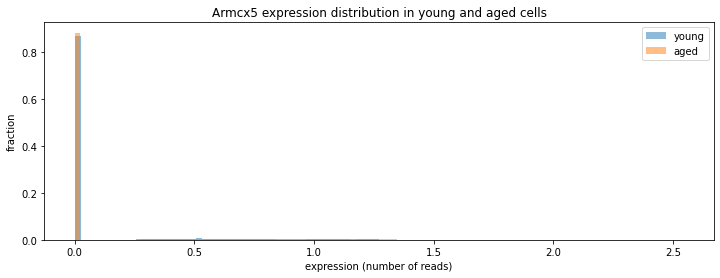

Gprasp1:
is a continuous feature, and here is the summary
count    25002.000000
mean         1.044607
std          0.762923
min          0.000000
25%          0.000000
50%          1.228483
75%          1.618459
max          3.456266
Name: Gprasp1, dtype: float64


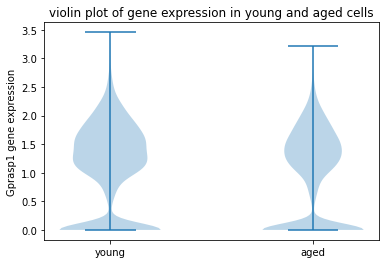

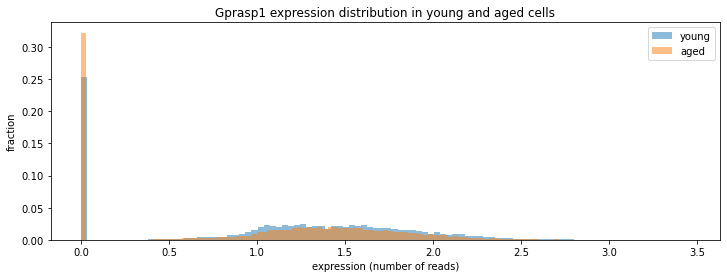

Bhlhb9:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.152461
std          0.372916
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.990003
Name: Bhlhb9, dtype: float64


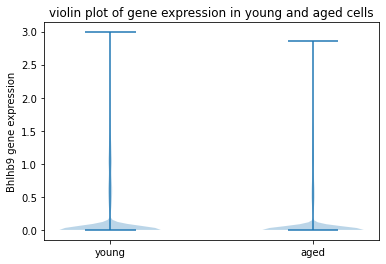

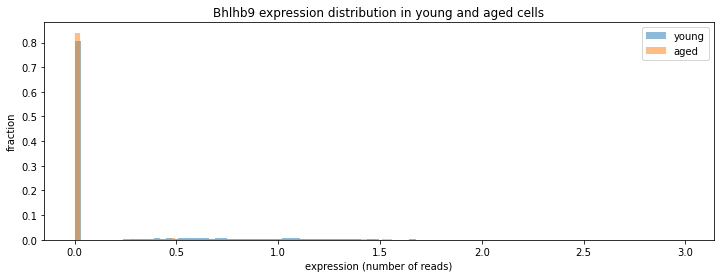

Gprasp2:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.519327
std          0.631238
min          0.000000
25%          0.000000
50%          0.000000
75%          1.068825
max          2.966545
Name: Gprasp2, dtype: float64


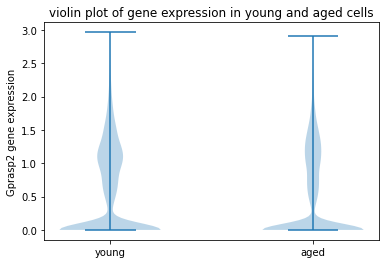

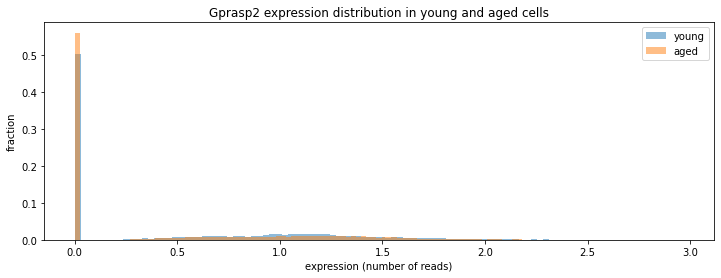

Arxes2:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.328929
std          0.580705
min          0.000000
25%          0.000000
50%          0.000000
75%          0.534475
max          3.387203
Name: Arxes2, dtype: float64


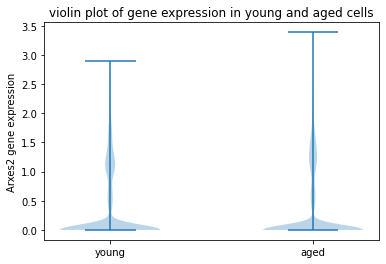

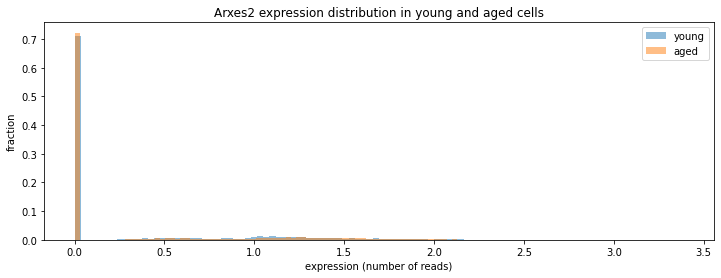

Arxes1:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.238925
std          0.507696
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.898817
Name: Arxes1, dtype: float64


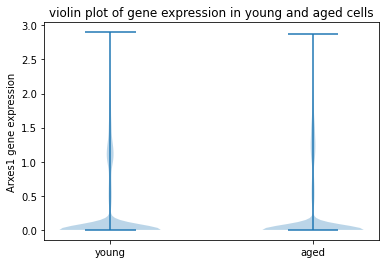

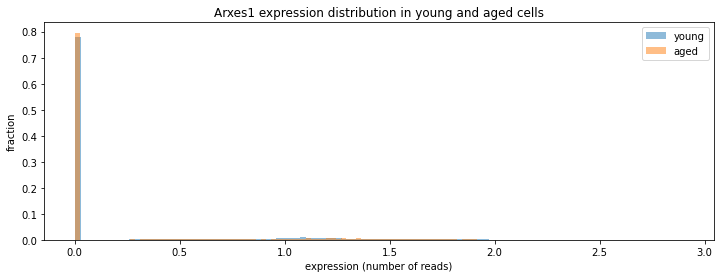

Bex2:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.890291
std          0.817015
min          0.000000
25%          0.000000
50%          0.873116
75%          1.534894
max          3.960854
Name: Bex2, dtype: float64


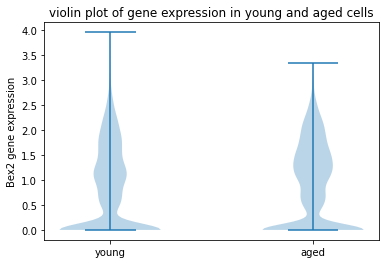

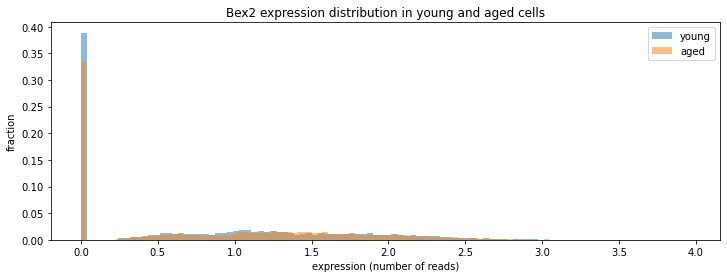

Bex4:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.116985
std          0.349443
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.655178
Name: Bex4, dtype: float64


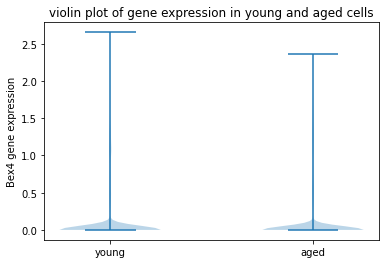

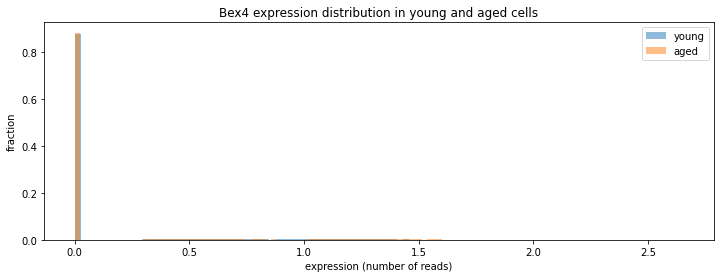

Tceal5:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.256014
std          0.487406
min          0.000000
25%          0.000000
50%          0.000000
75%          0.344909
max          2.821247
Name: Tceal5, dtype: float64


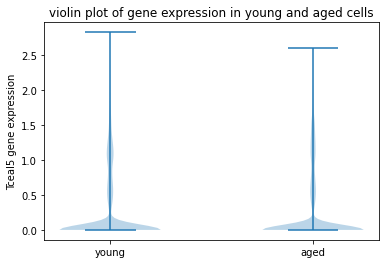

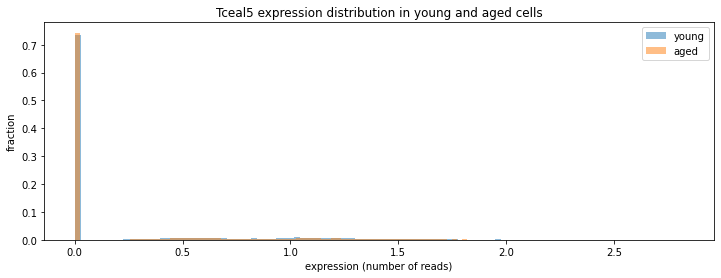

Bex1:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.356583
std          0.572843
min          0.000000
25%          0.000000
50%          0.000000
75%          0.678142
max          2.930153
Name: Bex1, dtype: float64


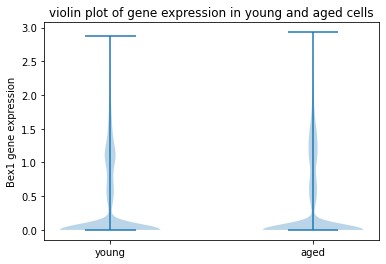

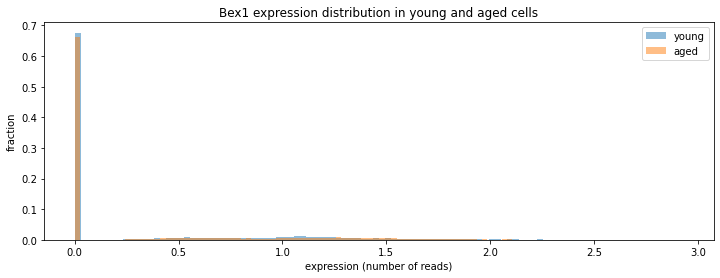

Tceal9:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.269062
std          0.524418
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          3.826687
Name: Tceal9, dtype: float64


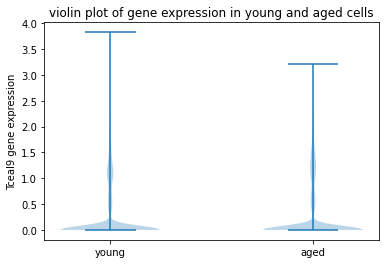

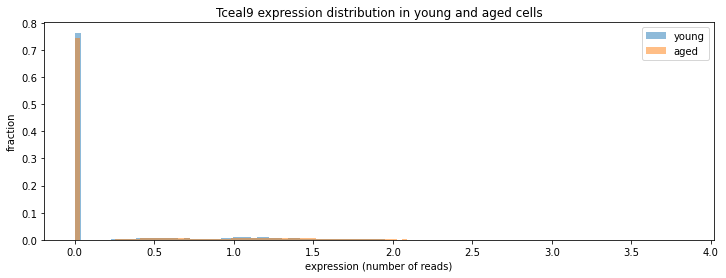

Bex3:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.362048
std          0.575934
min          0.000000
25%          0.000000
50%          0.000000
75%          0.692099
max          3.332301
Name: Bex3, dtype: float64


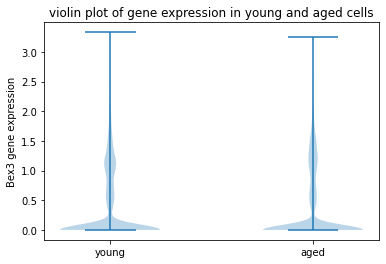

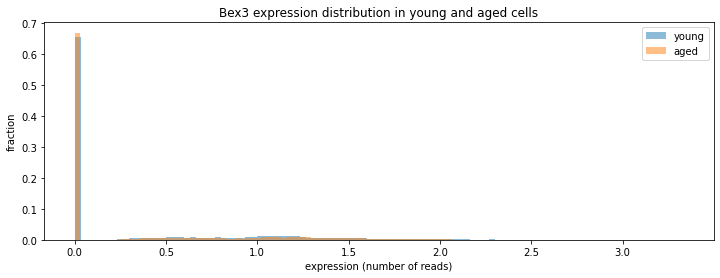

Tceal3:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.220289
std          0.466907
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.799237
Name: Tceal3, dtype: float64


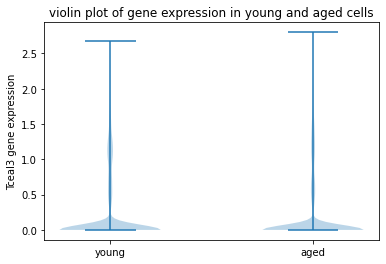

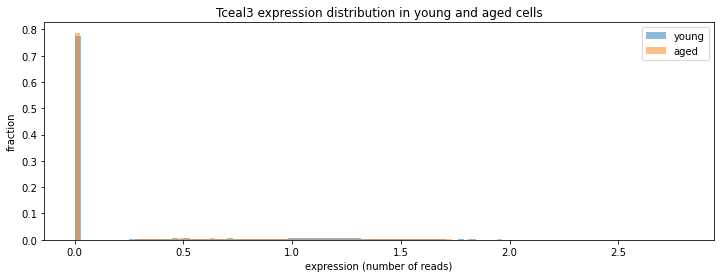

Morf4l2:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.477883
std          0.614236
min          0.000000
25%          0.000000
50%          0.000000
75%          1.002739
max          3.473518
Name: Morf4l2, dtype: float64


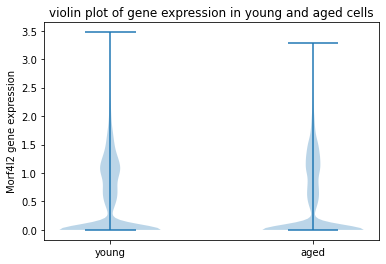

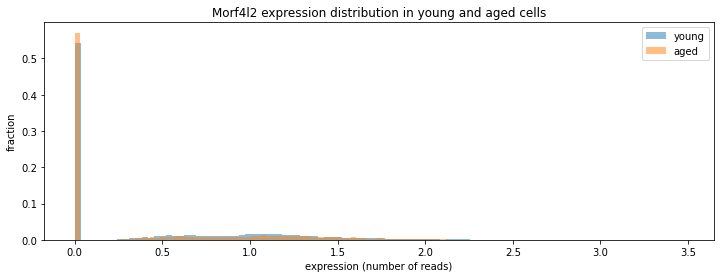

BC065397:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.172809
std          0.414359
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.420004
Name: BC065397, dtype: float64


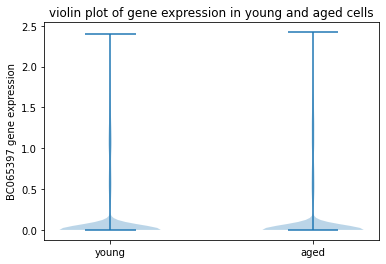

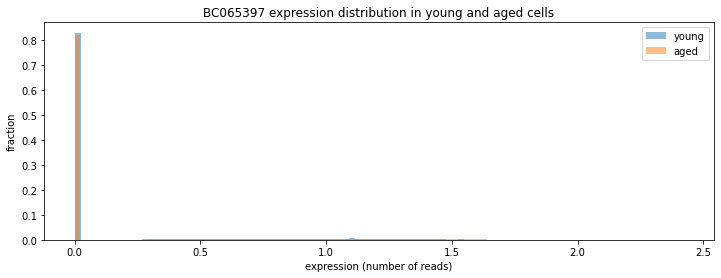

Plp1:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.428047
std          0.691564
min          0.000000
25%          0.000000
50%          0.000000
75%          0.793255
max          4.734623
Name: Plp1, dtype: float64


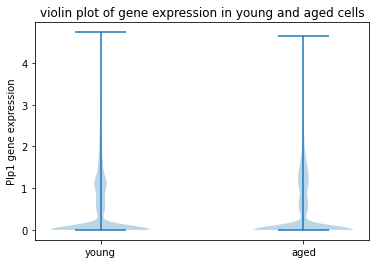

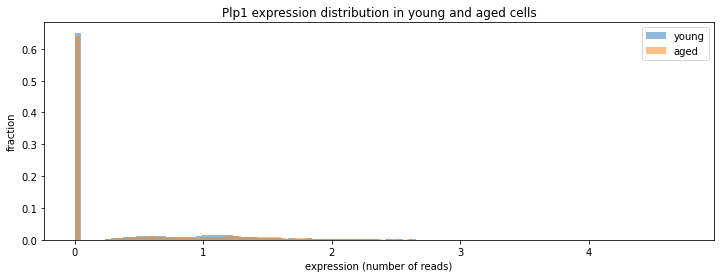

Rab9b:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.142467
std          0.390778
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.747861
Name: Rab9b, dtype: float64


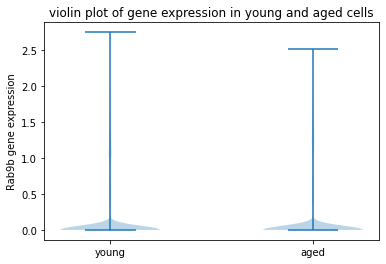

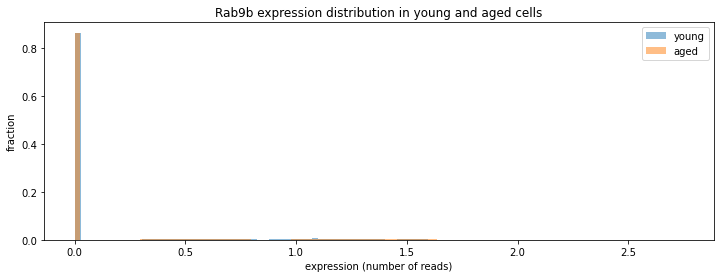

Zcchc18:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.914609
std          0.740774
min          0.000000
25%          0.000000
50%          1.077309
75%          1.490781
max          3.455523
Name: Zcchc18, dtype: float64


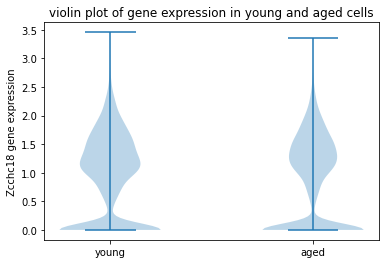

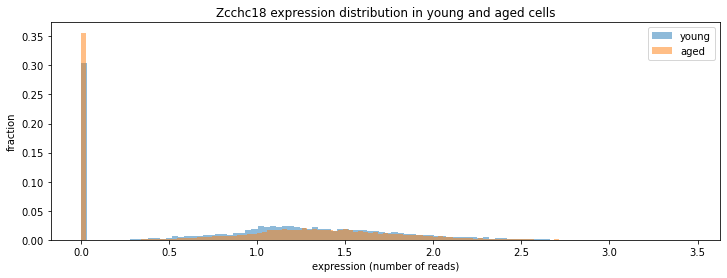

Fam199x:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.114340
std          0.326358
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.755413
Name: Fam199x, dtype: float64


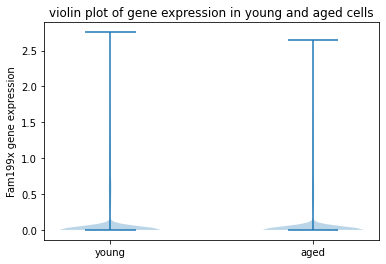

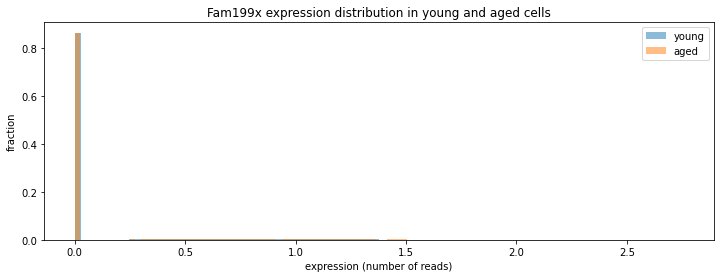

Il1rapl2:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.796480
std          1.218233
min          0.000000
25%          0.000000
50%          0.000000
75%          1.662591
max          4.847118
Name: Il1rapl2, dtype: float64


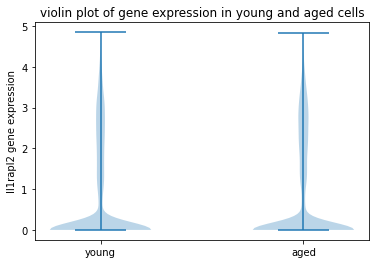

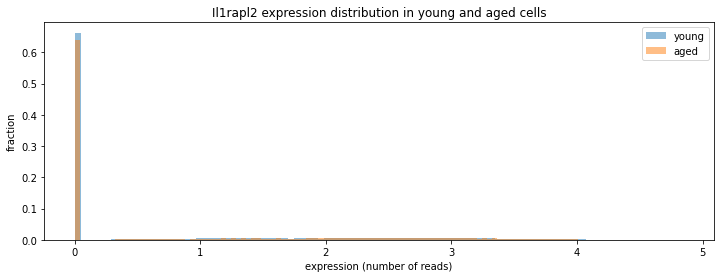

Rnf128:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.174851
std          0.423890
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          3.188656
Name: Rnf128, dtype: float64


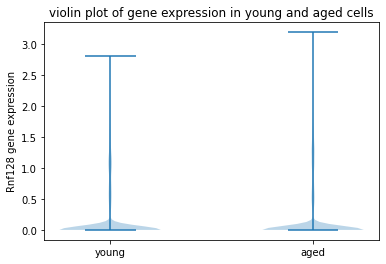

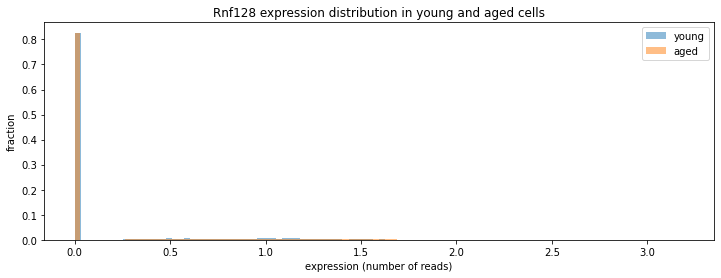

Rbm41:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.155002
std          0.370327
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.706393
Name: Rbm41, dtype: float64


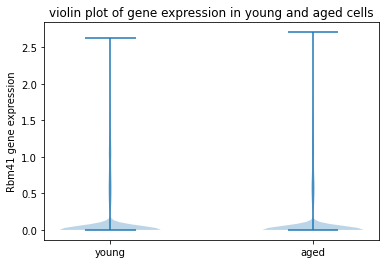

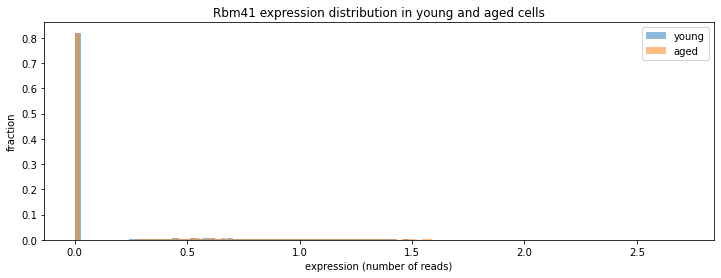

Frmpd3:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.402438
std          0.614353
min          0.000000
25%          0.000000
50%          0.000000
75%          0.885124
max          3.218108
Name: Frmpd3, dtype: float64


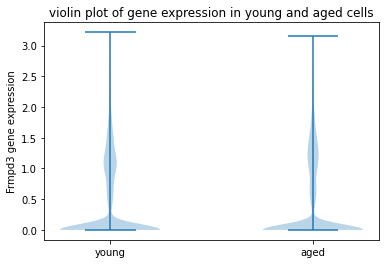

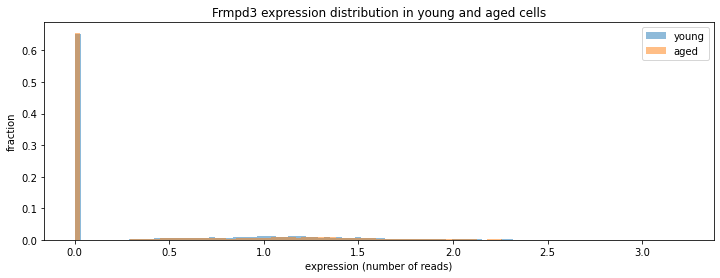

Mid2:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.219175
std          0.438527
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.747177
Name: Mid2, dtype: float64


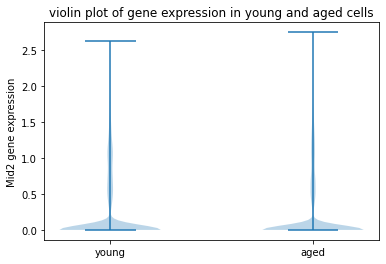

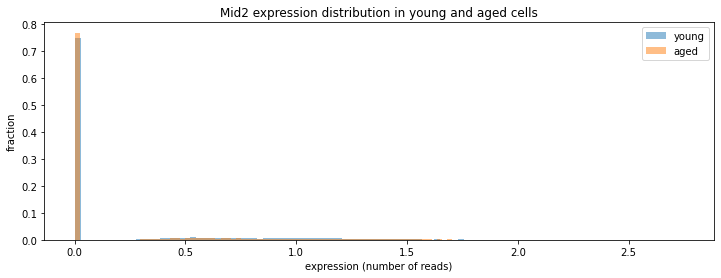

Acsl4:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.307901
std          0.512233
min          0.000000
25%          0.000000
50%          0.000000
75%          0.598629
max          3.149907
Name: Acsl4, dtype: float64


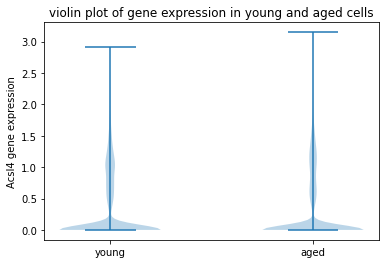

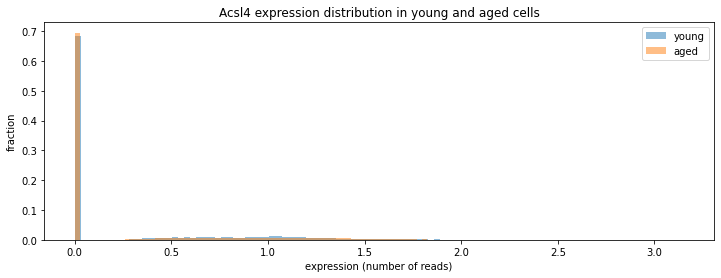

Tmem164:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.399105
std          0.600337
min          0.000000
25%          0.000000
50%          0.000000
75%          0.853189
max          3.581415
Name: Tmem164, dtype: float64


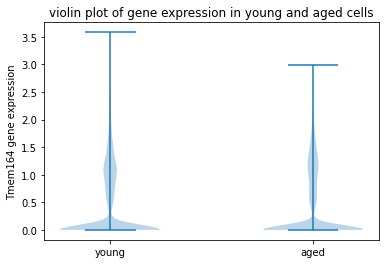

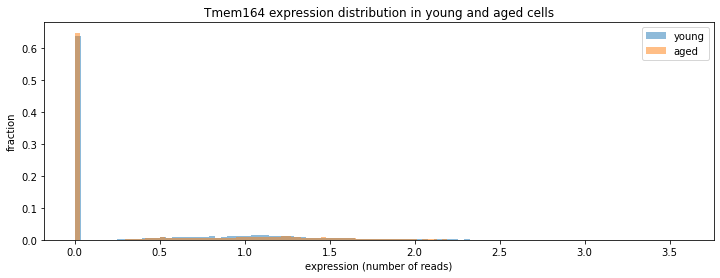

Ammecr1:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.473996
std          0.652389
min          0.000000
25%          0.000000
50%          0.000000
75%          1.008566
max          3.462480
Name: Ammecr1, dtype: float64


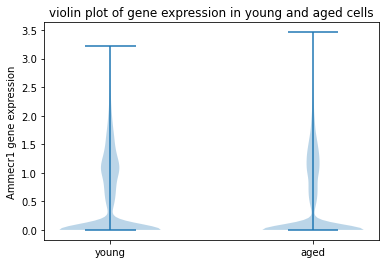

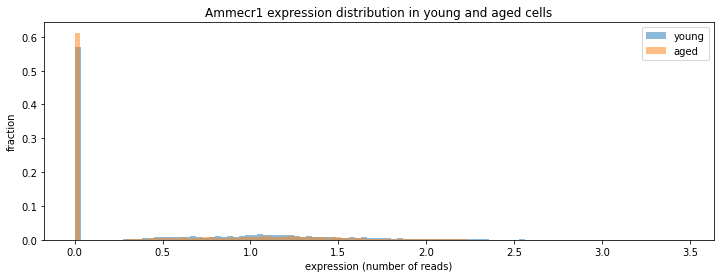

Pak3:
is a continuous feature, and here is the summary
count    25002.000000
mean         1.331132
std          0.811221
min          0.000000
25%          0.947909
50%          1.486134
75%          1.909584
max          3.906827
Name: Pak3, dtype: float64


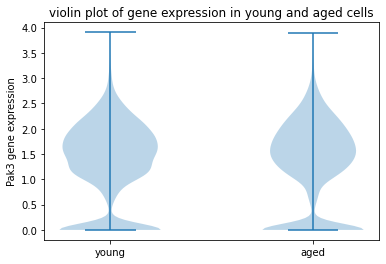

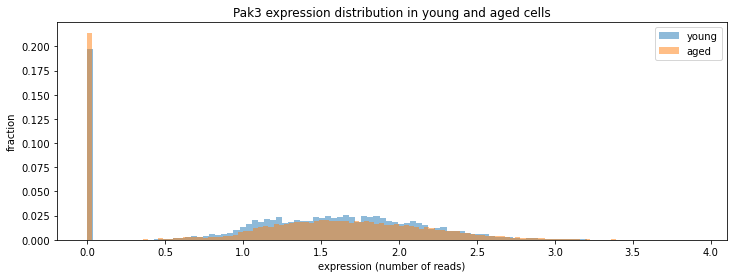

Dcx:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.456751
std          0.611281
min          0.000000
25%          0.000000
50%          0.000000
75%          0.983899
max          3.213515
Name: Dcx, dtype: float64


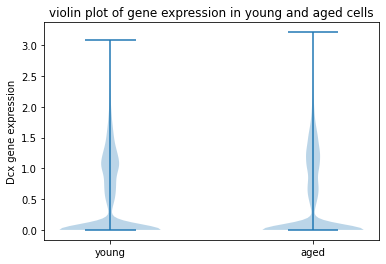

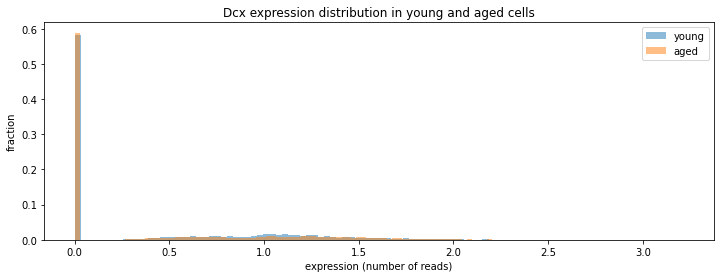

Alg13:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.130475
std          0.347989
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.561449
Name: Alg13, dtype: float64


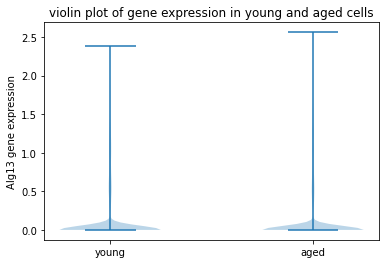

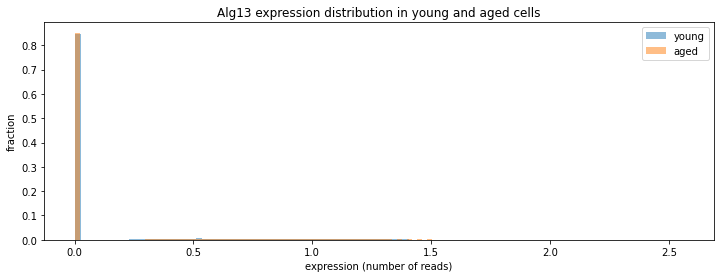

Trpc5:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.625195
std          0.808237
min          0.000000
25%          0.000000
50%          0.000000
75%          1.295020
max          4.039651
Name: Trpc5, dtype: float64


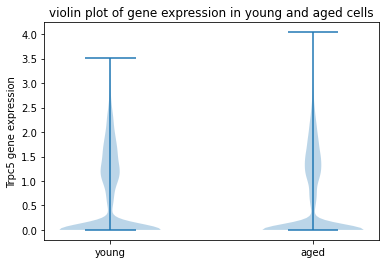

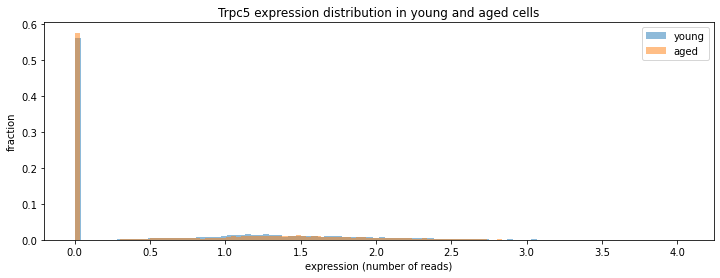

Rtl4:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.958070
std          0.941114
min          0.000000
25%          0.000000
50%          1.027029
75%          1.751809
max          4.625072
Name: Rtl4, dtype: float64


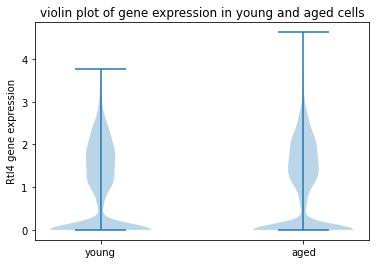

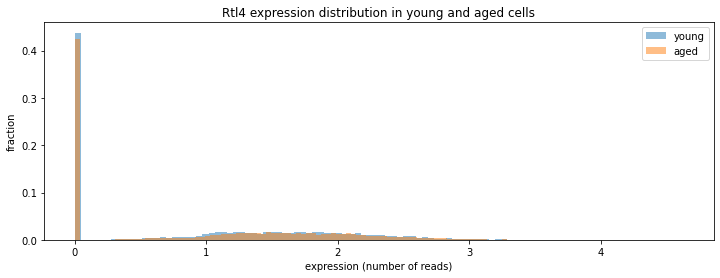

Htr2c:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.952608
std          1.089643
min          0.000000
25%          0.000000
50%          0.000000
75%          1.893567
max          4.149810
Name: Htr2c, dtype: float64


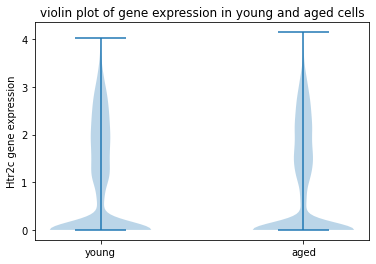

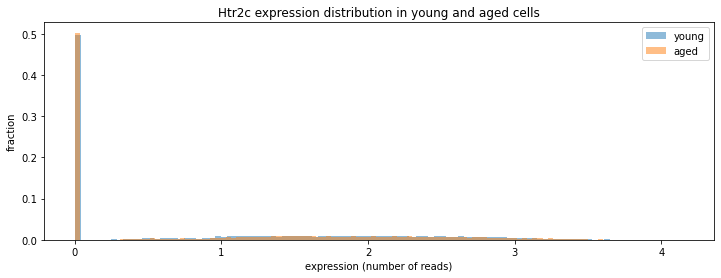

Lrch2:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.287876
std          0.490834
min          0.000000
25%          0.000000
50%          0.000000
75%          0.544926
max          2.783436
Name: Lrch2, dtype: float64


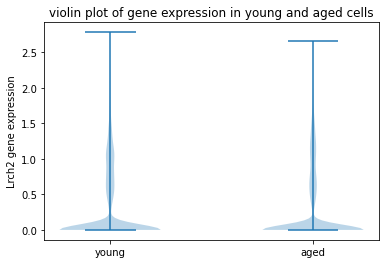

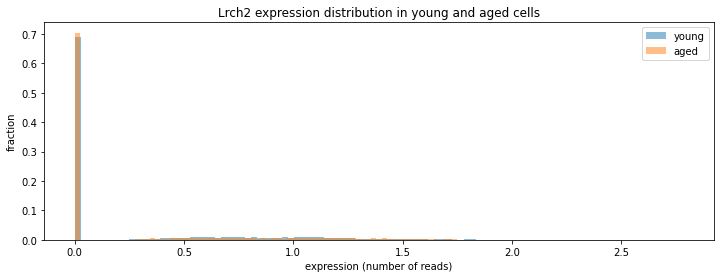

Tmem29:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.316752
std          0.529918
min          0.000000
25%          0.000000
50%          0.000000
75%          0.589306
max          2.882436
Name: Tmem29, dtype: float64


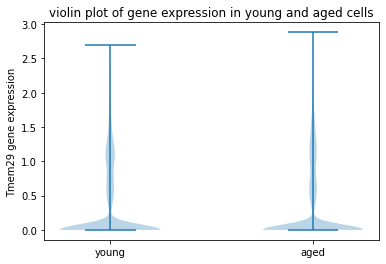

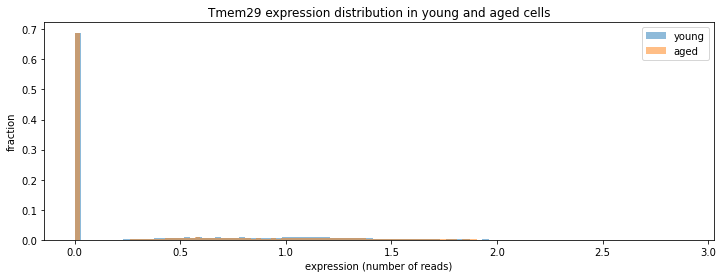

Apex2:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.627175
std          0.678677
min          0.000000
25%          0.000000
50%          0.505105
75%          1.196989
max          3.301148
Name: Apex2, dtype: float64


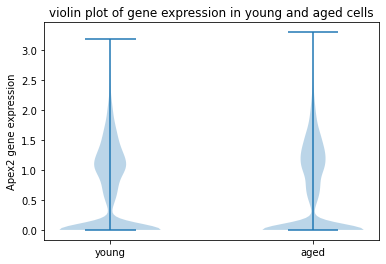

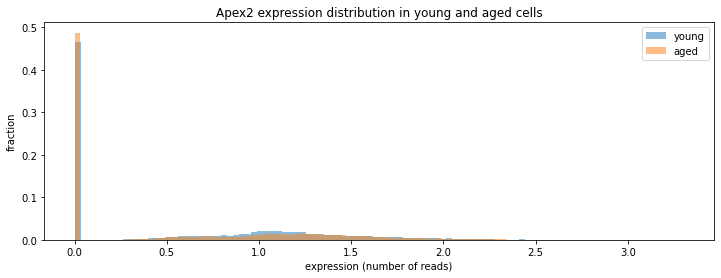

Tro:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.653882
std          0.687787
min          0.000000
25%          0.000000
50%          0.581805
75%          1.233633
max          3.285749
Name: Tro, dtype: float64


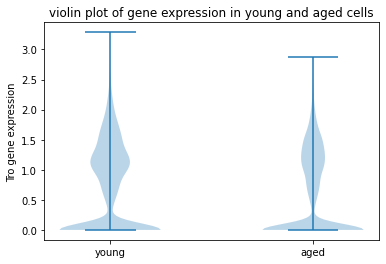

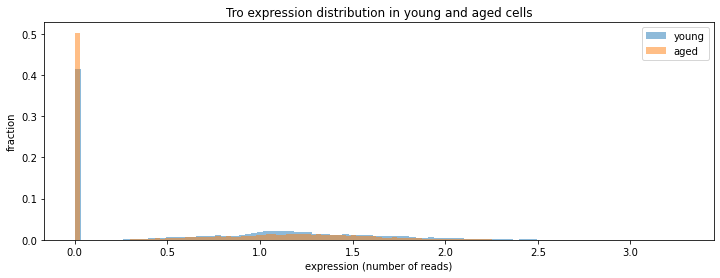

Maged2:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.122496
std          0.351418
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.621410
Name: Maged2, dtype: float64


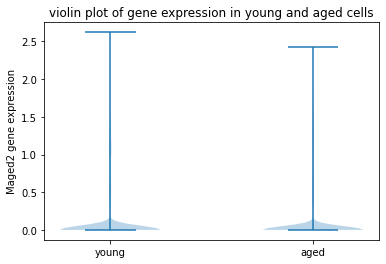

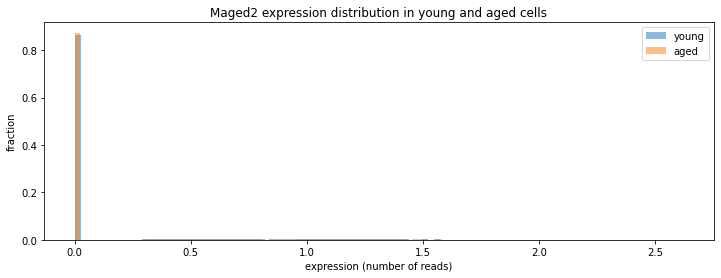

Gnl3l:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.480255
std          0.606059
min          0.000000
25%          0.000000
50%          0.000000
75%          1.003874
max          2.966982
Name: Gnl3l, dtype: float64


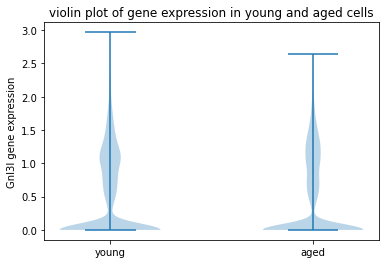

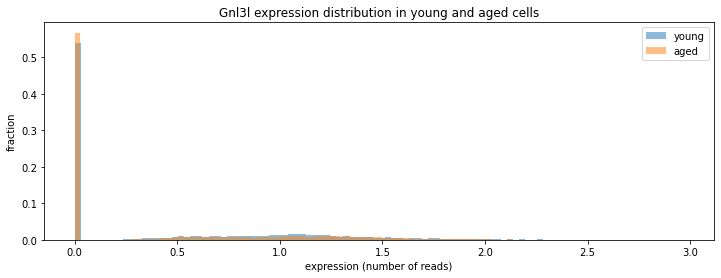

Fgd1:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.153614
std          0.371673
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.635721
Name: Fgd1, dtype: float64


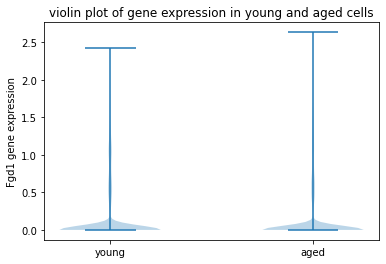

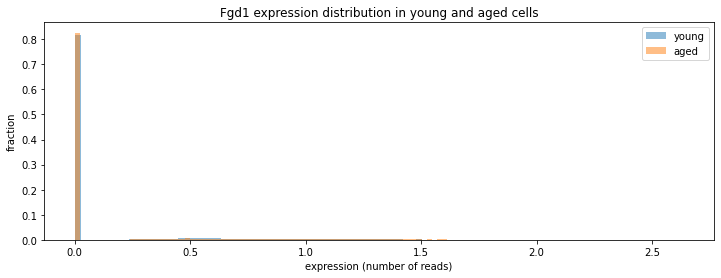

Wnk3:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.261069
std          0.466964
min          0.000000
25%          0.000000
50%          0.000000
75%          0.473094
max          2.947096
Name: Wnk3, dtype: float64


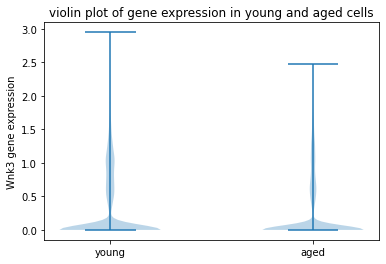

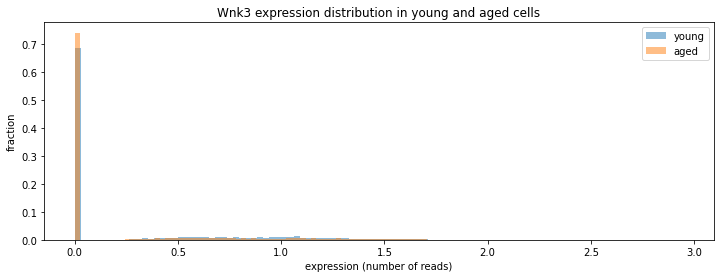

A230072E10Rik:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.105354
std          0.312544
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.516328
Name: A230072E10Rik, dtype: float64


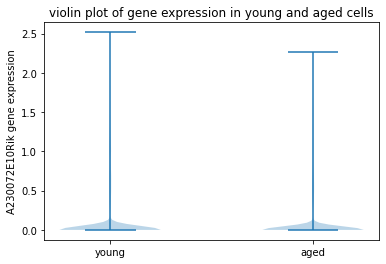

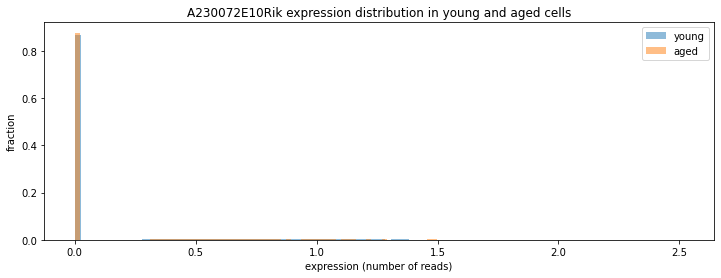

Fam120c:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.492157
std          0.618712
min          0.000000
25%          0.000000
50%          0.000000
75%          1.031176
max          2.924465
Name: Fam120c, dtype: float64


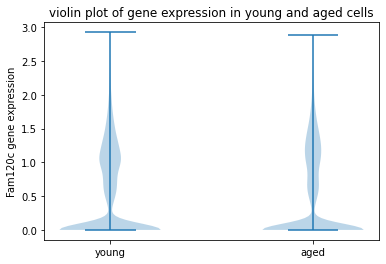

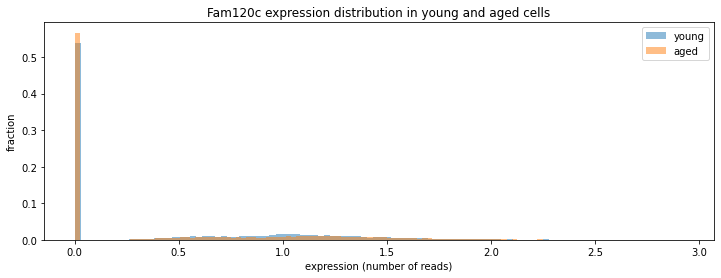

Phf8:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.318025
std          0.516917
min          0.000000
25%          0.000000
50%          0.000000
75%          0.619150
max          3.100060
Name: Phf8, dtype: float64


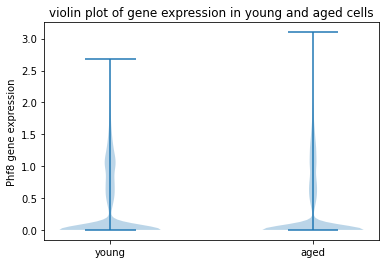

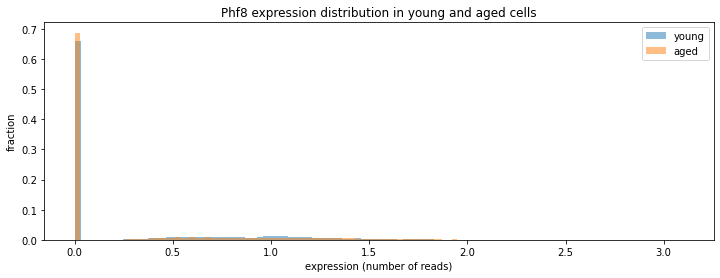

Huwe1:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.921929
std          0.739685
min          0.000000
25%          0.000000
50%          1.112368
75%          1.497869
max          3.272023
Name: Huwe1, dtype: float64


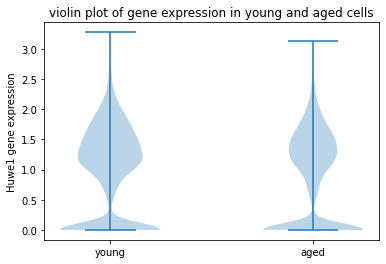

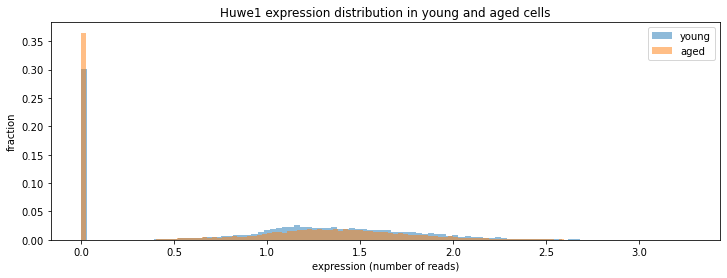

Smc1a:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.182827
std          0.400680
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.916825
Name: Smc1a, dtype: float64


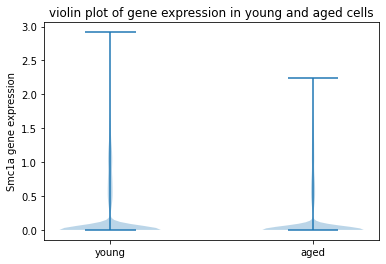

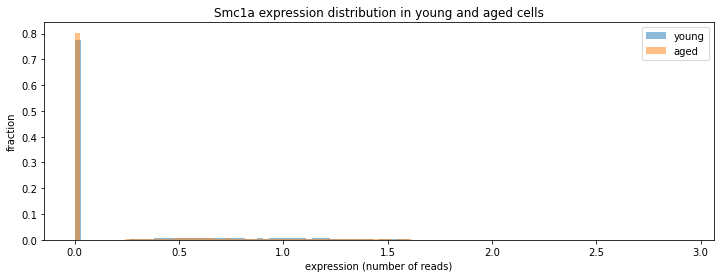

Iqsec2:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.407756
std          0.576344
min          0.000000
25%          0.000000
50%          0.000000
75%          0.878294
max          2.986423
Name: Iqsec2, dtype: float64


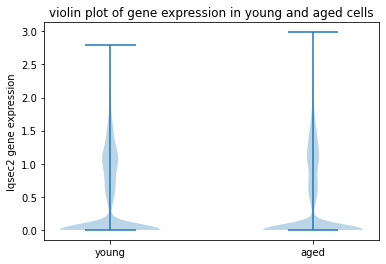

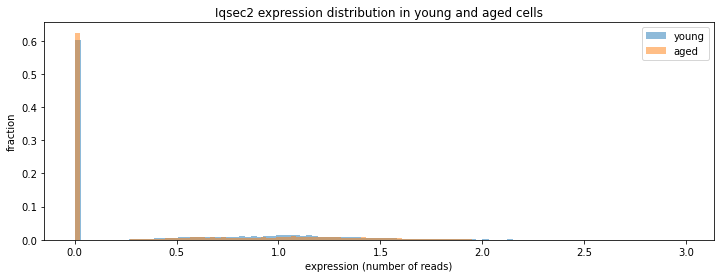

Kdm5c:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.538968
std          0.651392
min          0.000000
25%          0.000000
50%          0.000000
75%          1.084546
max          3.315102
Name: Kdm5c, dtype: float64


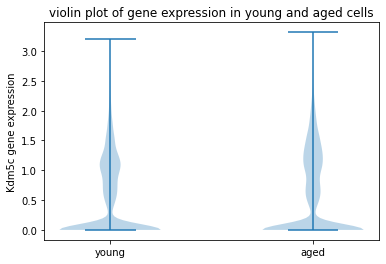

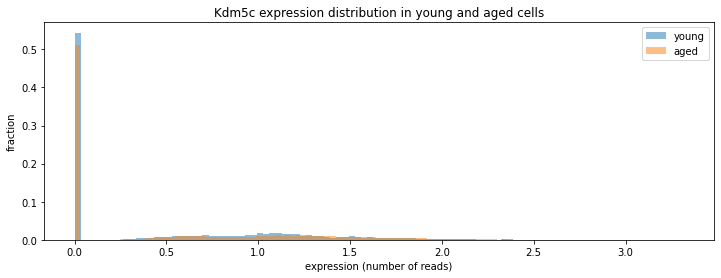

Kantr:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.495034
std          0.624073
min          0.000000
25%          0.000000
50%          0.000000
75%          1.027836
max          3.508478
Name: Kantr, dtype: float64


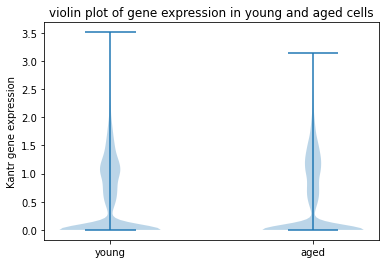

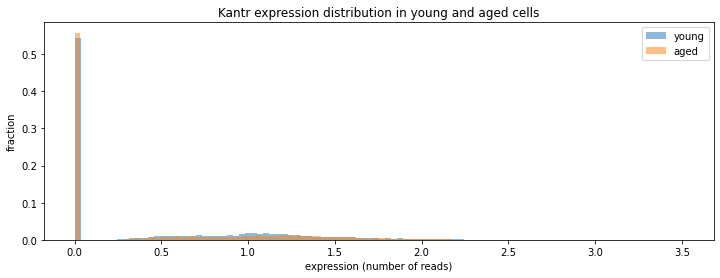

Tspyl2:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.288312
std          0.494875
min          0.000000
25%          0.000000
50%          0.000000
75%          0.532337
max          2.827210
Name: Tspyl2, dtype: float64


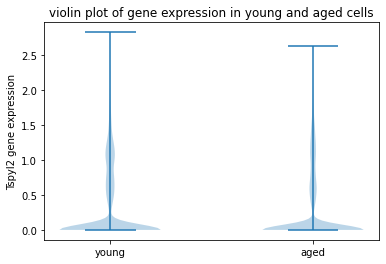

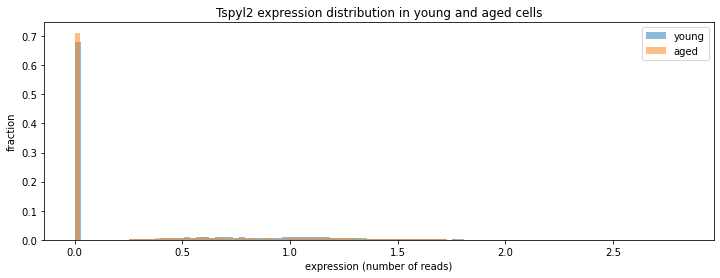

3010001F23Rik:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.169625
std          0.391096
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.911878
Name: 3010001F23Rik, dtype: float64


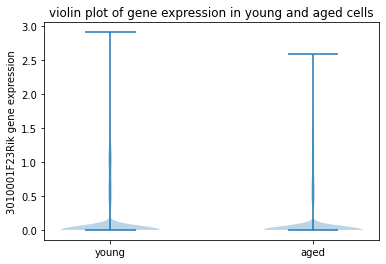

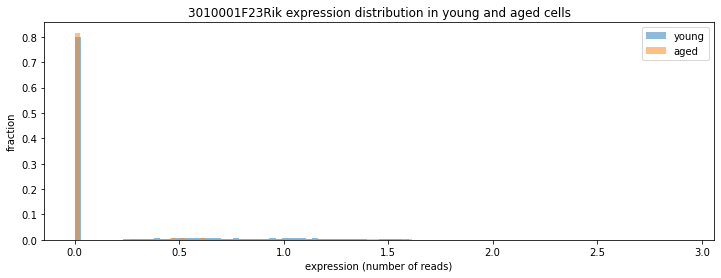

Shroom2:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.131815
std          0.368680
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.533770
Name: Shroom2, dtype: float64


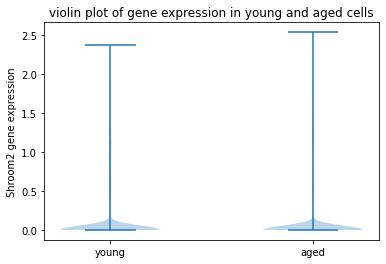

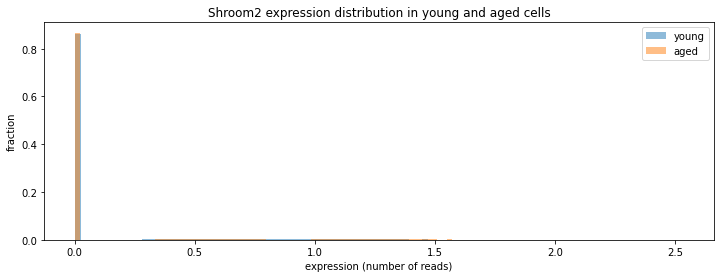

Mageh1:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.171400
std          0.433813
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.993897
Name: Mageh1, dtype: float64


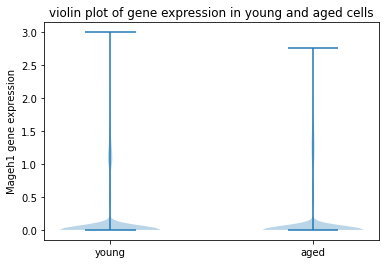

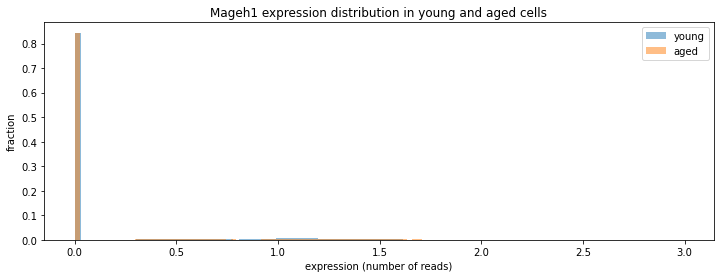

Rragb:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.321477
std          0.518816
min          0.000000
25%          0.000000
50%          0.000000
75%          0.634632
max          3.149907
Name: Rragb, dtype: float64


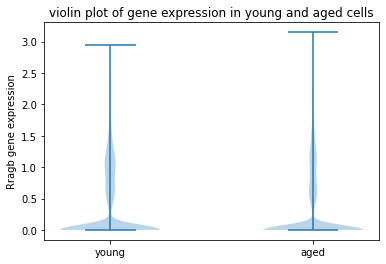

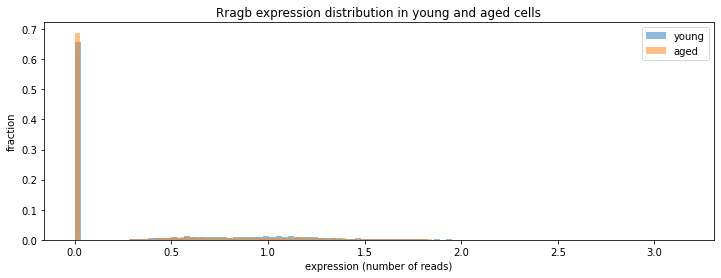

Klf8:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.239507
std          0.468383
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.976650
Name: Klf8, dtype: float64


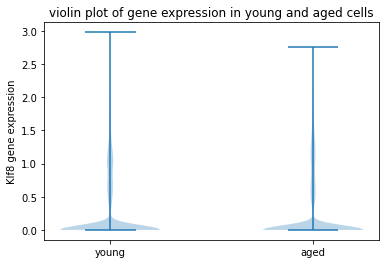

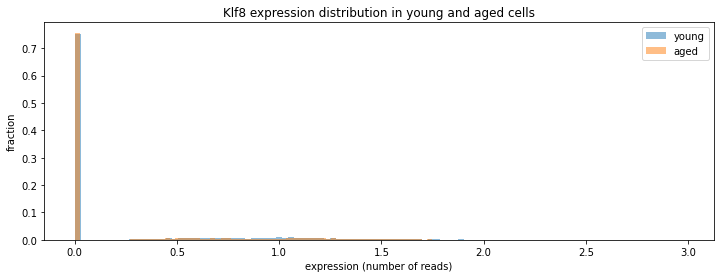

Ubqln2:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.115414
std          0.343395
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.629729
Name: Ubqln2, dtype: float64


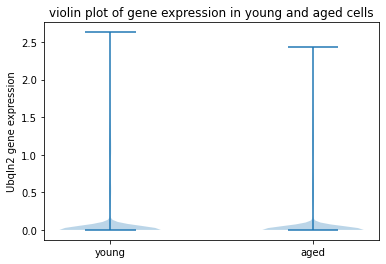

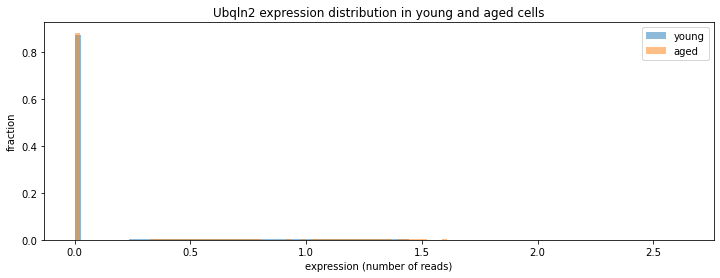

Nbdy:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.190315
std          0.426924
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.990900
Name: Nbdy, dtype: float64


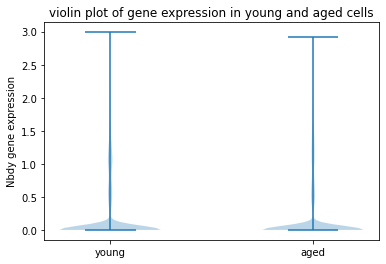

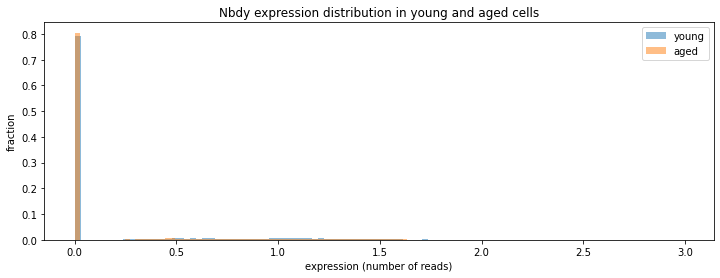

Prdx4:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.113415
std          0.330018
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.744449
Name: Prdx4, dtype: float64


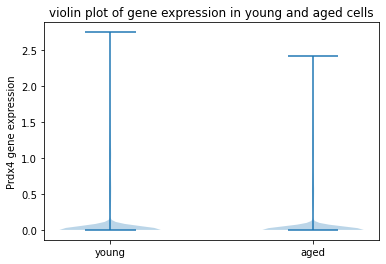

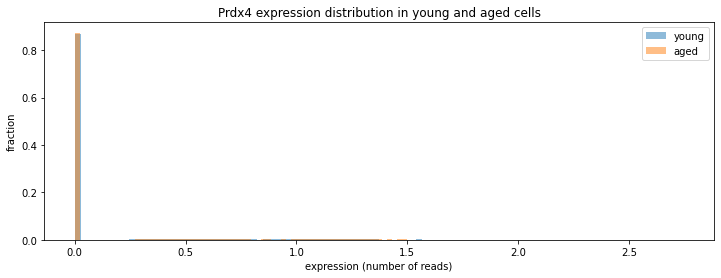

Ptchd1:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.237894
std          0.484895
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.776818
Name: Ptchd1, dtype: float64


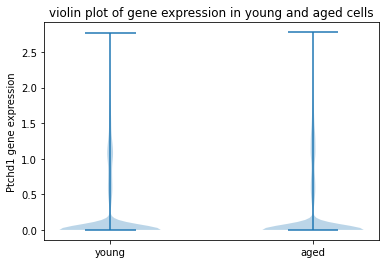

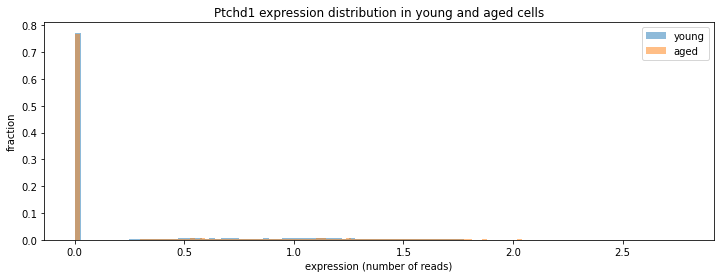

Gm15155:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.279841
std          0.564447
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          3.067427
Name: Gm15155, dtype: float64


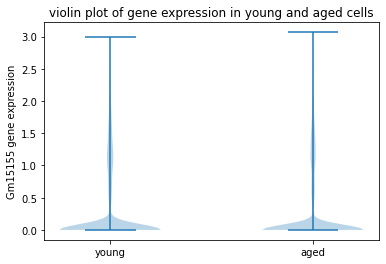

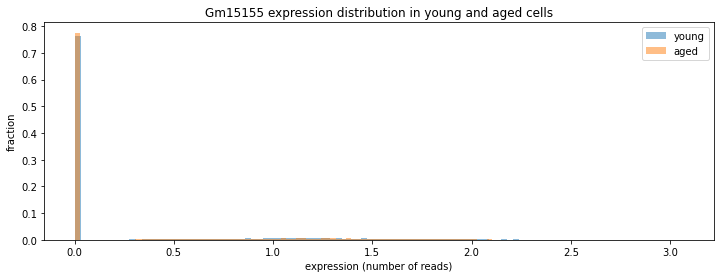

Sms:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.527006
std          0.632024
min          0.000000
25%          0.000000
50%          0.000000
75%          1.073888
max          3.131390
Name: Sms, dtype: float64


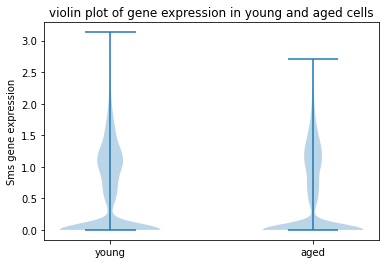

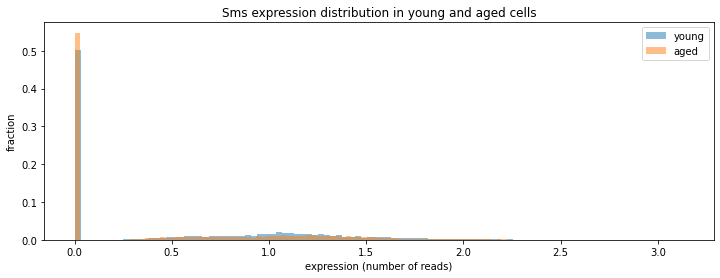

Mbtps2:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.262650
std          0.489689
min          0.000000
25%          0.000000
50%          0.000000
75%          0.393473
max          2.773527
Name: Mbtps2, dtype: float64


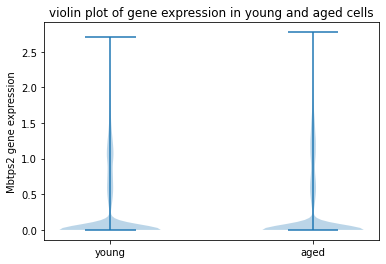

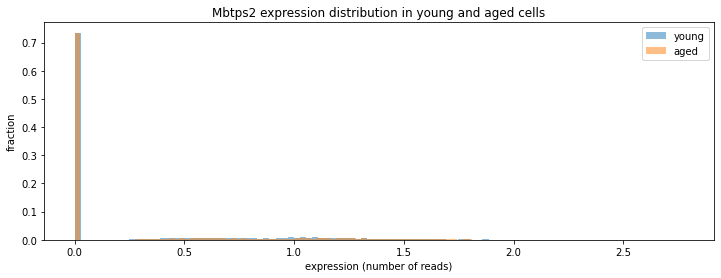

Cnksr2:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.501331
std          0.687697
min          0.000000
25%          0.000000
50%          0.000000
75%          1.070585
max          3.344180
Name: Cnksr2, dtype: float64


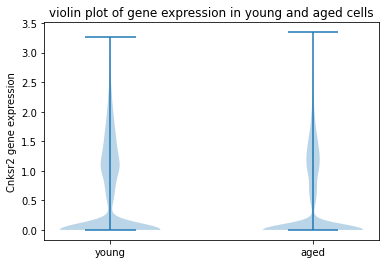

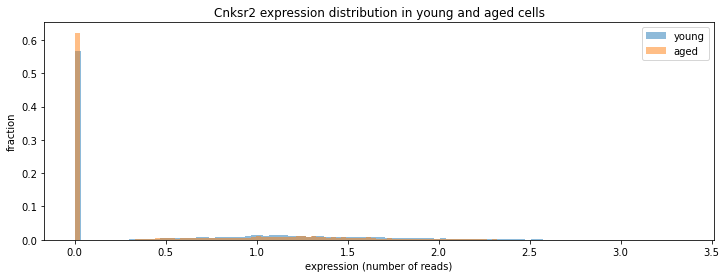

Rps6ka3:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.397142
std          0.595196
min          0.000000
25%          0.000000
50%          0.000000
75%          0.847158
max          3.190889
Name: Rps6ka3, dtype: float64


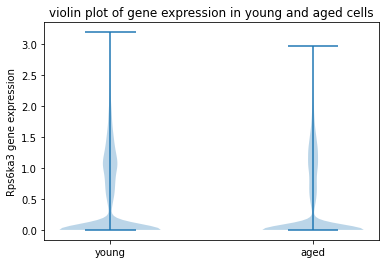

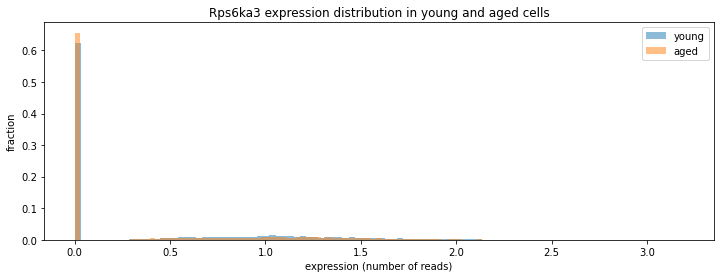

Eif1ax:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.131136
std          0.356031
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.961752
Name: Eif1ax, dtype: float64


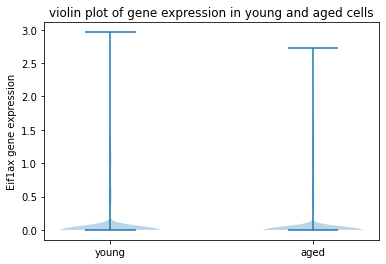

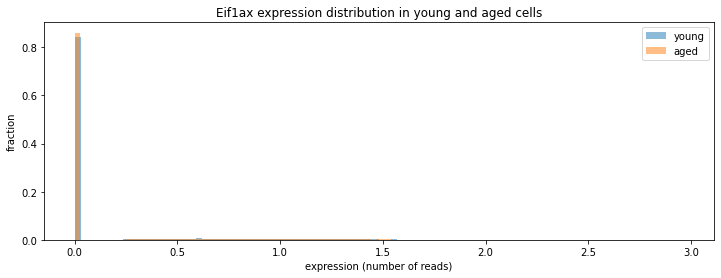

Map7d2:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.663732
std          0.681292
min          0.000000
25%          0.000000
50%          0.628612
75%          1.222380
max          3.420536
Name: Map7d2, dtype: float64


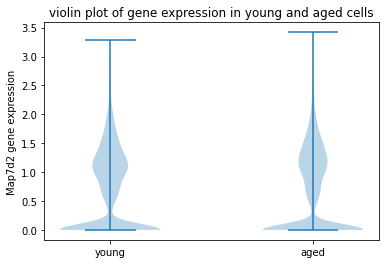

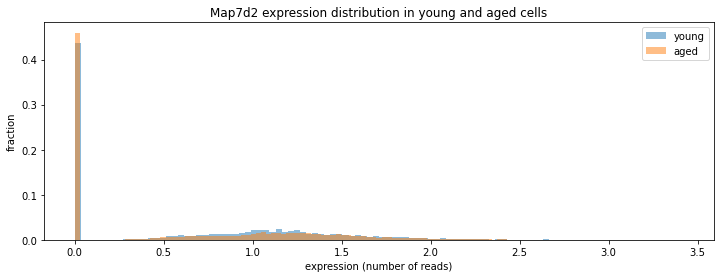

Bclaf3:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.234693
std          0.448952
min          0.000000
25%          0.000000
50%          0.000000
75%          0.321891
max          2.921800
Name: Bclaf3, dtype: float64


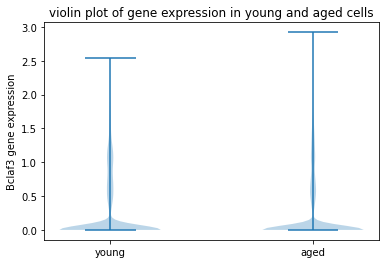

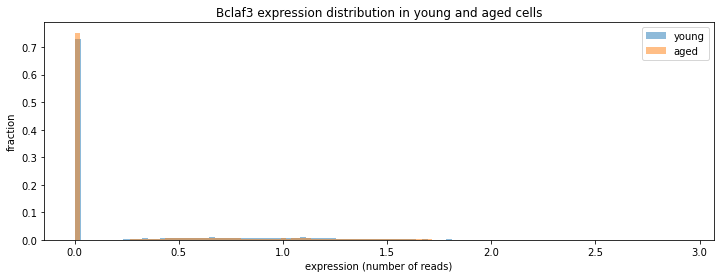

Sh3kbp1:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.669874
std          0.725080
min          0.000000
25%          0.000000
50%          0.514953
75%          1.281151
max          3.374741
Name: Sh3kbp1, dtype: float64


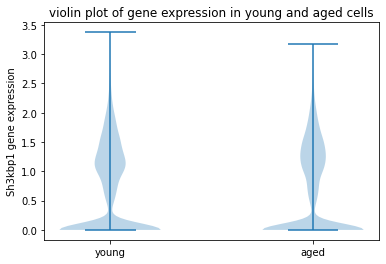

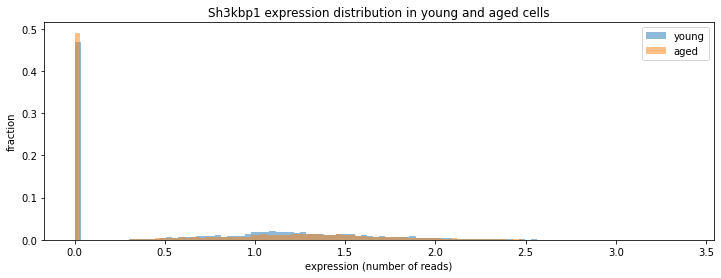

Pdha1:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.116381
std          0.331576
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.899628
Name: Pdha1, dtype: float64


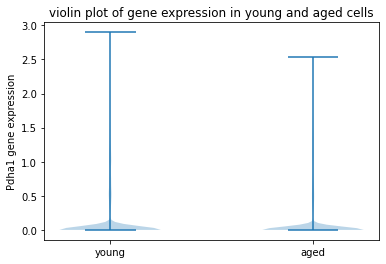

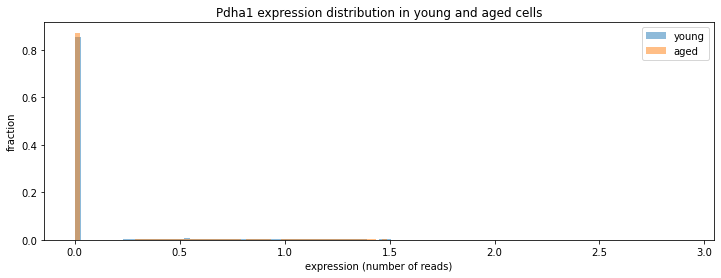

Phka2:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.229383
std          0.445005
min          0.000000
25%          0.000000
50%          0.000000
75%          0.248397
max          2.924298
Name: Phka2, dtype: float64


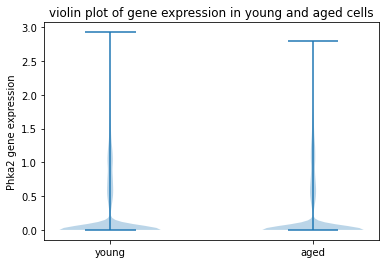

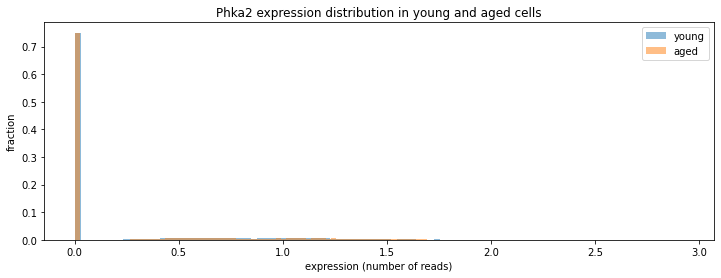

Cdkl5:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.459880
std          0.635026
min          0.000000
25%          0.000000
50%          0.000000
75%          0.998330
max          3.460487
Name: Cdkl5, dtype: float64


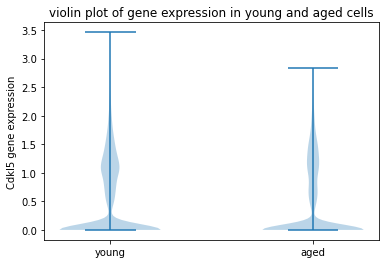

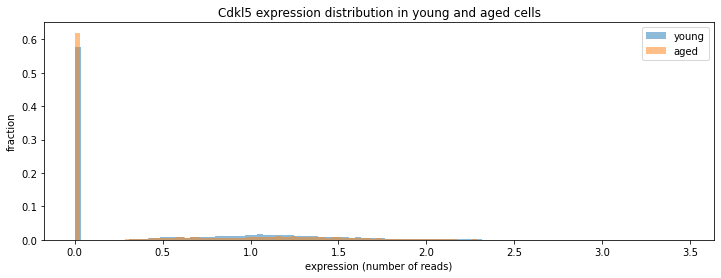

Rai2:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.129066
std          0.345901
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.621410
Name: Rai2, dtype: float64


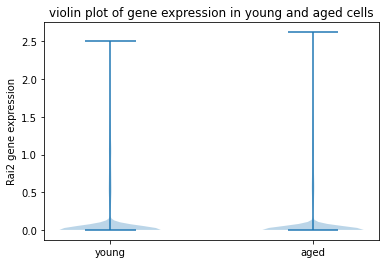

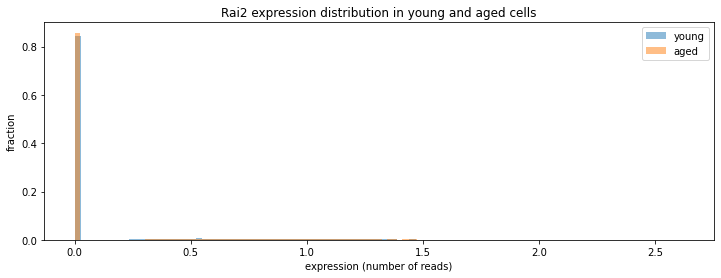

Nhs:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.860712
std          0.803926
min          0.000000
25%          0.000000
50%          0.992630
75%          1.519268
max          3.555737
Name: Nhs, dtype: float64


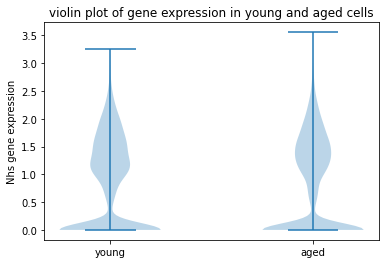

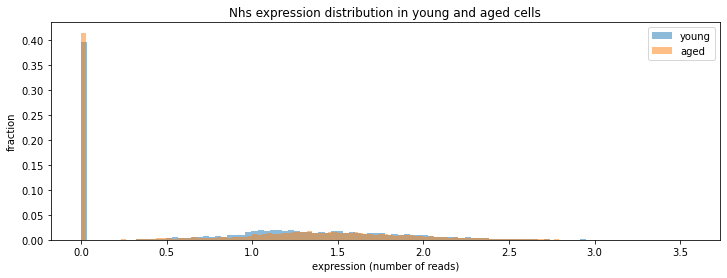

Reps2:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.674667
std          0.715679
min          0.000000
25%          0.000000
50%          0.573723
75%          1.271466
max          3.742293
Name: Reps2, dtype: float64


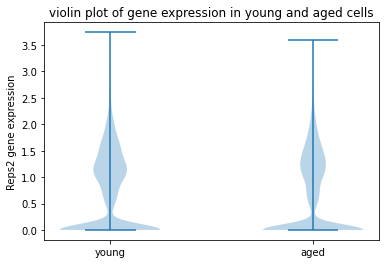

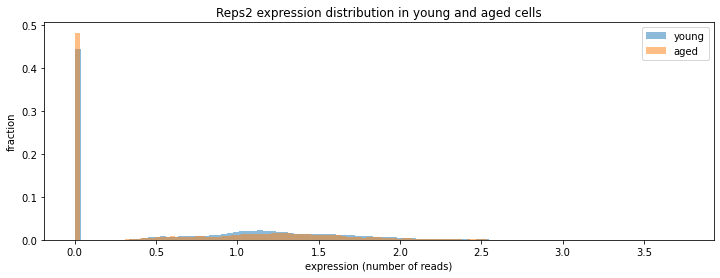

Rbbp7:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.252459
std          0.478044
min          0.000000
25%          0.000000
50%          0.000000
75%          0.353248
max          2.868540
Name: Rbbp7, dtype: float64


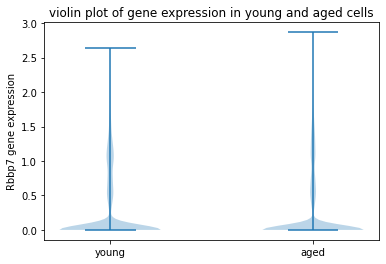

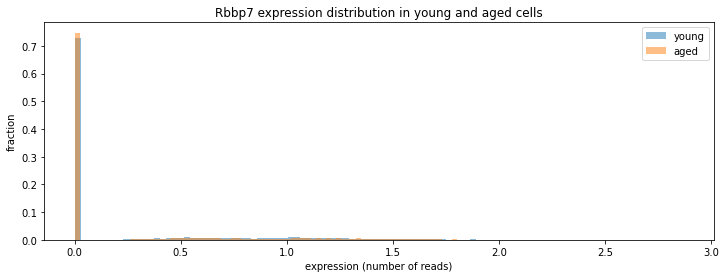

Txlng:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.495295
std          0.622865
min          0.000000
25%          0.000000
50%          0.000000
75%          1.030480
max          3.213515
Name: Txlng, dtype: float64


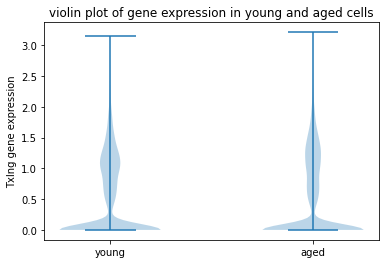

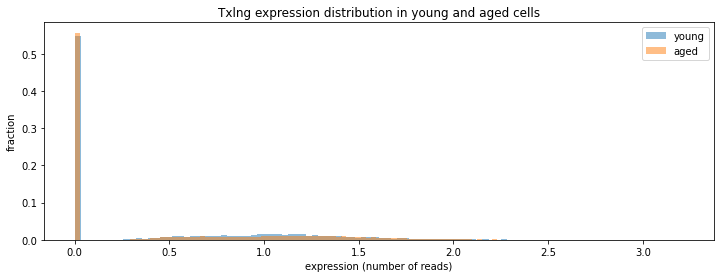

Syap1:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.118522
std          0.328252
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          3.750878
Name: Syap1, dtype: float64


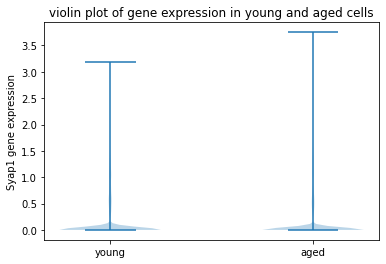

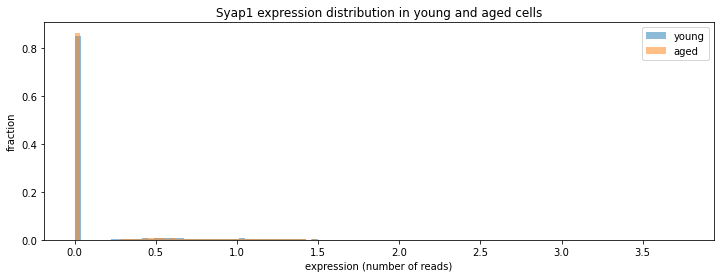

Ctps2:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.341911
std          0.535318
min          0.000000
25%          0.000000
50%          0.000000
75%          0.681528
max          3.117873
Name: Ctps2, dtype: float64


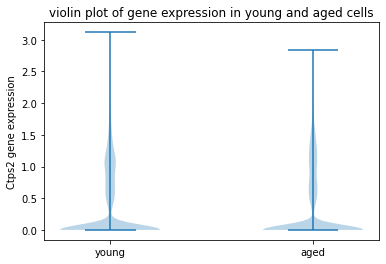

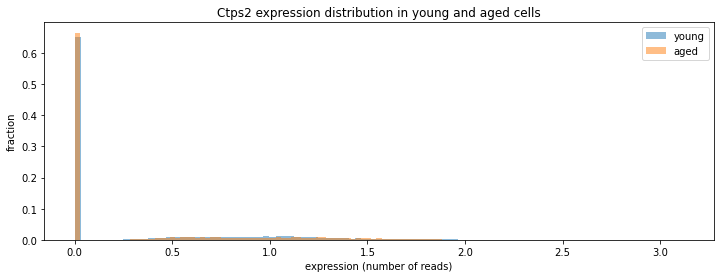

Ap1s2:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.217980
std          0.469048
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.821247
Name: Ap1s2, dtype: float64


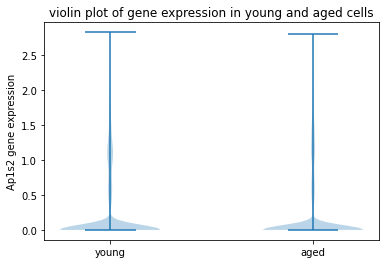

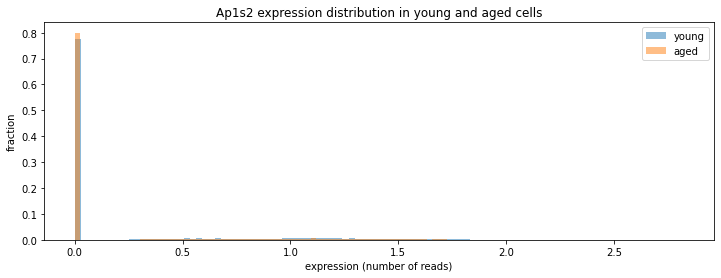

Zrsr2:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.132460
std          0.363587
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.792739
Name: Zrsr2, dtype: float64


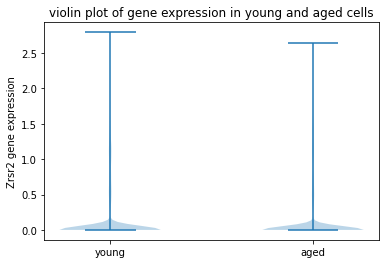

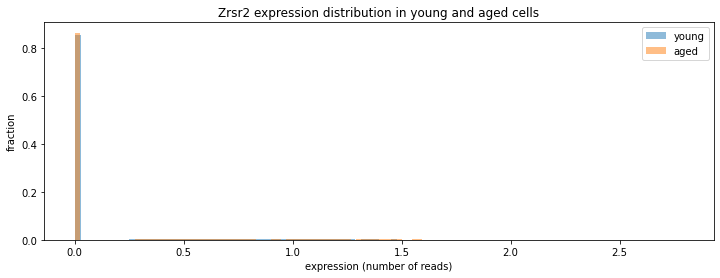

Mospd2:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.147042
std          0.369590
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.870109
Name: Mospd2, dtype: float64


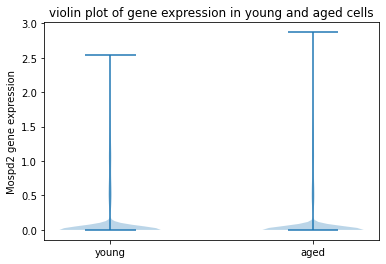

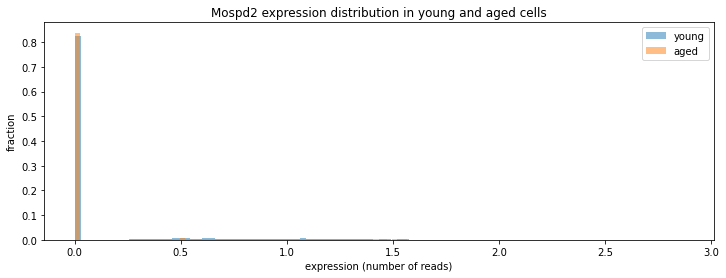

Glra2:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.277358
std          0.548784
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          3.030214
Name: Glra2, dtype: float64


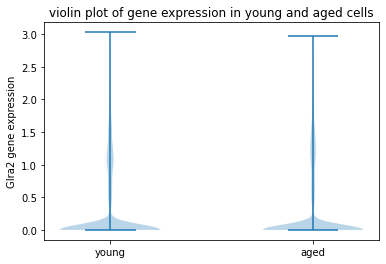

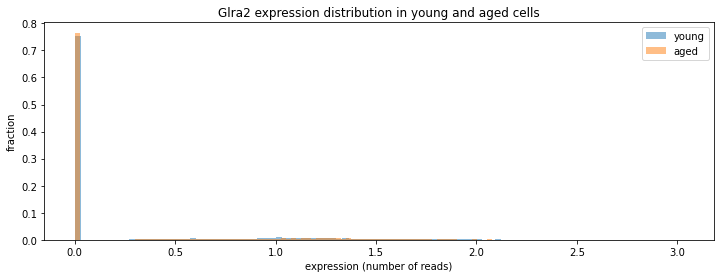

Gpm6b:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.562446
std          0.703231
min          0.000000
25%          0.000000
50%          0.000000
75%          1.151811
max          4.406170
Name: Gpm6b, dtype: float64


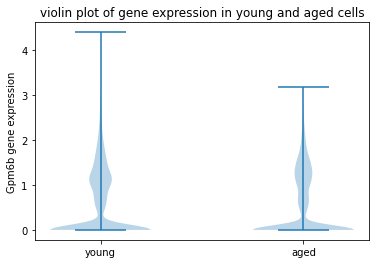

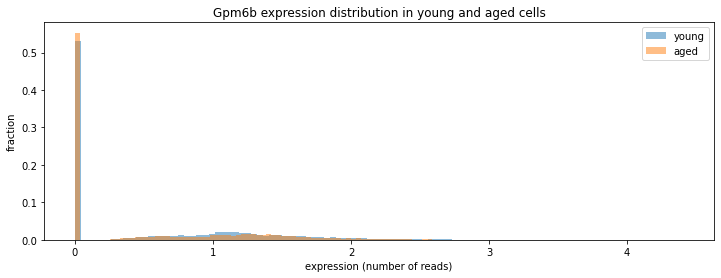

Ofd1:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.111236
std          0.317869
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.898007
Name: Ofd1, dtype: float64


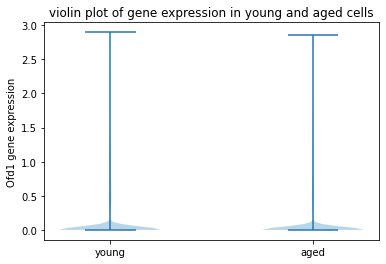

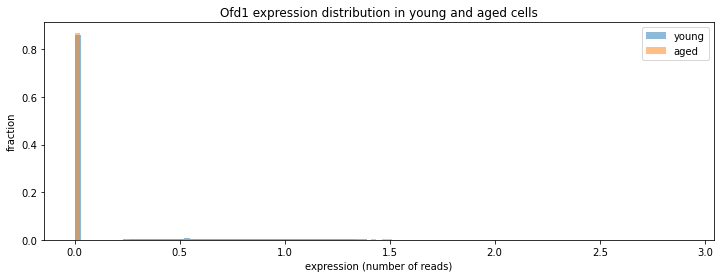

Tmsb4x:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.751958
std          0.787352
min          0.000000
25%          0.000000
50%          0.594250
75%          1.384516
max          3.574809
Name: Tmsb4x, dtype: float64


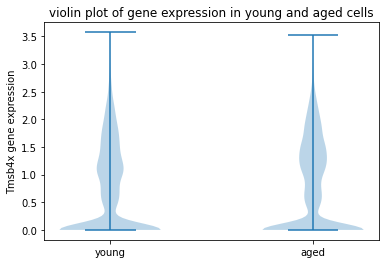

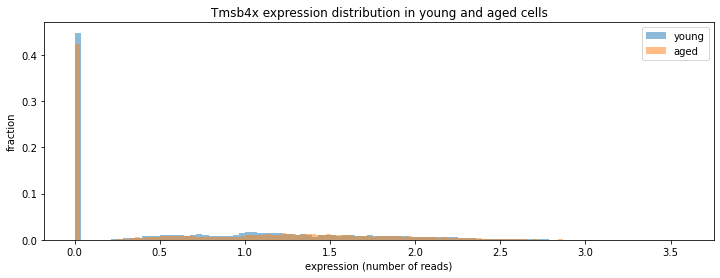

Frmpd4:
is a continuous feature, and here is the summary
count    25002.000000
mean         1.412673
std          1.094511
min          0.000000
25%          0.000000
50%          1.594896
75%          2.317512
max          4.676038
Name: Frmpd4, dtype: float64


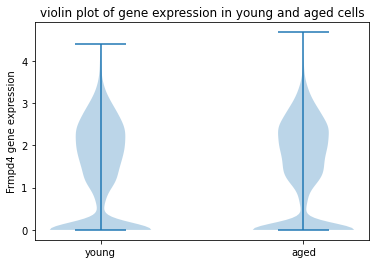

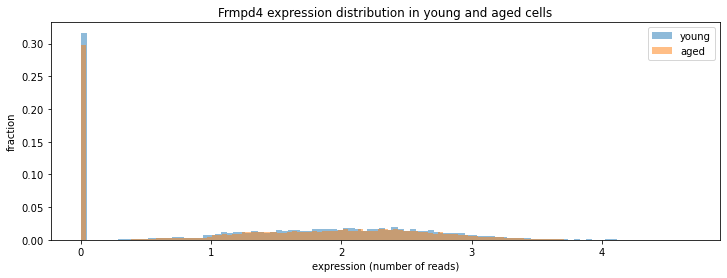

Arhgap6:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.440911
std          0.740037
min          0.000000
25%          0.000000
50%          0.000000
75%          0.890170
max          4.116561
Name: Arhgap6, dtype: float64


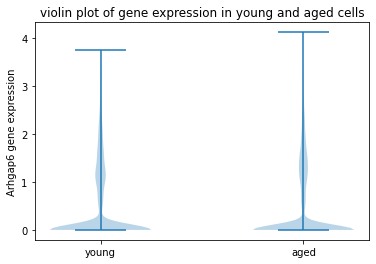

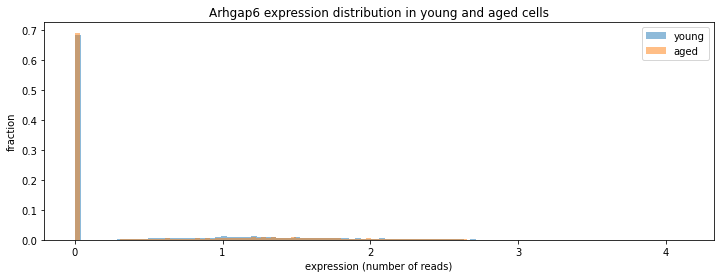

Gm15261:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.281804
std          0.608824
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          4.094618
Name: Gm15261, dtype: float64


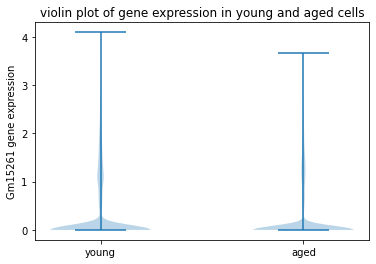

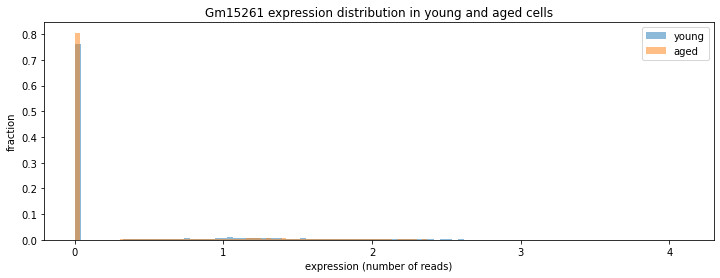

Gm15246:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.106540
std          0.321203
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.817294
Name: Gm15246, dtype: float64


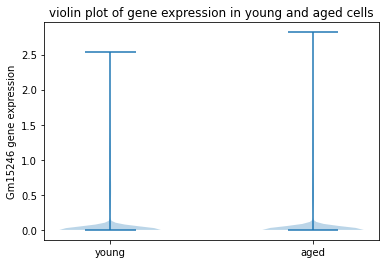

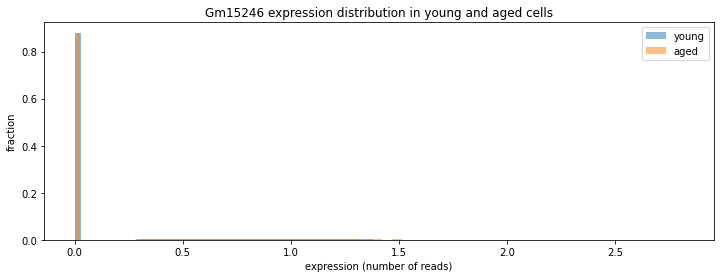

Mid1:
is a continuous feature, and here is the summary
count    25002.000000
mean         0.318059
std          0.530353
min          0.000000
25%          0.000000
50%          0.000000
75%          0.601635
max          2.954825
Name: Mid1, dtype: float64


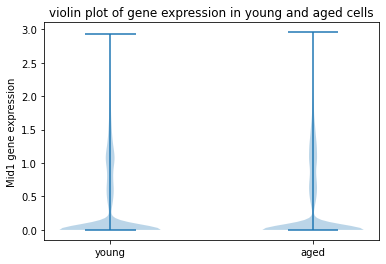

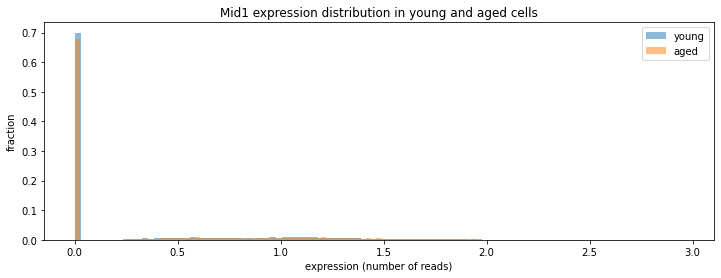

group:
is a categorical feature, and here is the summary
2    5180
1    4084
6    3986
4    3112
8    2966
7    2693
3    2476
5     505
Name: group, dtype: int64


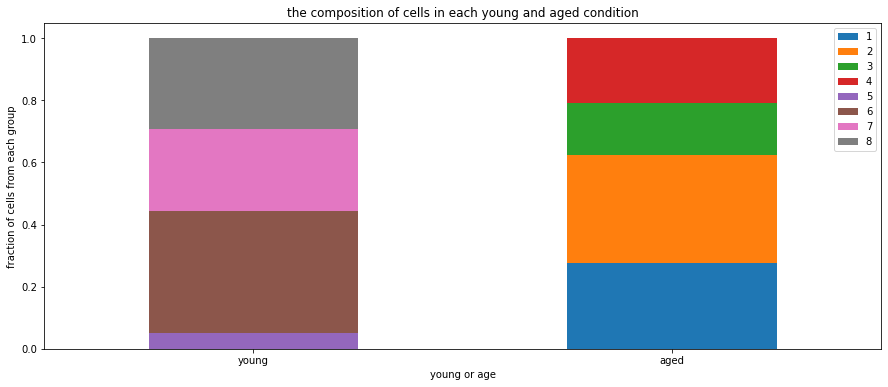

sum:
is a continuous feature, and here is the summary
count    25002.000000
mean      3476.941659
std        571.263080
min       1136.845222
25%       3092.435370
50%       3435.078535
75%       3987.663107
max       4769.698037
Name: sum, dtype: float64


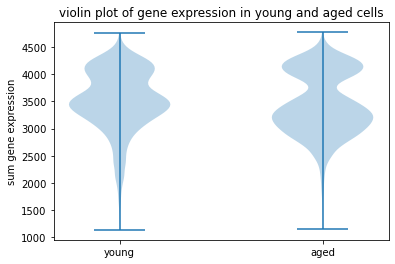

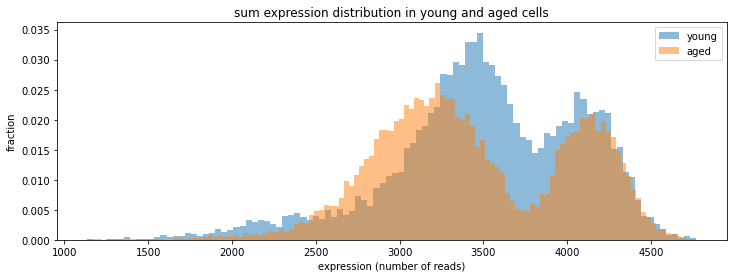

x_sum:
is a continuous feature, and here is the summary
count    25002.000000
mean       126.235260
std         20.541863
min         19.087869
25%        114.084020
50%        127.708667
75%        140.528750
max        223.677671
Name: x_sum, dtype: float64


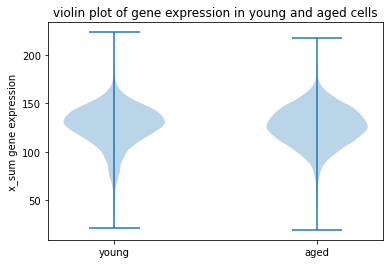

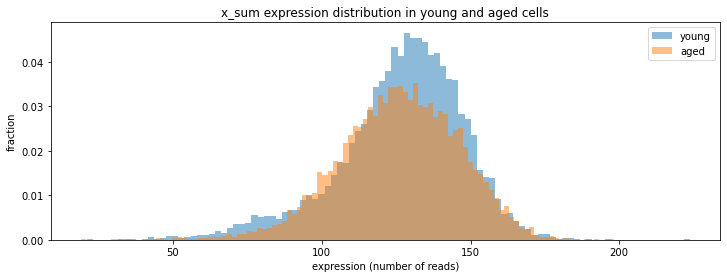

In [27]:
columns = X.columns[1:-1]

for i in columns:
    print(i+":")
    if (X[i].unique().shape[0] < 45):
        print('is a categorical feature, and here is the summary')
        print(X[i].value_counts())
        # stacked boxplot for catergorical vs catergorical feature
        count_matrix = merged_features.groupby(['target', i]).size().unstack()
        #print(count_matrix)
        count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)
        count_matrix_norm = pd.DataFrame(count_matrix_norm).rename(index={0:'young',1:'aged'})

        count_matrix_norm.plot(kind='bar', stacked=True, figsize = (15, 6))
        plt.ylabel('fraction of cells from each group')
        plt.xticks(rotation=0, horizontalalignment="center")
        plt.xlabel('young or age')      
        plt.legend()
        plt.title('the composition of cells in each young and aged condition')
        plt.show()

    else:
        print('is a continuous feature, and here is the summary')
        print(X[i].describe())
        dataset = [merged_features[merged_features['target']==0][i].values,
                   merged_features[merged_features['target']==1][i].values]
        plt.violinplot(dataset = dataset)
        plt.xticks([1,2],['young','aged'])
        plt.ylabel(i + ' gene expression') 
        plt.title('violin plot of gene expression in young and aged cells')
        plt.show()
        
    
        categories = [0,1]
        bin_range = (merged_features[i].min(),merged_features[i].max())
        plt.figure(figsize=(12,4))
        for c in categories:
            data = merged_features[merged_features['target']==c][i]
            plt.hist(data,
                     alpha=0.5,label=c,range=bin_range,
                     bins=int(np.sqrt(len(data))),
                     weights=np.ones(len(data)) / len(data),
                     density=False)
        plt.legend(['young', 'aged'])
        plt.ylabel('fraction')
        plt.xlabel('expression (number of reads)')
        plt.title(i +' expression distribution in young and aged cells')
        plt.show()

### b) plots of the features of interest <a name="3.-poa"></a>

In [36]:
print(X['tree.ident'].value_counts())

Trh/Gpc5              2796
Nrxn3/Sox2ot          2380
Npas3/Gm32647         1613
Rnf220/Ntng1          1599
Tcf4/Ebf1             1407
Slit3/Cacna2d1        1384
Chrm3/Schip1          1344
Meis2/Pou6f2          1185
Sst/Npy                996
Gal/Nts                944
Nfib/Tcf4              801
Sox2ot/Gal             798
Dgkb/B230323A14Rik     789
Celf2/Phactr1          723
Npsr1/Unc13c           679
Pomc/Tac2              494
Plp1/Ptgds             480
Pdzrn4/Kcnq5           475
Rgs6/B230323A14Rik     456
Synpr/Tafa1            428
Apoe/Atp1a2            412
Nrg1/Nnat              378
Cartpt/Pmch            366
Cartpt/Ebf1            339
Pard3b/Tac1            288
Satb2/Rab3b            213
Avp/Oxt                209
Tafa1/Pcdh11x          206
Kcnmb2/Hs3st4          203
Crh/Gpc5               160
Rfx4/Hcrt              134
Sgcd/Tac1              122
1700042O10Rik/Ddc       92
Hdc/Slc16a10            89
Slc1a3/Apoe             20
Name: tree.ident, dtype: int64


In [29]:
# check the target variable and its relationship with cell types (stacked bar plot):
count_matrix = merged_features.groupby(['tree.ident', 'target']).size().unstack()
#print(count_matrix)
count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)
count_matrix_norm = pd.DataFrame(count_matrix_norm).rename(columns={0:'young',1:'aged'})

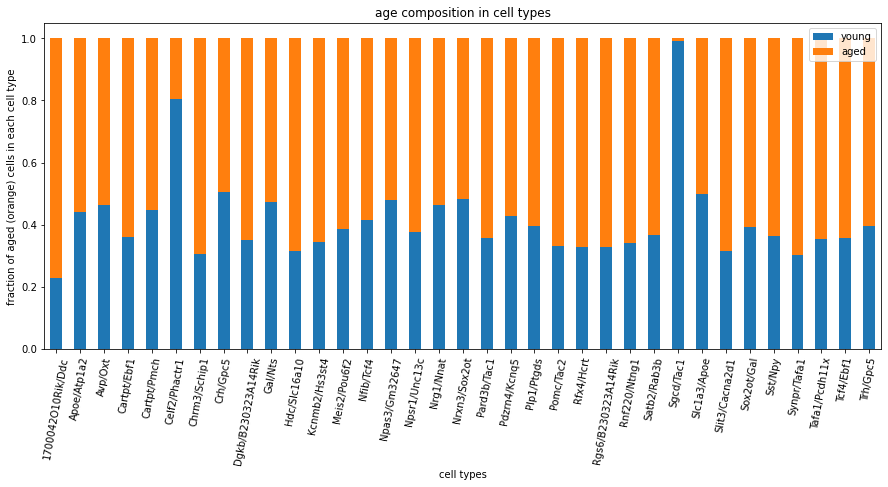

In [30]:
count_matrix_norm.plot(kind='bar', stacked=True, figsize = (15, 6))
plt.ylabel('fraction of aged (orange) cells in each cell type')
plt.xticks(rotation=80, horizontalalignment="center")
plt.xlabel('cell types')
plt.legend()
plt.title('age composition in cell types')
plt.savefig('cell_types_stacked_bar.png', dpi=300)
plt.show()

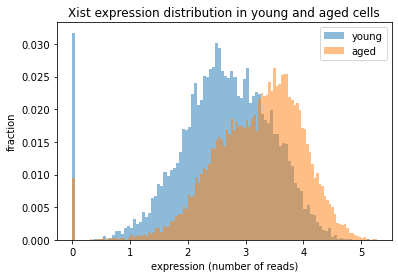

In [31]:
categories = [0,1]
bin_range = (merged_features['Xist'].min(),merged_features['Xist'].max())

for c in categories:
    data = merged_features[merged_features['target']==c]['Xist']
    plt.hist(data,alpha=0.5,label=c,range=bin_range,
             bins=int(np.sqrt(len(data))),
             weights=np.ones(len(data)) / len(data),
             density=False)
plt.legend(['young', 'aged'])
plt.ylabel('fraction')
plt.xlabel('expression (number of reads)')
plt.title('Xist expression distribution in young and aged cells')
plt.savefig('Xist_histogram.png', dpi=300)
plt.show()

In [32]:
print(X['x_prop'].describe())

count    25002.000000
mean         0.036536
std          0.004246
min          0.005585
25%          0.033676
50%          0.036236
75%          0.039183
max          0.092297
Name: x_prop, dtype: float64


In [33]:
# check the x:a in young cells
print(X[y == 0]['x_prop'].describe())

count    10150.000000
mean         0.036176
std          0.004070
min          0.013730
25%          0.033407
50%          0.035880
75%          0.038647
max          0.056290
Name: x_prop, dtype: float64


In [34]:
# check the x:a in aged cells
print(X[y == 1]['x_prop'].describe())

count    14852.000000
mean         0.036782
std          0.004344
min          0.005585
25%          0.033879
50%          0.036496
75%          0.039456
max          0.092297
Name: x_prop, dtype: float64


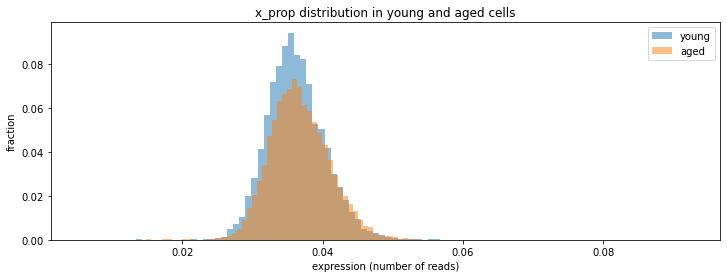

In [37]:
categories = [0,1]
plt.figure(figsize=(12,4))
bin_range = (merged_features['x_prop'].min(),merged_features['x_prop'].max())

for c in categories:
    data = merged_features[merged_features['target']==c]['x_prop']
    plt.hist(data,alpha=0.5,label=c,range=bin_range,
             bins=int(np.sqrt(len(data))),
             weights=np.ones(len(data)) / len(data),
             density=False)
plt.legend(['young', 'aged'])
plt.ylabel('fraction')
plt.xlabel('expression (number of reads)')
plt.title('x_prop distribution in young and aged cells')
plt.show()

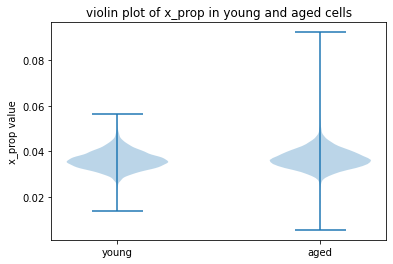

In [39]:
dataset = [merged_features[merged_features['target']==0]['x_prop'].values,
    merged_features[merged_features['target']==1]['x_prop'].values]
plt.violinplot(dataset = dataset)
plt.xticks([1,2],['young','aged'])
plt.ylabel( 'x_prop value') 
plt.title('violin plot of x_prop in young and aged cells')
plt.savefig('volin_x_prop.png', dpi=300)
plt.show()

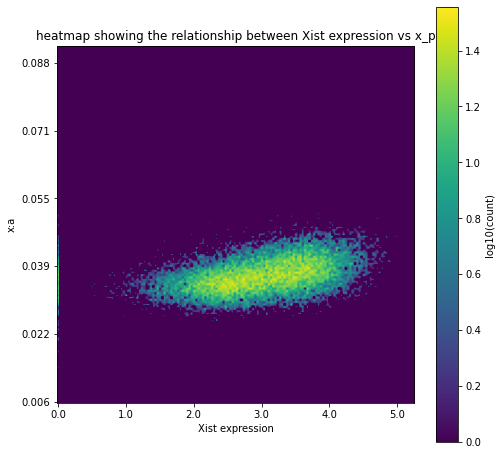

In [40]:
nbins = int(np.sqrt(merged_features.shape[0]))
heatmap, xedges, yedges = np.histogram2d(merged_features['Xist'], 
                                         merged_features['x_prop'], bins=nbins)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
heatmap[heatmap == 0] = 0.1 # we will use log and log(0) is undefined

plt.figure(figsize=(8,8))
plt.imshow(np.log10(heatmap).T, origin='lower',vmin=0) # use log count
plt.xlabel('Xist expression')
plt.ylabel('x:a')
plt.title('heatmap showing the relationship between Xist expression vs x_p')
plt.xticks(np.arange(nbins+1)[::30],xedges[::30].round(2))
plt.yticks(np.arange(nbins+1)[::30],yedges[::30].round(3))
plt.colorbar(label='log10(count)')
plt.savefig('heatmap_Xist_v_xp.png', dpi=300)
plt.show()

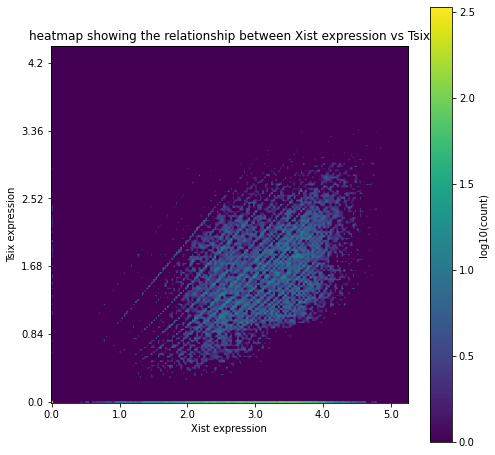

In [41]:
nbins = int(np.sqrt(merged_features.shape[0]))
heatmap, xedges, yedges = np.histogram2d(merged_features['Xist'], 
                                         merged_features['Tsix'], bins=nbins)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
heatmap[heatmap == 0] = 0.1 # we will use log and log(0) is undefined

plt.figure(figsize=(8,8))
plt.imshow(np.log10(heatmap).T, origin='lower',vmin=0) # use log count
plt.xlabel('Xist expression')
plt.ylabel('Tsix expression')
plt.title('heatmap showing the relationship between Xist expression vs Tsix')
plt.xticks(np.arange(nbins+1)[::30],xedges[::30].round(2))
plt.yticks(np.arange(nbins+1)[::30],yedges[::30].round(2))
plt.colorbar(label='log10(count)')
plt.savefig('heatmap_Xist_v_Tsix.png', dpi=300)
plt.show()

### c) Scatter matrix<a name="4.-scattermatrix"></a>

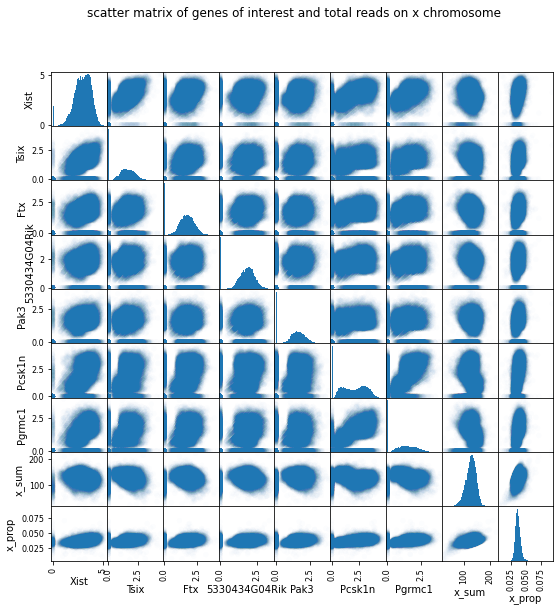

In [44]:
pd.plotting.scatter_matrix(merged_features[['Xist', 'Tsix', 'Ftx', 
                                            '5330434G04Rik','Pak3', 'Pcsk1n',
                                            'Pgrmc1', 'x_sum', 'x_prop']], 
                           figsize=(9, 9), marker='o',hist_kwds={'bins': 50}, 
                           s=30, alpha=.01)
plt.suptitle('scatter matrix of genes of interest and total reads on x chromosome')
plt.savefig('scatter_matrx.png', dpi=300)
plt.show()